In [24]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance
import scipy.stats as ss

In [25]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [26]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [27]:
# from f_mean_adjust_ss_wasserstein_toad import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics, radial_flow, nf_transform)

In [55]:
import warnings
from functools import partial

eps = 0.01
eps_precision = 100
# Checking types
# # get numba types e.g.,
# print('alphatype: {}'.format(numba.typeof(alpha)))
# print('betatype: {}'.format(numba.typeof(beta)))
# print('gammatype: {}'.format(numba.typeof(gamma)))
# print('deltatype: {}'.format(numba.typeof(delta)))
# print('dataset_sizetype: {}'.format(numba.typeof(dataset_size)))
# print('num_datasetstype: {}'.format(numba.typeof(num_datasets)))
# print('rtype: {}'.format(numba.typeof(r)))

# datatype: array(float64, 1d, C)
# outputtype: array(float64, 1d, C)
# alphatype: float64
# betatype: float64
# gammatype: float64
# deltatype: float64
# dataset_sizetype: int64
# num_datasetstype: int64
# rtype: array(float64, 2d, C)

# to specify eagerly would be like (float64[:,::1](float64, float64, float64, float64, int64, int64))

# Be careful with which functions you are jit ing - there is overhead so 
# you don't want to jit everything
scaler_mean = np.array([6.88309356, 3.7018531 , 7.48299995, 6.74311246, 3.95255496,
       7.48793626, 6.65480887, 4.03276287, 7.49082927, 6.54944629,
       4.0455079 , 7.48812704])
scaler_std = np.array([0.04392552, 0.04082479, 0.73132247, 0.0506213 , 0.04956294,
       0.72842914, 0.05515547, 0.05492013, 0.72578321, 0.0568355 ,
       0.05651429, 0.72656191])
lags = [1, 2, 4, 8]
len_ss = np.shape(scaler_mean)[0]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
d_Lambda = 2 + len_ss
num_layers = 5
Lambda_list = np.load('Lambda_list_toad.npy', allow_pickle=True)
## Generate actual data
def toad(alpha,
         gamma,
         p0,
         n_toads=66,
         n_days=63,
         batch_size=1,
         random_state=None):
    """Sample the movement of Fowler's toad species.
    Models foraging steps using a levy_stable distribution where individuals
    either return to a previous site or establish a new one.
    References
    ----------
    Marchand, P., Boenke, M., and Green, D. M. (2017).
    A stochastic movement model reproduces patterns of site fidelity and long-
    distance dispersal in a population of fowlers toads (anaxyrus fowleri).
    Ecological Modelling,360:63–69.
    Parameters
    ----------
    alpha : float or array_like with batch_size entries
        step length distribution stability parameter
    gamma : float or array_like with batch_size entries
        step lentgh distribution scale parameter
    p0 : float or array_like with batch_size entries
        probability of returning to a previous refuge site
    n_toads : int, optional
        number of toads
    n_days : int, optional
        number of days
    batch_size : int, optional
    random_state : RandomState, optional
    Returns
    -------
    np.ndarray in shape (n_days x n_toads x batch_size)
    """
    X = np.zeros((n_days, n_toads, batch_size))
    random_state = random_state or np.random
    step_gen = ss.levy_stable
    step_gen.random_state = random_state

    for i in range(1, n_days):
        ret = random_state.uniform(0, 1, (n_toads, batch_size)) < np.squeeze(p0)
        non_ret = np.invert(ret)

        delta_x = step_gen.rvs(alpha, beta=0, scale=gamma, size=(n_toads, batch_size))
        X[i, non_ret] = X[i-1, non_ret] + delta_x[non_ret]

        ind_refuge = random_state.choice(i, size=(n_toads, batch_size))
        X[i, ret] = X[ind_refuge[ret], ret]

    return X


def compute_summaries(X, lag, p=np.linspace(0, 1, 3), thd=10):
    """Compute summaries for toad model.
    For displacements over lag...
        Log of the differences in the p quantiles
        The number of absolute displacements less than thd
        Median of the absolute displacements greater than thd
    Parameters
    ----------
    X : np.array of shape (ndays x ntoads x batch_size)
        observed matrix of toad displacements
    lag : list of ints, optional
        the number of days behind to compute displacement with
    p : np.array, optional
        quantiles used in summary statistic calculation (default 0, 0.1, ... 1)
    thd : float
        toads are considered returned when absolute displacement does not exceed thd (default 10m)
    Returns
    -------
    np.ndarray in shape (batch_size x len(p) + 1)
    """
    disp = obs_mat_to_deltax(X, lag)  # num disp at lag x batch size
    abs_disp = np.abs(disp)
    # returned toads
    ret = abs_disp < thd
    num_ret = np.sum(ret, axis=0)
    # non-returned toads
    abs_disp[ret] = np.nan  # ignore returned toads
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        # abs_noret_median = np.nanmedian(abs_disp, axis=0)
        abs_noret_quantiles = np.nanquantile(abs_disp, p, axis=0)
    diff = np.diff(abs_noret_quantiles, axis=0)
    logdiff = np.log(np.maximum(diff, np.exp(-20)))  # substitute zeros with a small positive
    # combine
    # ssx = np.vstack((num_ret, abs_noret_median, logdiff))
    ssx = np.vstack((np.log(num_ret), logdiff))
    ssx = np.nan_to_num(ssx, nan=np.inf)  # nans are when all toads returned
    return np.transpose(ssx)


def obs_mat_to_deltax(X, lag):
    """Convert an observation matrix to a vector of displacements.
    Parameters
    ----------
    X : np.array (n_days x n_toads x batch_size)
        observed matrix of toad displacements
    lag : int
        the number of days behind to compute displacement with
    Returns
    -------
    np.ndarray in shape (n_toads * (n_days - lag) x batch_size)
    """
    batch_size = np.atleast_3d(X).shape[-1]
    return (X[lag:] - X[:-lag]).reshape(-1, batch_size)

def compute_summaries_stacked(X, lags):
    S1 = compute_summaries(X, lags[0])
    S2 = compute_summaries(X, lags[1])
    S4 = compute_summaries(X, lags[2])
    S8 = compute_summaries(X, lags[3])
    return np.hstack((S1, S2, S4, S8))

def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = np.exp(Lambda_k[0])
        beta = -alpha + np.exp(Lambda_k[1])
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = np.sqrt(np.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += np.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * np.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

# transform_auto = vmap(radial_flow, in_axes=[None, 0])

def nf_transform(n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for j in range(np.shape(n_summary_statistics)[0]):
        for i in range(len(Lambda_list)):
            n_summary_statistics[j] = radial_flow(Lambda_list[i], n_summary_statistics[j])[0]
    return n_summary_statistics

## LOAD DATASET

In [29]:
true_theta = np.array([1.7, 35.0, 0.6])

In [30]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [ -66.18523659],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [  -5.09219491]],

       ...,

       [[  34.60490682],
        [  11.23572937],
        [   0.        ],
        ...,
        [  -5.63222094],
        [   0.        ],
        [  36.63519599]],

       [[ 192.86201079],
        [   0.        ],
        [   0.        ],
        ...,
        [-192.95323219],
        [  10.21556164],
        [   0.        ]],

       [[   0.        ],
        [ -31.32009155],
        [  13.94483174],
        ...,
        [-203.16994206],
        [  57.06792626],
        [ -51.45997265]]

In [31]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [32]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.85646198, 3.62304683, 7.24713049, 6.67456139, 3.84229264,
       7.22622446, 6.64509097, 3.94446834, 7.26402554, 6.54965074,
       3.99137271, 7.26218951])

## Training NF

In [33]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 1000
wass_val_num_datasets = 1000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 5
# To optimize F
tau = 0.1
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 50
Patience_f = 51
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [51]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=wass_num_datasets)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_num_datasets)])
val_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_val_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [52]:
scaler_mean = np.mean(original_n_summary_statistics, axis=0)
scaler_std = np.std(original_n_summary_statistics, axis=0)

In [36]:
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [37]:
Lambda_list = np.load('Lambda_list_toad.npy', allow_pickle=True)

In [38]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x
def kl(x):
    return 1/2 * x.T @ x
def f_with_Lambda_(Lambda, x):
    T_x, log_Jacobian = radial_flow(Lambda, x)
    diff = x - T_x
    f = - log_Jacobian + 1/2 * T_x.T @ T_x + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    return f
def mean_f(Lambda, x):
    mean_f = jnp.mean(f_with_Lambda_batched(Lambda, x))
    return mean_f

In [39]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))
f_with_Lambda_batched = vmap(f_with_Lambda_, in_axes=(None, 0))
kl_auto = vmap(kl)
KL_all = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
# Pre-compute random permutations outside the loop for efficiency
random_permutations = [random.permutation(subkey, wass_num_datasets) for subkey in subkeys1]

for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random_permutations[t][:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(mean_f, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = mean_f(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    KL_all.append(kl_k)
    print('>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<<', kl_k)
    if kl_k > jnp.min(jnp.array(KL_all)):
        patience += 1
    else:
        patience = 0
        transformed_n_summary_statistics = wass_n_summary_statistics
    if patience > Patience:
        print("Stop at", k)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 7.599231
F Smoothed 7.5114365
F Smoothed 7.4816465
F Smoothed 7.403946
F Smoothed 7.220421
F Smoothed 7.1883955
F Smoothed 7.152707
F Smoothed 7.107271
F Smoothed 7.2060385
F Smoothed 7.11189
F Smoothed 7.107544
F Smoothed 7.183717
F Smoothed 7.2402205
F Smoothed 7.1565766
F Smoothed 7.145817
F Smoothed 7.1829214
F Smoothed 7.006553
F Smoothed 7.016657
F Smoothed 6.902798
F Smoothed 6.801915
F Smoothed 6.7540708
F Smoothed 6.687755
F Smoothed 6.6601562
F Smoothed 6.6290884
F Smoothed 6.5311527
F Smoothed 6.5333686
F Smoothed 6.454353
F Smoothed 6.476215
F Smoothed 6.378779
F Smoothed 6.4356213
F Smoothed 6.264521
F Smoothed 6.2956486
F Smoothed 6.250794
F Smoothed 6.1824713
F Smoothed 6.1862106
F Smoothed 6.198699
F Smoothed 6.141696
F Smoothed 6.157732
F Smoothed 6.111547
F Smoothed 6.0752153
F Smoothed 6.1168313
F Smoothed 6.144228
F Smoothed 6.166173
F Smoothed 6.043897
F Smoothed 6.020189
F Smoothed 5.976023
F Smoothed 5.9450855
F Smoothed 5.9856386
F Smoothed 6.0329714


  0%|          | 1/5000 [00:34<47:47:17, 34.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.52408
F Smoothed 6.632606
F Smoothed 6.5774465
F Smoothed 6.5681896
F Smoothed 6.533968
F Smoothed 6.407213
F Smoothed 6.398775
F Smoothed 6.388805
F Smoothed 6.3641233
F Smoothed 6.4793925
F Smoothed 6.430488
F Smoothed 6.4487267
F Smoothed 6.530762
F Smoothed 6.608769
F Smoothed 6.5638657
F Smoothed 6.569733
F Smoothed 6.626989
F Smoothed 6.4972634
F Smoothed 6.51842
F Smoothed 6.4451914
F Smoothed 6.37289
F Smoothed 6.35822
F Smoothed 6.3279395
F Smoothed 6.324608
F Smoothed 6.3109617
F Smoothed 6.241085
F Smoothed 6.2579226
F Smoothed 6.2062287
F Smoothed 6.23617
F Smoothed 6.169426
F Smoothed 6.2399054
F Smoothed 6.1037946
F Smoothed 6.1661353
F Smoothed 6.137844
F Smoothed 6.0864644
F Smoothed 6.107837
F Smoothed 6.1301665
F Smoothed 6.104588
F Smoothed 6.13665
F Smoothed 6.1084695
F Smoothed 6.090694
F Smoothed 6.130606
F Smoothed 6.1704774
F Smoothed 6.1988797
F Smoothed 6.1018624
F Smoothed 6.089612
F Smoothed 6.0593944
F

  0%|          | 2/5000 [01:44<77:11:00, 55.59s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.52962
F Smoothed 6.6499224
F Smoothed 6.594526
F Smoothed 6.5848064
F Smoothed 6.5507736
F Smoothed 6.424553
F Smoothed 6.4159555
F Smoothed 6.406315
F Smoothed 6.381312
F Smoothed 6.4972053
F Smoothed 6.4491343
F Smoothed 6.46745
F Smoothed 6.5495157
F Smoothed 6.6279097
F Smoothed 6.583783
F Smoothed 6.58987
F Smoothed 6.6474295
F Smoothed 6.517568
F Smoothed 6.5381985
F Smoothed 6.465192
F Smoothed 6.3924966
F Smoothed 6.377802
F Smoothed 6.348157
F Smoothed 6.3454366
F Smoothed 6.331907
F Smoothed 6.2619524
F Smoothed 6.2790904
F Smoothed 6.2271166
F Smoothed 6.2573633
F Smoothed 6.1904845
F Smoothed 6.261554
F Smoothed 6.1246324
F Smoothed 6.187451
F Smoothed 6.1589727
F Smoothed 6.1070704
F Smoothed 6.1283445
F Smoothed 6.1509643
F Smoothed 6.1260037
F Smoothed 6.1583257
F Smoothed 6.1296024
F Smoothed 6.111727
F Smoothed 6.151085
F Smoothed 6.1916027
F Smoothed 6.2205834
F Smoothed 6.122997
F Smoothed 6.110656
F Smoothed 6.

  0%|          | 3/5000 [02:41<77:59:24, 56.19s/it]

F Smoothed 6.8154345
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.54448
F Smoothed 6.6806726
F Smoothed 6.625037
F Smoothed 6.615056
F Smoothed 6.5809236
F Smoothed 6.4541106
F Smoothed 6.4456344
F Smoothed 6.4361553
F Smoothed 6.411527
F Smoothed 6.5278206
F Smoothed 6.4798303
F Smoothed 6.4982
F Smoothed 6.5808053
F Smoothed 6.659107
F Smoothed 6.6149664
F Smoothed 6.6216826
F Smoothed 6.6794004
F Smoothed 6.548771
F Smoothed 6.568909
F Smoothed 6.495492
F Smoothed 6.422231
F Smoothed 6.406861
F Smoothed 6.3773265
F Smoothed 6.3751903
F Smoothed 6.3618374
F Smoothed 6.2917213
F Smoothed 6.3092
F Smoothed 6.2567596
F Smoothed 6.2873645
F Smoothed 6.219878
F Smoothed 6.2915325
F Smoothed 6.1535807
F Smoothed 6.2162437
F Smoothed 6.187613
F Smoothed 6.1351643
F Smoothed 6.15595
F Smoothed 6.1787357
F Smoothed 6.1540923
F Smoothed 6.186631
F Smoothed 6.157315
F Smoothed 6.1393495
F Smoothed 6.1780314
F Smoothed 6.219184
F Smoothed 6.24872
F Smoothed 6.1505175
F Smo

  0%|          | 4/5000 [03:35<76:34:03, 55.17s/it]

F Smoothed 6.8486724
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.57072
F Smoothed 6.7107267
F Smoothed 6.6549444
F Smoothed 6.6445985
F Smoothed 6.6103787
F Smoothed 6.483265
F Smoothed 6.4748597
F Smoothed 6.465524
F Smoothed 6.4412656
F Smoothed 6.5576706
F Smoothed 6.5097575
F Smoothed 6.5282793
F Smoothed 6.6109943
F Smoothed 6.688816
F Smoothed 6.644594
F Smoothed 6.6519012
F Smoothed 6.709577
F Smoothed 6.5783334
F Smoothed 6.5977883
F Smoothed 6.5240436
F Smoothed 6.4503565
F Smoothed 6.4343143
F Smoothed 6.4051027
F Smoothed 6.403726
F Smoothed 6.3904343
F Smoothed 6.3201275
F Smoothed 6.338079
F Smoothed 6.285375
F Smoothed 6.3161807
F Smoothed 6.248251
F Smoothed 6.3204737
F Smoothed 6.181783
F Smoothed 6.244076
F Smoothed 6.2154913
F Smoothed 6.1624293
F Smoothed 6.1826844
F Smoothed 6.205625
F Smoothed 6.1813564
F Smoothed 6.214141
F Smoothed 6.1843505
F Smoothed 6.16646
F Smoothed 6.2042823
F Smoothed 6.246123
F Smoothed 6.2761803
F Smoothed 6.17763

  0%|          | 5/5000 [04:19<70:59:07, 51.16s/it]

F Smoothed 6.8797755
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.61143
F Smoothed 6.738198
F Smoothed 6.682416
F Smoothed 6.671645
F Smoothed 6.6373353
F Smoothed 6.510298
F Smoothed 6.501912
F Smoothed 6.492709
F Smoothed 6.4687138
F Smoothed 6.584914
F Smoothed 6.5370245
F Smoothed 6.5558085
F Smoothed 6.6380887
F Smoothed 6.71506
F Smoothed 6.6706853
F Smoothed 6.678419
F Smoothed 6.7358384
F Smoothed 6.6042037
F Smoothed 6.6227417
F Smoothed 6.548772
F Smoothed 6.4748483
F Smoothed 6.4582644
F Smoothed 6.429713
F Smoothed 6.429296
F Smoothed 6.4157977
F Smoothed 6.34513
F Smoothed 6.363704
F Smoothed 6.311071
F Smoothed 6.3418965
F Smoothed 6.2737913
F Smoothed 6.346544
F Smoothed 6.2075486
F Smoothed 6.269165
F Smoothed 6.240878
F Smoothed 6.1871586
F Smoothed 6.2070055
F Smoothed 6.2301545
F Smoothed 6.206257
F Smoothed 6.2392626
F Smoothed 6.20918
F Smoothed 6.1914806
F Smoothed 6.2283273
F Smoothed 6.2709394
F Smoothed 6.301421
F Smoothed 6.202922
F Smoo

  0%|          | 6/5000 [05:03<67:37:36, 48.75s/it]

F Smoothed 6.9075265
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.66972
F Smoothed 6.760507
F Smoothed 6.704936
F Smoothed 6.693814
F Smoothed 6.6593757
F Smoothed 6.532888
F Smoothed 6.524418
F Smoothed 6.5153217
F Smoothed 6.491385
F Smoothed 6.6069665
F Smoothed 6.559032
F Smoothed 6.578156
F Smoothed 6.659421
F Smoothed 6.735204
F Smoothed 6.690668
F Smoothed 6.6985445
F Smoothed 6.755417
F Smoothed 6.623733
F Smoothed 6.641105
F Smoothed 6.56706
F Smoothed 6.4931517
F Smoothed 6.4762626
F Smoothed 6.448824
F Smoothed 6.4495125
F Smoothed 6.435396
F Smoothed 6.3641205
F Smoothed 6.3833942
F Smoothed 6.3312974
F Smoothed 6.3619313
F Smoothed 6.2940335
F Smoothed 6.3671656
F Smoothed 6.2284827
F Smoothed 6.289041
F Smoothed 6.261337
F Smoothed 6.206993
F Smoothed 6.2267447
F Smoothed 6.250201
F Smoothed 6.226576
F Smoothed 6.2597165
F Smoothed 6.2296185
F Smoothed 6.212191
F Smoothed 6.2480717
F Smoothed 6.2915187
F Smoothed 6.322225
F Smoothed 6.224308
F Smoot

  0%|          | 7/5000 [05:40<62:04:48, 44.76s/it]

F Smoothed 6.929492
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.74847
F Smoothed 6.774527
F Smoothed 6.7194214
F Smoothed 6.70821
F Smoothed 6.6736135
F Smoothed 6.548183
F Smoothed 6.53949
F Smoothed 6.530461
F Smoothed 6.5063276
F Smoothed 6.62077
F Smoothed 6.5727496
F Smoothed 6.5922294
F Smoothed 6.6719685
F Smoothed 6.7462573
F Smoothed 6.701635
F Smoothed 6.709292
F Smoothed 6.765208
F Smoothed 6.633901
F Smoothed 6.6498947
F Smoothed 6.5759478
F Smoothed 6.5023723
F Smoothed 6.485462
F Smoothed 6.4596405
F Smoothed 6.4614916
F Smoothed 6.446306
F Smoothed 6.374179
F Smoothed 6.3941345
F Smoothed 6.3431163
F Smoothed 6.373353
F Smoothed 6.306127
F Smoothed 6.3793507
F Smoothed 6.2417116
F Smoothed 6.3007617
F Smoothed 6.2739205
F Smoothed 6.2191086
F Smoothed 6.2392325
F Smoothed 6.2631326
F Smoothed 6.2395797
F Smoothed 6.272706
F Smoothed 6.2429767
F Smoothed 6.225945
F Smoothed 6.2610316
F Smoothed 6.3053026
F Smoothed 6.3359494
F Smoothed 6.23929
F Sm

  0%|          | 8/5000 [06:16<58:22:25, 42.10s/it]

F Smoothed 6.942656
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.84988
F Smoothed 6.7777457
F Smoothed 6.7233763
F Smoothed 6.7124844
F Smoothed 6.6777515
F Smoothed 6.553889
F Smoothed 6.544813
F Smoothed 6.535814
F Smoothed 6.5112214
F Smoothed 6.6238995
F Smoothed 6.575843
F Smoothed 6.5956492
F Smoothed 6.6734295
F Smoothed 6.7459435
F Smoothed 6.7013927
F Smoothed 6.708503
F Smoothed 6.762938
F Smoothed 6.632481
F Smoothed 6.6469264
F Smoothed 6.5732846
F Smoothed 6.500416
F Smoothed 6.4837584
F Smoothed 6.460122
F Smoothed 6.4631147
F Smoothed 6.446431
F Smoothed 6.373271
F Smoothed 6.39386
F Smoothed 6.3445334
F Smoothed 6.3741827
F Smoothed 6.308122
F Smoothed 6.381057
F Smoothed 6.245233
F Smoothed 6.3022947
F Smoothed 6.276615
F Smoothed 6.221591
F Smoothed 6.2426553
F Smoothed 6.267151
F Smoothed 6.243392
F Smoothed 6.2763386
F Smoothed 6.2474165
F Smoothed 6.23097
F Smoothed 6.265534
F Smoothed 6.3105392
F Smoothed 6.340803
F Smoothed 6.2461715
F Smoo

  0%|          | 9/5000 [06:52<55:42:15, 40.18s/it]

F Smoothed 6.944666
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -239.97491
F Smoothed 6.768789
F Smoothed 6.7154546
F Smoothed 6.7053967
F Smoothed 6.670628
F Smoothed 6.5488143
F Smoothed 6.5392365
F Smoothed 6.5302134
F Smoothed 6.5049543
F Smoothed 6.615196
F Smoothed 6.567223
F Smoothed 6.587315
F Smoothed 6.662777
F Smoothed 6.733236
F Smoothed 6.688992
F Smoothed 6.695301
F Smoothed 6.747659
F Smoothed 6.6185117
F Smoothed 6.631353
F Smoothed 6.5582523
F Smoothed 6.4865217
F Smoothed 6.4703245
F Smoothed 6.449431
F Smoothed 6.453415
F Smoothed 6.4349113
F Smoothed 6.3606305
F Smoothed 6.3818483
F Smoothed 6.3348165
F Smoothed 6.3637023
F Smoothed 6.2993026
F Smoothed 6.3714733
F Smoothed 6.2382
F Smoothed 6.292841
F Smoothed 6.268632
F Smoothed 6.2137656
F Smoothed 6.2363267
F Smoothed 6.261563
F Smoothed 6.2372546
F Smoothed 6.2698693
F Smoothed 6.242245
F Smoothed 6.2266607
F Smoothed 6.261076
F Smoothed 6.306548
F Smoothed 6.3360944
F Smoothed 6.244392
F Smo

  0%|          | 10/5000 [07:25<52:51:37, 38.14s/it]

F Smoothed 6.9343486
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.12291
F Smoothed 6.747313
F Smoothed 6.6952677
F Smoothed 6.6865582
F Smoothed 6.651923
F Smoothed 6.532571
F Smoothed 6.5223784
F Smoothed 6.5132723
F Smoothed 6.4871225
F Smoothed 6.594242
F Smoothed 6.546546
F Smoothed 6.566903
F Smoothed 6.6397676
F Smoothed 6.707867
F Smoothed 6.6642156
F Smoothed 6.669542
F Smoothed 6.7192445
F Smoothed 6.591852
F Smoothed 6.6031227
F Smoothed 6.530866
F Smoothed 6.4606934
F Smoothed 6.445122
F Smoothed 6.4275618
F Smoothed 6.4323354
F Smoothed 6.4117827
F Smoothed 6.3364034
F Smoothed 6.35828
F Smoothed 6.3141203
F Smoothed 6.342086
F Smoothed 6.279821
F Smoothed 6.350717
F Smoothed 6.2206407
F Smoothed 6.2725344
F Smoothed 6.2501044
F Smoothed 6.195795
F Smoothed 6.220337
F Smoothed 6.246399
F Smoothed 6.2211924
F Smoothed 6.253365
F Smoothed 6.2275176
F Smoothed 6.2131696
F Smoothed 6.247829
F Smoothed 6.293403
F Smoothed 6.3219256
F Smoothed 6.234113
F Sm

  0%|          | 11/5000 [07:53<48:34:36, 35.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.29176
F Smoothed 6.7138658
F Smoothed 6.6633224
F Smoothed 6.6564317
F Smoothed 6.6221647
F Smoothed 6.505561
F Smoothed 6.4946213
F Smoothed 6.485385
F Smoothed 6.4581285
F Smoothed 6.5614724
F Smoothed 6.5142813
F Smoothed 6.53495
F Smoothed 6.6050353
F Smoothed 6.6703577
F Smoothed 6.6276236
F Smoothed 6.631915
F Smoothed 6.6784716
F Smoothed 6.5532193
F Smoothed 6.563048
F Smoothed 6.4920354
F Smoothed 6.4237843
F Smoothed 6.408966
F Smoothed 6.395297
F Smoothed 6.4006114
F Smoothed 6.377911
F Smoothed 6.3015714
F Smoothed 6.324168
F Smoothed 6.283395
F Smoothed 6.3103175
F Smoothed 6.2506638
F Smoothed 6.319763
F Smoothed 6.1933775
F Smoothed 6.242359
F Smoothed 6.222073
F Smoothed 6.168696
F Smoothed 6.195562
F Smoothed 6.2224293
F Smoothed 6.195993
F Smoothed 6.2276998
F Smoothed 6.204118
F Smoothed 6.1915145
F Smoothed 6.226841
F Smoothed 6.2720547
F Smoothed 6.299295
F Smoothed 6.2163844
F Smoothed 6.2074504
F Smoothed 6.

  0%|          | 12/5000 [08:18<43:58:27, 31.74s/it]

F Smoothed 6.8769245
Stop at 148
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.4779
F Smoothed 6.669781
F Smoothed 6.6209235
F Smoothed 6.616197
F Smoothed 6.5825815
F Smoothed 6.468962
F Smoothed 6.4572268
F Smoothed 6.447791
F Smoothed 6.419297
F Smoothed 6.5182357
F Smoothed 6.4718533
F Smoothed 6.492898
F Smoothed 6.5600777
F Smoothed 6.62212
F Smoothed 6.5806212
F Smoothed 6.5839477
F Smoothed 6.627069
F Smoothed 6.5043273
F Smoothed 6.5129027
F Smoothed 6.44362
F Smoothed 6.377595
F Smoothed 6.3635564
F Smoothed 6.3542547
F Smoothed 6.3598285
F Smoothed 6.335092
F Smoothed 6.258126
F Smoothed 6.2814746
F Smoothed 6.2444897
F Smoothed 6.27025
F Smoothed 6.213668
F Smoothed 6.2804465
F Smoothed 6.15808
F Smoothed 6.204135
F Smoothed 6.1863227
F Smoothed 6.134203
F Smoothed 6.163518
F Smoothed 6.191055
F Smoothed 6.1631317
F Smoothed 6.1944137
F Smoothed 6.1735377
F Smoothed 6.1632485
F Smoothed 6.199576
F Smoothed 6.243895
F Smoothed 6.26968
F Smoothed 6.1926494
F Smoothe

  0%|          | 13/5000 [08:46<42:30:54, 30.69s/it]

F Smoothed 6.454539
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.67027
F Smoothed 6.686972
F Smoothed 6.639459
F Smoothed 6.63732
F Smoothed 6.604126
F Smoothed 6.4924216
F Smoothed 6.4796376
F Smoothed 6.4699106
F Smoothed 6.4397383
F Smoothed 6.5345383
F Smoothed 6.488557
F Smoothed 6.5104084
F Smoothed 6.5753484
F Smoothed 6.6339297
F Smoothed 6.593443
F Smoothed 6.596017
F Smoothed 6.635732
F Smoothed 6.5147996
F Smoothed 6.5226502
F Smoothed 6.4550114
F Smoothed 6.391109
F Smoothed 6.37792
F Smoothed 6.3731656
F Smoothed 6.3786273
F Smoothed 6.351785
F Smoothed 6.273785
F Smoothed 6.298214
F Smoothed 6.265161
F Smoothed 6.289755
F Smoothed 6.236759
F Smoothed 6.301118
F Smoothed 6.1821885
F Smoothed 6.2257204
F Smoothed 6.210991
F Smoothed 6.1601176
F Smoothed 6.192257
F Smoothed 6.220283
F Smoothed 6.1904364
F Smoothed 6.221525
F Smoothed 6.203893
F Smoothed 6.1967535
F Smoothed 6.234984
F Smoothed 6.2780476
F Smoothed 6.3023276
F Smoothed 6.231855
F Smooth

  0%|          | 14/5000 [09:18<43:07:20, 31.14s/it]

F Smoothed 6.4931827
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -240.86688
F Smoothed 6.6900034
F Smoothed 6.643923
F Smoothed 6.6442995
F Smoothed 6.6120486
F Smoothed 6.5027304
F Smoothed 6.48873
F Smoothed 6.4786735
F Smoothed 6.4469004
F Smoothed 6.537033
F Smoothed 6.492008
F Smoothed 6.5147405
F Smoothed 6.5770187
F Smoothed 6.631308
F Smoothed 6.5924144
F Smoothed 6.5944285
F Smoothed 6.630721
F Smoothed 6.512202
F Smoothed 6.5195923
F Smoothed 6.4544625
F Smoothed 6.392912
F Smoothed 6.380613
F Smoothed 6.38061
F Smoothed 6.3856874
F Smoothed 6.3573084
F Smoothed 6.2789927
F Smoothed 6.3044014
F Smoothed 6.275501
F Smoothed 6.2988076
F Smoothed 6.249888
F Smoothed 6.3113837
F Smoothed 6.1960573
F Smoothed 6.237347
F Smoothed 6.226025
F Smoothed 6.176587
F Smoothed 6.211255
F Smoothed 6.239396
F Smoothed 6.2076077
F Smoothed 6.2386866
F Smoothed 6.2246566
F Smoothed 6.221332
F Smoothed 6.2615767
F Smoothed 6.3029523
F Smoothed 6.325696
F Smoothed 6.2625027
F 

  0%|          | 15/5000 [09:54<44:55:59, 32.45s/it]

F Smoothed 6.5221334
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.0626
F Smoothed 6.6823373
F Smoothed 6.6376476
F Smoothed 6.6404653
F Smoothed 6.6094956
F Smoothed 6.5026536
F Smoothed 6.4874063
F Smoothed 6.4770045
F Smoothed 6.4436774
F Smoothed 6.528836
F Smoothed 6.4850373
F Smoothed 6.508841
F Smoothed 6.5683665
F Smoothed 6.6177692
F Smoothed 6.580538
F Smoothed 6.582197
F Smoothed 6.6151843
F Smoothed 6.499463
F Smoothed 6.5066376
F Smoothed 6.4445176
F Smoothed 6.385428
F Smoothed 6.3739724
F Smoothed 6.3787556
F Smoothed 6.383321
F Smoothed 6.3538823
F Smoothed 6.2758136
F Smoothed 6.3020797
F Smoothed 6.277425
F Smoothed 6.299386
F Smoothed 6.2549295
F Smoothed 6.3132424
F Smoothed 6.201581
F Smoothed 6.240999
F Smoothed 6.2333393
F Smoothed 6.1853967
F Smoothed 6.222223
F Smoothed 6.249999
F Smoothed 6.216362
F Smoothed 6.24763
F Smoothed 6.2374773
F Smoothed 6.2386
F Smoothed 6.2809124
F Smoothed 6.3202987
F Smoothed 6.3414774
F Smoothed 6.2860603
F

  0%|          | 16/5000 [10:18<41:40:56, 30.11s/it]

F Smoothed 6.542621
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.25244
F Smoothed 6.6658525
F Smoothed 6.6224627
F Smoothed 6.62753
F Smoothed 6.5981035
F Smoothed 6.4938555
F Smoothed 6.477296
F Smoothed 6.4665227
F Smoothed 6.4316454
F Smoothed 6.511568
F Smoothed 6.4692473
F Smoothed 6.4943066
F Smoothed 6.5509343
F Smoothed 6.594981
F Smoothed 6.5594034
F Smoothed 6.560905
F Smoothed 6.5907564
F Smoothed 6.478178
F Smoothed 6.4853377
F Smoothed 6.426659
F Smoothed 6.3700795
F Smoothed 6.3593984
F Smoothed 6.3688874
F Smoothed 6.3728485
F Smoothed 6.3427644
F Smoothed 6.265479
F Smoothed 6.2924905
F Smoothed 6.272067
F Smoothed 6.2926145
F Smoothed 6.2528625
F Smoothed 6.3077555
F Smoothed 6.1997805
F Smoothed 6.2377505
F Smoothed 6.2338753
F Smoothed 6.187425
F Smoothed 6.226
F Smoothed 6.2529244
F Smoothed 6.2175913
F Smoothed 6.249246
F Smoothed 6.2431316
F Smoothed 6.249199
F Smoothed 6.29358
F Smoothed 6.3307867
F Smoothed 6.3503904
F Smoothed 6.3030057
F

  0%|          | 17/5000 [10:44<40:00:38, 28.91s/it]

F Smoothed 6.555246
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.43227
F Smoothed 6.6409187
F Smoothed 6.598715
F Smoothed 6.605817
F Smoothed 6.5781503
F Smoothed 6.476587
F Smoothed 6.458745
F Smoothed 6.4475923
F Smoothed 6.4111977
F Smoothed 6.4857574
F Smoothed 6.4450645
F Smoothed 6.4715486
F Smoothed 6.5252147
F Smoothed 6.5636463
F Smoothed 6.5295434
F Smoothed 6.531057
F Smoothed 6.55796
F Smoothed 6.448845
F Smoothed 6.4562078
F Smoothed 6.401265
F Smoothed 6.347205
F Smoothed 6.337213
F Smoothed 6.351172
F Smoothed 6.3544846
F Smoothed 6.3240767
F Smoothed 6.2480254
F Smoothed 6.2756696
F Smoothed 6.2593594
F Smoothed 6.2784433
F Smoothed 6.243473
F Smoothed 6.294832
F Smoothed 6.190589
F Smoothed 6.2275777
F Smoothed 6.227481
F Smoothed 6.1825037
F Smoothed 6.2224355
F Smoothed 6.2480416
F Smoothed 6.211215
F Smoothed 6.2434106
F Smoothed 6.241413
F Smoothed 6.2527614
F Smoothed 6.2991967
F Smoothed 6.3341374
F Smoothed 6.3521514
F Smoothed 6.3128295


  0%|          | 18/5000 [11:26<45:19:39, 32.75s/it]

F Smoothed 6.559565
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.5984
F Smoothed 6.607874
F Smoothed 6.566748
F Smoothed 6.5756416
F Smoothed 6.549898
F Smoothed 6.4511256
F Smoothed 6.4320054
F Smoothed 6.4204555
F Smoothed 6.3825145
F Smoothed 6.451661
F Smoothed 6.4126935
F Smoothed 6.440703
F Smoothed 6.491369
F Smoothed 6.5241504
F Smoothed 6.4913335
F Smoothed 6.492991
F Smoothed 6.517148
F Smoothed 6.411745
F Smoothed 6.419471
F Smoothed 6.368466
F Smoothed 6.316864
F Smoothed 6.307465
F Smoothed 6.3255553
F Smoothed 6.328182
F Smoothed 6.297646
F Smoothed 6.2232175
F Smoothed 6.251423
F Smoothed 6.2390237
F Smoothed 6.2565937
F Smoothed 6.2263145
F Smoothed 6.274099
F Smoothed 6.1736474
F Smoothed 6.2101207
F Smoothed 6.213688
F Smoothed 6.170144
F Smoothed 6.211088
F Smoothed 6.234996
F Smoothed 6.196888
F Smoothed 6.229731
F Smoothed 6.2318187
F Smoothed 6.24859
F Smoothed 6.297052
F Smoothed 6.3297324
F Smoothed 6.346152
F Smoothed 6.3147116
F Smoothed

  0%|          | 19/5000 [12:15<52:03:17, 37.62s/it]

F Smoothed 6.555138
Stop at 135
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.74844
F Smoothed 6.5673604
F Smoothed 6.5272365
F Smoothed 6.5376225
F Smoothed 6.5138674
F Smoothed 6.4180326
F Smoothed 6.39768
F Smoothed 6.3857183
F Smoothed 6.3462324
F Smoothed 6.4100246
F Smoothed 6.3727927
F Smoothed 6.402367
F Smoothed 6.450011
F Smoothed 6.477292
F Smoothed 6.4455614
F Smoothed 6.4474754
F Smoothed 6.469096
F Smoothed 6.367577
F Smoothed 6.3757944
F Smoothed 6.3288255
F Smoothed 6.2795835
F Smoothed 6.2706833
F Smoothed 6.292516
F Smoothed 6.2944455
F Smoothed 6.2638755
F Smoothed 6.1913543
F Smoothed 6.2200823
F Smoothed 6.21131
F Smoothed 6.227328
F Smoothed 6.2015066
F Smoothed 6.245777
F Smoothed 6.149166
F Smoothed 6.1855445
F Smoothed 6.192566
F Smoothed 6.1504107
F Smoothed 6.192076
F Smoothed 6.2140102
F Smoothed 6.1748457
F Smoothed 6.208368
F Smoothed 6.214403
F Smoothed 6.2365375
F Smoothed 6.286981
F Smoothed 6.317495
F Smoothed 6.3323526
F Smoothed 6.308438
F 

  0%|          | 20/5000 [12:45<48:56:41, 35.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.8803
F Smoothed 6.52971
F Smoothed 6.490481
F Smoothed 6.5020733
F Smoothed 6.480311
F Smoothed 6.3874774
F Smoothed 6.365965
F Smoothed 6.3535485
F Smoothed 6.3125386
F Smoothed 6.3712506
F Smoothed 6.3356895
F Smoothed 6.3668284
F Smoothed 6.4115415
F Smoothed 6.433716
F Smoothed 6.402896
F Smoothed 6.4051633
F Smoothed 6.4245057
F Smoothed 6.326844
F Smoothed 6.3356647
F Smoothed 6.2926826
F Smoothed 6.2456465
F Smoothed 6.2371564
F Smoothed 6.2623587
F Smoothed 6.2636094
F Smoothed 6.23299
F Smoothed 6.1624594
F Smoothed 6.191708
F Smoothed 6.186248
F Smoothed 6.2007103
F Smoothed 6.178996
F Smoothed 6.2199664
F Smoothed 6.127176
F Smoothed 6.163803
F Smoothed 6.1740685
F Smoothed 6.133181
F Smoothed 6.175419
F Smoothed 6.195236
F Smoothed 6.1551723
F Smoothed 6.18936
F Smoothed 6.1991615
F Smoothed 6.2264752
F Smoothed 6.2789083
F Smoothed 6.3074775
F Smoothed 6.3208485
F Smoothed 6.3039265
F Smoothed 6.3017626
F Smoothed 6.2

  0%|          | 21/5000 [13:13<45:36:53, 32.98s/it]

F Smoothed 6.6466174
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -241.9946
F Smoothed 6.4864345
F Smoothed 6.4480085
F Smoothed 6.460522
F Smoothed 6.4406776
F Smoothed 6.350855
F Smoothed 6.328126
F Smoothed 6.315276
F Smoothed 6.2726383
F Smoothed 6.326502
F Smoothed 6.2924867
F Smoothed 6.325187
F Smoothed 6.367034
F Smoothed 6.3844566
F Smoothed 6.3543873
F Smoothed 6.357071
F Smoothed 6.3742747
F Smoothed 6.280486
F Smoothed 6.289971
F Smoothed 6.2509084
F Smoothed 6.205914
F Smoothed 6.1978292
F Smoothed 6.2260537
F Smoothed 6.226658
F Smoothed 6.19593
F Smoothed 6.127481
F Smoothed 6.157266
F Smoothed 6.154796
F Smoothed 6.167702
F Smoothed 6.149789
F Smoothed 6.1876383
F Smoothed 6.098695
F Smoothed 6.1359053
F Smoothed 6.1492157
F Smoothed 6.1095366
F Smoothed 6.1521583
F Smoothed 6.169745
F Smoothed 6.129035
F Smoothed 6.1638417
F Smoothed 6.177169
F Smoothed 6.209385
F Smoothed 6.2637515
F Smoothed 6.2905545
F Smoothed 6.3025126
F Smoothed 6.2920456
F Smoo

  0%|          | 22/5000 [13:45<45:23:12, 32.82s/it]

F Smoothed 6.6242905
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.09215
F Smoothed 6.439566
F Smoothed 6.401904
F Smoothed 6.41506
F Smoothed 6.3970895
F Smoothed 6.3103046
F Smoothed 6.286398
F Smoothed 6.273114
F Smoothed 6.228864
F Smoothed 6.2781887
F Smoothed 6.2455974
F Smoothed 6.279779
F Smoothed 6.3188863
F Smoothed 6.331989
F Smoothed 6.3025723
F Smoothed 6.3057823
F Smoothed 6.3210497
F Smoothed 6.2310615
F Smoothed 6.241242
F Smoothed 6.205973
F Smoothed 6.1628404
F Smoothed 6.15512
F Smoothed 6.186031
F Smoothed 6.1860037
F Smoothed 6.155133
F Smoothed 6.088816
F Smoothed 6.1191306
F Smoothed 6.119331
F Smoothed 6.1306996
F Smoothed 6.116244
F Smoothed 6.1511908
F Smoothed 6.0660715
F Smoothed 6.104106
F Smoothed 6.1202455
F Smoothed 6.081717
F Smoothed 6.124585
F Smoothed 6.1399117
F Smoothed 6.098772
F Smoothed 6.134101
F Smoothed 6.1506963
F Smoothed 6.1874685
F Smoothed 6.24372
F Smoothed 6.2689414
F Smoothed 6.2795806
F Smoothed 6.2749825
F Smoo

  0%|          | 23/5000 [14:18<45:18:29, 32.77s/it]

F Smoothed 6.5971117
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.17413
F Smoothed 6.39111
F Smoothed 6.354179
F Smoothed 6.3677344
F Smoothed 6.3515735
F Smoothed 6.267797
F Smoothed 6.2427554
F Smoothed 6.2290387
F Smoothed 6.1832123
F Smoothed 6.2283435
F Smoothed 6.197035
F Smoothed 6.2325974
F Smoothed 6.2691183
F Smoothed 6.2783465
F Smoothed 6.2495093
F Smoothed 6.253347
F Smoothed 6.2668753
F Smoothed 6.1805506
F Smoothed 6.191441
F Smoothed 6.1597877
F Smoothed 6.1183333
F Smoothed 6.110948
F Smoothed 6.1442485
F Smoothed 6.1436105
F Smoothed 6.112558
F Smoothed 6.048364
F Smoothed 6.0792
F Smoothed 6.081762
F Smoothed 6.0916324
F Smoothed 6.0802956
F Smoothed 6.112572
F Smoothed 6.0312138
F Smoothed 6.070252
F Smoothed 6.0890093
F Smoothed 6.051571
F Smoothed 6.094593
F Smoothed 6.1076922
F Smoothed 6.0663137
F Smoothed 6.102051
F Smoothed 6.12165
F Smoothed 6.1626067
F Smoothed 6.2206893
F Smoothed 6.2445107
F Smoothed 6.253945
F Smoothed 6.254615
F Sm

  0%|          | 24/5000 [14:50<45:11:23, 32.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.2421
F Smoothed 6.34269
F Smoothed 6.3064613
F Smoothed 6.3202133
F Smoothed 6.305787
F Smoothed 6.22494
F Smoothed 6.198802
F Smoothed 6.1846566
F Smoothed 6.1373034
F Smoothed 6.178593
F Smoothed 6.1484237
F Smoothed 6.1852603
F Smoothed 6.219363
F Smoothed 6.225151
F Smoothed 6.196832
F Smoothed 6.2013845
F Smoothed 6.2133636
F Smoothed 6.1305165
F Smoothed 6.1421185
F Smoothed 6.113864
F Smoothed 6.07391
F Smoothed 6.0668445
F Smoothed 6.1022754
F Smoothed 6.1010528
F Smoothed 6.0697837
F Smoothed 6.0076494
F Smoothed 6.038998
F Smoothed 6.043635
F Smoothed 6.0520577
F Smoothed 6.0435243
F Smoothed 6.0733633
F Smoothed 5.995663
F Smoothed 6.035834
F Smoothed 6.0570054
F Smoothed 6.020597
F Smoothed 6.0637193
F Smoothed 6.0746703
F Smoothed 6.0332093
F Smoothed 6.0692325
F Smoothed 6.091582
F Smoothed 6.13635
F Smoothed 6.1962066
F Smoothed 6.2187986
F Smoothed 6.2271447
F Smoothed 6.2325063
F Smoothed 6.2332644
F Smoothed 6.23

  0%|          | 25/5000 [15:14<41:18:45, 29.89s/it]

F Smoothed 6.535923
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.29764
F Smoothed 6.2955284
F Smoothed 6.259975
F Smoothed 6.2737656
F Smoothed 6.2609916
F Smoothed 6.1829557
F Smoothed 6.1557736
F Smoothed 6.1412015
F Smoothed 6.0923915
F Smoothed 6.1301904
F Smoothed 6.101017
F Smoothed 6.139008
F Smoothed 6.1708746
F Smoothed 6.1736293
F Smoothed 6.145779
F Smoothed 6.1511135
F Smoothed 6.1617217
F Smoothed 6.0821395
F Smoothed 6.0944443
F Smoothed 6.069352
F Smoothed 6.0307302
F Smoothed 6.023973
F Smoothed 6.061308
F Smoothed 6.0595284
F Smoothed 6.02802
F Smoothed 5.9678545
F Smoothed 5.9997034
F Smoothed 6.0061483
F Smoothed 6.01318
F Smoothed 6.0071545
F Smoothed 6.034773
F Smoothed 5.9605994
F Smoothed 6.0019846
F Smoothed 6.0253687
F Smoothed 5.98993
F Smoothed 6.0331264
F Smoothed 6.042044
F Smoothed 6.000619
F Smoothed 6.036806
F Smoothed 6.0616555
F Smoothed 6.1098695
F Smoothed 6.1714325
F Smoothed 6.1929474
F Smoothed 6.2003264
F Smoothed 6.209833


  1%|          | 26/5000 [15:36<38:05:36, 27.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.34242
F Smoothed 6.250361
F Smoothed 6.215459
F Smoothed 6.2291675
F Smoothed 6.217961
F Smoothed 6.1425905
F Smoothed 6.114411
F Smoothed 6.09942
F Smoothed 6.0492253
F Smoothed 6.0838585
F Smoothed 6.055549
F Smoothed 6.094583
F Smoothed 6.1243925
F Smoothed 6.1244864
F Smoothed 6.097066
F Smoothed 6.1032233
F Smoothed 6.112626
F Smoothed 6.036082
F Smoothed 6.0490746
F Smoothed 6.026899
F Smoothed 5.989456
F Smoothed 5.9830036
F Smoothed 6.0220428
F Smoothed 6.0197372
F Smoothed 5.9879746
F Smoothed 5.9296594
F Smoothed 5.961995
F Smoothed 5.9700074
F Smoothed 5.9757104
F Smoothed 5.971929
F Smoothed 5.997523
F Smoothed 5.9267216
F Smoothed 5.9693713
F Smoothed 5.9947777
F Smoothed 5.960254
F Smoothed 6.0035176
F Smoothed 6.0105367
F Smoothed 5.9692283
F Smoothed 6.005461
F Smoothed 6.032579
F Smoothed 6.0838957
F Smoothed 6.1470933
F Smoothed 6.1676645
F Smoothed 6.174193
F Smoothed 6.1873465
F Smoothed 6.1892643
F Smoothed 6.

  1%|          | 27/5000 [16:04<38:17:57, 27.73s/it]

F Smoothed 6.474589
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.378
F Smoothed 6.207674
F Smoothed 6.173401
F Smoothed 6.186939
F Smoothed 6.177212
F Smoothed 6.104344
F Smoothed 6.075217
F Smoothed 6.0598154
F Smoothed 6.0083117
F Smoothed 6.0400815
F Smoothed 6.0125184
F Smoothed 6.052486
F Smoothed 6.0804124
F Smoothed 6.078184
F Smoothed 6.0511546
F Smoothed 6.0581594
F Smoothed 6.066506
F Smoothed 5.9927754
F Smoothed 6.006436
F Smoothed 5.9869323
F Smoothed 5.950529
F Smoothed 5.94438
F Smoothed 5.9849496
F Smoothed 5.982148
F Smoothed 5.950125
F Smoothed 5.893531
F Smoothed 5.9263387
F Smoothed 5.9357014
F Smoothed 5.940143
F Smoothed 5.938368
F Smoothed 5.9621105
F Smoothed 5.8945117
F Smoothed 5.9384513
F Smoothed 5.965699
F Smoothed 5.9320374
F Smoothed 5.9753766
F Smoothed 5.9806404
F Smoothed 5.939496
F Smoothed 5.9756675
F Smoothed 6.00484
F Smoothed 6.0589404
F Smoothed 6.123694
F Smoothed 6.1434364
F Smoothed 6.149224
F Smoothed 6.1655784
F Smooth

  1%|          | 28/5000 [16:35<39:41:15, 28.74s/it]

F Smoothed 6.4833136
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.40439
F Smoothed 6.186446
F Smoothed 6.1526394
F Smoothed 6.166014
F Smoothed 6.1576834
F Smoothed 6.0869536
F Smoothed 6.0569444
F Smoothed 6.041143
F Smoothed 5.988508
F Smoothed 6.01792
F Smoothed 5.9909244
F Smoothed 6.031753
F Smoothed 6.0581126
F Smoothed 6.053974
F Smoothed 6.0272765
F Smoothed 6.035065
F Smoothed 6.042494
F Smoothed 5.9712577
F Smoothed 5.9857483
F Smoothed 5.9685917
F Smoothed 5.933209
F Smoothed 5.9273815
F Smoothed 5.9693065
F Smoothed 5.9661217
F Smoothed 5.9339037
F Smoothed 5.8787436
F Smoothed 5.9121356
F Smoothed 5.922665
F Smoothed 5.9260154
F Smoothed 5.9259768
F Smoothed 5.9481373
F Smoothed 5.883631
F Smoothed 5.928859
F Smoothed 5.957764
F Smoothed 5.924725
F Smoothed 5.9681587
F Smoothed 5.9718537
F Smoothed 5.9308114
F Smoothed 5.9669757
F Smoothed 5.998039
F Smoothed 6.054804
F Smoothed 6.1210475
F Smoothed 6.1402817
F Smoothed 6.145519
F Smoothed 6.1646676


  1%|          | 29/5000 [17:09<41:51:51, 30.32s/it]

F Smoothed 6.4733043
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.42426
F Smoothed 6.164273
F Smoothed 6.130934
F Smoothed 6.1441092
F Smoothed 6.1370125
F Smoothed 6.068262
F Smoothed 6.0373154
F Smoothed 6.0211186
F Smoothed 5.9673038
F Smoothed 5.994507
F Smoothed 5.9679832
F Smoothed 6.0095887
F Smoothed 6.034476
F Smoothed 6.0286603
F Smoothed 6.0022655
F Smoothed 6.01082
F Smoothed 6.0174074
F Smoothed 5.948468
F Smoothed 5.9637327
F Smoothed 5.948707
F Smoothed 5.914226
F Smoothed 5.9087625
F Smoothed 5.9519434
F Smoothed 5.948421
F Smoothed 5.9159756
F Smoothed 5.86212
F Smoothed 5.8961
F Smoothed 5.90763
F Smoothed 5.9099402
F Smoothed 5.911485
F Smoothed 5.93217
F Smoothed 5.8705964
F Smoothed 5.9171205
F Smoothed 5.947547
F Smoothed 5.91511
F Smoothed 5.9586368
F Smoothed 5.960897
F Smoothed 5.919989
F Smoothed 5.9560533
F Smoothed 5.9888215
F Smoothed 6.04797
F Smoothed 6.1156015
F Smoothed 6.134379
F Smoothed 6.139144
F Smoothed 6.1607666
F Smoothed 

  1%|          | 30/5000 [17:38<41:16:35, 29.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.43883
F Smoothed 6.141903
F Smoothed 6.1090302
F Smoothed 6.121978
F Smoothed 6.116045
F Smoothed 6.0491376
F Smoothed 6.0173125
F Smoothed 6.000736
F Smoothed 5.945827
F Smoothed 5.9710155
F Smoothed 5.9449015
F Smoothed 5.987185
F Smoothed 6.010726
F Smoothed 6.003462
F Smoothed 5.9773564
F Smoothed 5.9866624
F Smoothed 5.992514
F Smoothed 5.925704
F Smoothed 5.941705
F Smoothed 5.9286184
F Smoothed 5.8949447
F Smoothed 5.8898387
F Smoothed 5.934148
F Smoothed 5.930304
F Smoothed 5.897644
F Smoothed 5.8449955
F Smoothed 5.8795314
F Smoothed 5.8919134
F Smoothed 5.89324
F Smoothed 5.896214
F Smoothed 5.915515
F Smoothed 5.8567142
F Smoothed 5.904503
F Smoothed 5.9362993
F Smoothed 5.9044495
F Smoothed 5.948078
F Smoothed 5.9490333
F Smoothed 5.9082603
F Smoothed 5.9441285
F Smoothed 5.9784393
F Smoothed 6.0397086
F Smoothed 6.1086373
F Smoothed 6.126999
F Smoothed 6.1313663
F Smoothed 6.155173
F Smoothed 6.1587324
F Smoothed 6.17

  1%|          | 31/5000 [18:00<38:00:23, 27.54s/it]

F Smoothed 6.448306
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.44911
F Smoothed 6.1197934
F Smoothed 6.087386
F Smoothed 6.1000896
F Smoothed 6.095252
F Smoothed 6.0300517
F Smoothed 5.997407
F Smoothed 5.9804688
F Smoothed 5.9245505
F Smoothed 5.9478993
F Smoothed 5.9221377
F Smoothed 5.965009
F Smoothed 5.9873247
F Smoothed 5.978815
F Smoothed 5.952987
F Smoothed 5.963026
F Smoothed 5.968243
F Smoothed 5.9034
F Smoothed 5.9201016
F Smoothed 5.908775
F Smoothed 5.875822
F Smoothed 5.871068
F Smoothed 5.916388
F Smoothed 5.912242
F Smoothed 5.8793845
F Smoothed 5.8278484
F Smoothed 5.86291
F Smoothed 5.87601
F Smoothed 5.876411
F Smoothed 5.880674
F Smoothed 5.8986726
F Smoothed 5.8424783
F Smoothed 5.8914948
F Smoothed 5.924521
F Smoothed 5.8932405
F Smoothed 5.9369802
F Smoothed 5.9367533
F Smoothed 5.8961077
F Smoothed 5.9316955
F Smoothed 5.967398
F Smoothed 6.030551
F Smoothed 6.100684
F Smoothed 6.1186633
F Smoothed 6.122702
F Smoothed 6.1484385
F Smoothe

  1%|          | 32/5000 [18:22<35:35:53, 25.80s/it]

F Smoothed 6.4350696
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.456
F Smoothed 6.098247
F Smoothed 6.066304
F Smoothed 6.078754
F Smoothed 6.074945
F Smoothed 6.011321
F Smoothed 5.9779124
F Smoothed 5.960631
F Smoothed 5.903783
F Smoothed 5.925446
F Smoothed 5.8999896
F Smoothed 5.943366
F Smoothed 5.9645696
F Smoothed 5.9549956
F Smoothed 5.9294333
F Smoothed 5.940184
F Smoothed 5.944857
F Smoothed 5.8818336
F Smoothed 5.899198
F Smoothed 5.889466
F Smoothed 5.8571577
F Smoothed 5.852747
F Smoothed 5.8989778
F Smoothed 5.8945475
F Smoothed 5.861512
F Smoothed 5.8109994
F Smoothed 5.8465543
F Smoothed 5.8602557
F Smoothed 5.859786
F Smoothed 5.865211
F Smoothed 5.881981
F Smoothed 5.828225
F Smoothed 5.8784328
F Smoothed 5.9125576
F Smoothed 5.8818283
F Smoothed 5.925688
F Smoothed 5.924391
F Smoothed 5.883859
F Smoothed 5.919097
F Smoothed 5.9560547
F Smoothed 6.0208716
F Smoothed 6.092123
F Smoothed 6.109745
F Smoothed 6.1135178
F Smoothed 6.140965
F Smoothe

  1%|          | 33/5000 [18:52<37:29:04, 27.17s/it]

F Smoothed 6.421825
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46027
F Smoothed 6.077479
F Smoothed 6.0459967
F Smoothed 6.0581937
F Smoothed 6.055345
F Smoothed 5.993171
F Smoothed 5.9590526
F Smoothed 5.941447
F Smoothed 5.883743
F Smoothed 5.903857
F Smoothed 5.878666
F Smoothed 5.922474
F Smoothed 5.9426703
F Smoothed 5.932191
F Smoothed 5.906885
F Smoothed 5.9183235
F Smoothed 5.922535
F Smoothed 5.8611937
F Smoothed 5.8791866
F Smoothed 5.8708973
F Smoothed 5.8391666
F Smoothed 5.8350887
F Smoothed 5.8821435
F Smoothed 5.87745
F Smoothed 5.8442564
F Smoothed 5.7946825
F Smoothed 5.8306985
F Smoothed 5.8448977
F Smoothed 5.8436103
F Smoothed 5.8500857
F Smoothed 5.8656898
F Smoothed 5.814209
F Smoothed 5.8655667
F Smoothed 5.900672
F Smoothed 5.8704734
F Smoothed 5.914459
F Smoothed 5.912197
F Smoothed 5.8717637
F Smoothed 5.9065924
F Smoothed 5.9446764
F Smoothed 6.010963
F Smoothed 6.083248
F Smoothed 6.100534
F Smoothed 6.104096
F Smoothed 6.1330614
F S

  1%|          | 34/5000 [19:22<38:50:23, 28.16s/it]

F Smoothed 6.4088125
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46254
F Smoothed 6.057642
F Smoothed 6.0266185
F Smoothed 6.038566
F Smoothed 6.036612
F Smoothed 5.97577
F Smoothed 5.9409895
F Smoothed 5.9230804
F Smoothed 5.864589
F Smoothed 5.8832746
F Smoothed 5.8583136
F Smoothed 5.9024887
F Smoothed 5.9217753
F Smoothed 5.910529
F Smoothed 5.8854704
F Smoothed 5.8975735
F Smoothed 5.9014006
F Smoothed 5.8416147
F Smoothed 5.860201
F Smoothed 5.8532186
F Smoothed 5.822004
F Smoothed 5.8182497
F Smoothed 5.866054
F Smoothed 5.8611183
F Smoothed 5.8277836
F Smoothed 5.7790728
F Smoothed 5.815516
F Smoothed 5.8301215
F Smoothed 5.828068
F Smoothed 5.8354917
F Smoothed 5.8499866
F Smoothed 5.8006206
F Smoothed 5.8530893
F Smoothed 5.889066
F Smoothed 5.859378
F Smoothed 5.9034944
F Smoothed 5.900362
F Smoothed 5.86001
F Smoothed 5.8943825
F Smoothed 5.9334784
F Smoothed 6.001055
F Smoothed 6.074294
F Smoothed 6.0912604
F Smoothed 6.0946603
F Smoothed 6.1249814


  1%|          | 35/5000 [19:54<40:19:03, 29.23s/it]

F Smoothed 6.396215
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46349
F Smoothed 6.038847
F Smoothed 6.0082808
F Smoothed 6.019988
F Smoothed 6.018866
F Smoothed 5.959242
F Smoothed 5.9238453
F Smoothed 5.905656
F Smoothed 5.8464394
F Smoothed 5.8638005
F Smoothed 5.8390384
F Smoothed 5.8835254
F Smoothed 5.90199
F Smoothed 5.8900986
F Smoothed 5.8652797
F Smoothed 5.8780255
F Smoothed 5.8815365
F Smoothed 5.823192
F Smoothed 5.8423386
F Smoothed 5.8365383
F Smoothed 5.8057885
F Smoothed 5.8023467
F Smoothed 5.850836
F Smoothed 5.845679
F Smoothed 5.812223
F Smoothed 5.764301
F Smoothed 5.8011384
F Smoothed 5.8160696
F Smoothed 5.8132973
F Smoothed 5.8215804
F Smoothed 5.835016
F Smoothed 5.7876086
F Smoothed 5.841152
F Smoothed 5.877902
F Smoothed 5.8487024
F Smoothed 5.892953
F Smoothed 5.8890343
F Smoothed 5.8487496
F Smoothed 5.882626
F Smoothed 5.92263
F Smoothed 5.991336
F Smoothed 6.065455
F Smoothed 6.0821114
F Smoothed 6.0853925
F Smoothed 6.116927
F Sm

  1%|          | 36/5000 [20:17<37:48:59, 27.43s/it]

F Smoothed 6.3841724
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46349
F Smoothed 6.021161
F Smoothed 5.9910564
F Smoothed 6.002543
F Smoothed 6.002185
F Smoothed 5.9436793
F Smoothed 5.9077134
F Smoothed 5.889266
F Smoothed 5.8293843
F Smoothed 5.8455086
F Smoothed 5.8209157
F Smoothed 5.8656683
F Smoothed 5.883388
F Smoothed 5.8709536
F Smoothed 5.846369
F Smoothed 5.859739
F Smoothed 5.8629985
F Smoothed 5.8059893
F Smoothed 5.8256674
F Smoothed 5.820939
F Smoothed 5.7906055
F Smoothed 5.787463
F Smoothed 5.836584
F Smoothed 5.831224
F Smoothed 5.797663
F Smoothed 5.750466
F Smoothed 5.7876635
F Smoothed 5.8028493
F Smoothed 5.7994018
F Smoothed 5.8084626
F Smoothed 5.820883
F Smoothed 5.7752833
F Smoothed 5.8298674
F Smoothed 5.867302
F Smoothed 5.838574
F Smoothed 5.882959
F Smoothed 5.8783336
F Smoothed 5.838101
F Smoothed 5.871451
F Smoothed 5.912265
F Smoothed 5.9819546
F Smoothed 6.056887
F Smoothed 6.07324
F Smoothed 6.0764403
F Smoothed 6.1090646
F Sm

  1%|          | 37/5000 [20:39<35:34:56, 25.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46298
F Smoothed 6.0046997
F Smoothed 5.975054
F Smoothed 5.986332
F Smoothed 5.986682
F Smoothed 5.9291954
F Smoothed 5.8926926
F Smoothed 5.874011
F Smoothed 5.813515
F Smoothed 5.8284817
F Smoothed 5.8040376
F Smoothed 5.8490124
F Smoothed 5.8660626
F Smoothed 5.853179
F Smoothed 5.8288207
F Smoothed 5.842792
F Smoothed 5.8458576
F Smoothed 5.7900877
F Smoothed 5.810267
F Smoothed 5.8065095
F Smoothed 5.7765527
F Smoothed 5.7737
F Smoothed 5.82341
F Smoothed 5.8178735
F Smoothed 5.7842207
F Smoothed 5.7376842
F Smoothed 5.775204
F Smoothed 5.7905846
F Smoothed 5.7865047
F Smoothed 5.796271
F Smoothed 5.807713
F Smoothed 5.7637796
F Smoothed 5.8193746
F Smoothed 5.857413
F Smoothed 5.8291326
F Smoothed 5.873652
F Smoothed 5.868386
F Smoothed 5.828195
F Smoothed 5.8609915
F Smoothed 5.9025307
F Smoothed 5.973071
F Smoothed 6.048757
F Smoothed 6.06481
F Smoothed 6.0679607
F Smoothed 6.1015677
F Smoothed 6.105831
F Smoothed 6.12863

  1%|          | 38/5000 [21:09<37:18:24, 27.07s/it]

F Smoothed 6.362212
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46236
F Smoothed 5.9894924
F Smoothed 5.9603095
F Smoothed 5.971397
F Smoothed 5.972397
F Smoothed 5.9158387
F Smoothed 5.878835
F Smoothed 5.8599405
F Smoothed 5.7988777
F Smoothed 5.812754
F Smoothed 5.788437
F Smoothed 5.8335996
F Smoothed 5.8500466
F Smoothed 5.8367925
F Smoothed 5.8126545
F Smoothed 5.8272095
F Smoothed 5.830133
F Smoothed 5.775513
F Smoothed 5.7961674
F Smoothed 5.793291
F Smoothed 5.7636757
F Smoothed 5.7611046
F Smoothed 5.811371
F Smoothed 5.805679
F Smoothed 5.771945
F Smoothed 5.726013
F Smoothed 5.7638183
F Smoothed 5.7793365
F Smoothed 5.774663
F Smoothed 5.785069
F Smoothed 5.795567
F Smoothed 5.753164
F Smoothed 5.8097434
F Smoothed 5.848312
F Smoothed 5.820461
F Smoothed 5.8651104
F Smoothed 5.8592653
F Smoothed 5.819105
F Smoothed 5.8513284
F Smoothed 5.8935137
F Smoothed 5.964785
F Smoothed 6.041171
F Smoothed 6.056924
F Smoothed 6.060053
F Smoothed 6.0945516
F Smo

  1%|          | 39/5000 [21:45<40:37:35, 29.48s/it]

F Smoothed 6.352487
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46191
F Smoothed 5.975576
F Smoothed 5.9468594
F Smoothed 5.957777
F Smoothed 5.9593735
F Smoothed 5.903659
F Smoothed 5.866185
F Smoothed 5.8471
F Smoothed 5.7855144
F Smoothed 5.798356
F Smoothed 5.774148
F Smoothed 5.819469
F Smoothed 5.835372
F Smoothed 5.8218126
F Smoothed 5.79789
F Smoothed 5.8130116
F Smoothed 5.8158417
F Smoothed 5.7622924
F Smoothed 5.7833967
F Smoothed 5.781323
F Smoothed 5.752019
F Smoothed 5.7497196
F Smoothed 5.800517
F Smoothed 5.7946925
F Smoothed 5.760889
F Smoothed 5.7155037
F Smoothed 5.753557
F Smoothed 5.7691655
F Smoothed 5.763935
F Smoothed 5.774921
F Smoothed 5.7845016
F Smoothed 5.7435017
F Smoothed 5.8010445
F Smoothed 5.84008
F Smoothed 5.8126364
F Smoothed 5.857412
F Smoothed 5.8510413
F Smoothed 5.8109035
F Smoothed 5.842538
F Smoothed 5.885297
F Smoothed 5.957194
F Smoothed 6.0342345
F Smoothed 6.0496836
F Smoothed 6.0528135
F Smoothed 6.0881233
F Smooth

  1%|          | 40/5000 [22:21<43:35:51, 31.64s/it]

F Smoothed 6.3436894
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46187
F Smoothed 5.9629865
F Smoothed 5.9347434
F Smoothed 5.945513
F Smoothed 5.947652
F Smoothed 5.892703
F Smoothed 5.854786
F Smoothed 5.8355317
F Smoothed 5.77346
F Smoothed 5.785313
F Smoothed 5.761198
F Smoothed 5.806658
F Smoothed 5.8220663
F Smoothed 5.808258
F Smoothed 5.7845445
F Smoothed 5.8002195
F Smoothed 5.8029995
F Smoothed 5.7504473
F Smoothed 5.77198
F Smoothed 5.770637
F Smoothed 5.741622
F Smoothed 5.7395873
F Smoothed 5.7908998
F Smoothed 5.784968
F Smoothed 5.751097
F Smoothed 5.7062073
F Smoothed 5.744472
F Smoothed 5.7601266
F Smoothed 5.754372
F Smoothed 5.7658854
F Smoothed 5.7745714
F Smoothed 5.7348533
F Smoothed 5.793345
F Smoothed 5.8327885
F Smoothed 5.805737
F Smoothed 5.8506265
F Smoothed 5.843778
F Smoothed 5.8036566
F Smoothed 5.834688
F Smoothed 5.877958
F Smoothed 5.9503846
F Smoothed 6.0280437
F Smoothed 6.0431814
F Smoothed 6.046333
F Smoothed 6.0823855
F Smo

  1%|          | 41/5000 [22:48<41:35:10, 30.19s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46246
F Smoothed 5.9517984
F Smoothed 5.924038
F Smoothed 5.934674
F Smoothed 5.937301
F Smoothed 5.8830504
F Smoothed 5.8447185
F Smoothed 5.825312
F Smoothed 5.7627926
F Smoothed 5.773694
F Smoothed 5.749656
F Smoothed 5.7952313
F Smoothed 5.8101854
F Smoothed 5.79618
F Smoothed 5.772671
F Smoothed 5.788883
F Smoothed 5.791653
F Smoothed 5.740034
F Smoothed 5.7619696
F Smoothed 5.7612925
F Smoothed 5.73255
F Smoothed 5.7307687
F Smoothed 5.782583
F Smoothed 5.7765703
F Smoothed 5.7426414
F Smoothed 5.698202
F Smoothed 5.736637
F Smoothed 5.752296
F Smoothed 5.746046
F Smoothed 5.758035
F Smoothed 5.765847
F Smoothed 5.727299
F Smoothed 5.7867227
F Smoothed 5.8265157
F Smoothed 5.7998376
F Smoothed 5.844824
F Smoothed 5.8375444
F Smoothed 5.7974377
F Smoothed 5.8278494
F Smoothed 5.871564
F Smoothed 5.944426
F Smoothed 6.022664
F Smoothed 6.037484
F Smoothed 6.0406766
F Smoothed 6.077408
F Smoothed 6.0813212
F Smoothed 6.1067567


  1%|          | 42/5000 [23:12<38:48:46, 28.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46391
F Smoothed 5.9416757
F Smoothed 5.914411
F Smoothed 5.924943
F Smoothed 5.928016
F Smoothed 5.874392
F Smoothed 5.8356647
F Smoothed 5.8161306
F Smoothed 5.7531962
F Smoothed 5.763176
F Smoothed 5.739203
F Smoothed 5.7848883
F Smoothed 5.799427
F Smoothed 5.7852597
F Smoothed 5.761953
F Smoothed 5.7786937
F Smoothed 5.781487
F Smoothed 5.730741
F Smoothed 5.753066
F Smoothed 5.7530007
F Smoothed 5.7245183
F Smoothed 5.72299
F Smoothed 5.775305
F Smoothed 5.769237
F Smoothed 5.7352476
F Smoothed 5.691208
F Smoothed 5.729777
F Smoothed 5.745404
F Smoothed 5.7386885
F Smoothed 5.7511106
F Smoothed 5.7580614
F Smoothed 5.7205772
F Smoothed 5.780931
F Smoothed 5.8210325
F Smoothed 5.794713
F Smoothed 5.8397794
F Smoothed 5.8321047
F Smoothed 5.792011
F Smoothed 5.8217936
F Smoothed 5.865902
F Smoothed 5.939124
F Smoothed 6.0179205
F Smoothed 6.0324116
F Smoothed 6.035658
F Smoothed 6.0730186
F Smoothed 6.0767894
F Smoothed 6.1027

  1%|          | 43/5000 [23:42<39:57:35, 29.02s/it]

F Smoothed 6.323165
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.46638
F Smoothed 5.9329295
F Smoothed 5.9061728
F Smoothed 5.916624
F Smoothed 5.9200997
F Smoothed 5.8670335
F Smoothed 5.8279266
F Smoothed 5.8082833
F Smoothed 5.7449574
F Smoothed 5.754037
F Smoothed 5.7301154
F Smoothed 5.7759094
F Smoothed 5.7900615
F Smoothed 5.7757607
F Smoothed 5.7526507
F Smoothed 5.7699137
F Smoothed 5.772762
F Smoothed 5.722832
F Smoothed 5.7455344
F Smoothed 5.7460327
F Smoothed 5.7178025
F Smoothed 5.7165265
F Smoothed 5.7693467
F Smoothed 5.763253
F Smoothed 5.7291975
F Smoothed 5.6855087
F Smoothed 5.7241745
F Smoothed 5.739736
F Smoothed 5.73258
F Smoothed 5.7453985
F Smoothed 5.7514973
F Smoothed 5.714978
F Smoothed 5.7762694
F Smoothed 5.8166413
F Smoothed 5.7906656
F Smoothed 5.8357906
F Smoothed 5.8277516
F Smoothed 5.787671
F Smoothed 5.816814
F Smoothed 5.86127
F Smoothed 5.9347897
F Smoothed 6.0141363
F Smoothed 6.0282826
F Smoothed 6.031594
F Smoothed 6.0695

  1%|          | 44/5000 [24:15<41:27:25, 30.11s/it]

F Smoothed 6.3183613
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.47003
F Smoothed 5.925637
F Smoothed 5.899406
F Smoothed 5.9098
F Smoothed 5.913639
F Smoothed 5.861066
F Smoothed 5.8215904
F Smoothed 5.801852
F Smoothed 5.738154
F Smoothed 5.7463436
F Smoothed 5.7224617
F Smoothed 5.768368
F Smoothed 5.782153
F Smoothed 5.76774
F Smoothed 5.744819
F Smoothed 5.7626
F Smoothed 5.7655296
F Smoothed 5.716366
F Smoothed 5.7394314
F Smoothed 5.740453
F Smoothed 5.7124705
F Smoothed 5.711448
F Smoothed 5.7647915
F Smoothed 5.758702
F Smoothed 5.724567
F Smoothed 5.6811833
F Smoothed 5.71991
F Smoothed 5.735378
F Smoothed 5.7277994
F Smoothed 5.7409816
F Smoothed 5.7462306
F Smoothed 5.7105837
F Smoothed 5.772827
F Smoothed 5.81344
F Smoothed 5.787794
F Smoothed 5.8329525
F Smoothed 5.8245735
F Smoothed 5.78451
F Smoothed 5.813
F Smoothed 5.8577657
F Smoothed 5.9315257
F Smoothed 6.0114236
F Smoothed 6.025208
F Smoothed 6.0285907
F Smoothed 6.067091
F Smoothed 6.07051

  1%|          | 45/5000 [24:46<41:47:33, 30.36s/it]

F Smoothed 6.3147955
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.47504
F Smoothed 5.919813
F Smoothed 5.894125
F Smoothed 5.904489
F Smoothed 5.9086504
F Smoothed 5.8565063
F Smoothed 5.8166704
F Smoothed 5.796855
F Smoothed 5.7328
F Smoothed 5.740104
F Smoothed 5.7162485
F Smoothed 5.762278
F Smoothed 5.775717
F Smoothed 5.7612066
F Smoothed 5.7384706
F Smoothed 5.756767
F Smoothed 5.7597985
F Smoothed 5.7113557
F Smoothed 5.73478
F Smoothed 5.7362895
F Smoothed 5.7085633
F Smoothed 5.707797
F Smoothed 5.7616873
F Smoothed 5.755634
F Smoothed 5.7214026
F Smoothed 5.6782737
F Smoothed 5.7170277
F Smoothed 5.73237
F Smoothed 5.7243876
F Smoothed 5.7379036
F Smoothed 5.7423024
F Smoothed 5.707444
F Smoothed 5.7706623
F Smoothed 5.811491
F Smoothed 5.786164
F Smoothed 5.831322
F Smoothed 5.8226275
F Smoothed 5.7825866
F Smoothed 5.810411
F Smoothed 5.85545
F Smoothed 5.929404
F Smoothed 6.0098634
F Smoothed 6.0232654
F Smoothed 6.0267243
F Smoothed 6.0657516
F Smoo

  1%|          | 46/5000 [25:11<39:23:36, 28.63s/it]

F Smoothed 6.3125396
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.48155
F Smoothed 5.9154396
F Smoothed 5.890316
F Smoothed 5.900676
F Smoothed 5.90512
F Smoothed 5.8533416
F Smoothed 5.813149
F Smoothed 5.79327
F Smoothed 5.72887
F Smoothed 5.735285
F Smoothed 5.711444
F Smoothed 5.757614
F Smoothed 5.770714
F Smoothed 5.756116
F Smoothed 5.733559
F Smoothed 5.7523713
F Smoothed 5.7555227
F Smoothed 5.7077613
F Smoothed 5.731541
F Smoothed 5.7335086
F Smoothed 5.706051
F Smoothed 5.70555
F Smoothed 5.760018
F Smoothed 5.754037
F Smoothed 5.7196856
F Smoothed 5.67676
F Smoothed 5.715509
F Smoothed 5.730699
F Smoothed 5.7223268
F Smoothed 5.736148
F Smoothed 5.7396917
F Smoothed 5.705545
F Smoothed 5.769769
F Smoothed 5.810796
F Smoothed 5.7857757
F Smoothed 5.830894
F Smoothed 5.8219
F Smoothed 5.7818913
F Smoothed 5.8090343
F Smoothed 5.854319
F Smoothed 5.928426
F Smoothed 6.0094676
F Smoothed 6.022466
F Smoothed 6.0260034
F Smoothed 6.0655346
F Smoothed 6.0685

  1%|          | 47/5000 [25:32<36:29:24, 26.52s/it]

F Smoothed 6.3115964
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.48979
F Smoothed 5.9124813
F Smoothed 5.8879466
F Smoothed 5.898329
F Smoothed 5.9030194
F Smoothed 5.851544
F Smoothed 5.8109922
F Smoothed 5.791063
F Smoothed 5.726325
F Smoothed 5.73184
F Smoothed 5.7079988
F Smoothed 5.7543325
F Smoothed 5.767096
F Smoothed 5.7524137
F Smoothed 5.730029
F Smoothed 5.749362
F Smoothed 5.752647
F Smoothed 5.70553
F Smoothed 5.729668
F Smoothed 5.732069
F Smoothed 5.704899
F Smoothed 5.7046757
F Smoothed 5.75976
F Smoothed 5.753892
F Smoothed 5.7193913
F Smoothed 5.67662
F Smoothed 5.71533
F Smoothed 5.7303405
F Smoothed 5.721589
F Smoothed 5.735691
F Smoothed 5.7383666
F Smoothed 5.7048626
F Smoothed 5.7701335
F Smoothed 5.811345
F Smoothed 5.786622
F Smoothed 5.8316507
F Smoothed 5.8223715
F Smoothed 5.7824097
F Smoothed 5.8088512
F Smoothed 5.8543563
F Smoothed 5.9285836
F Smoothed 6.0102434
F Smoothed 6.0228095
F Smoothed 6.026426
F Smoothed 6.0664434
F Smooth

  1%|          | 48/5000 [25:55<35:06:28, 25.52s/it]

F Smoothed 6.3119607
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.49994
F Smoothed 5.9108973
F Smoothed 5.88698
F Smoothed 5.897411
F Smoothed 5.90231
F Smoothed 5.851073
F Smoothed 5.810157
F Smoothed 5.790188
F Smoothed 5.7251177
F Smoothed 5.7297125
F Smoothed 5.7058578
F Smoothed 5.752384
F Smoothed 5.764804
F Smoothed 5.750035
F Smoothed 5.7278166
F Smoothed 5.747679
F Smoothed 5.751105
F Smoothed 5.704603
F Smoothed 5.7291036
F Smoothed 5.7319183
F Smoothed 5.7050643
F Smoothed 5.7051353
F Smoothed 5.760883
F Smoothed 5.7551727
F Smoothed 5.7204876
F Smoothed 5.677819
F Smoothed 5.7164598
F Smoothed 5.7312646
F Smoothed 5.7221394
F Smoothed 5.736499
F Smoothed 5.738288
F Smoothed 5.7053638
F Smoothed 5.7717323
F Smoothed 5.813121
F Smoothed 5.7886863
F Smoothed 5.833565
F Smoothed 5.824011
F Smoothed 5.7841163
F Smoothed 5.809833
F Smoothed 5.855536
F Smoothed 5.929859
F Smoothed 6.012181
F Smoothed 6.0242867
F Smoothed 6.027977
F Smoothed 6.0684714
F Smoot

  1%|          | 49/5000 [26:25<36:53:07, 26.82s/it]

F Smoothed 6.3136196
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.5122
F Smoothed 5.9106383
F Smoothed 5.8873715
F Smoothed 5.8978763
F Smoothed 5.9029465
F Smoothed 5.851882
F Smoothed 5.8105903
F Smoothed 5.7905912
F Smoothed 5.72519
F Smoothed 5.7288375
F Smoothed 5.7049527
F Smoothed 5.7517066
F Smoothed 5.76377
F Smoothed 5.7489076
F Smoothed 5.72685
F Smoothed 5.7472534
F Smoothed 5.750822
F Smoothed 5.7049103
F Smoothed 5.729785
F Smoothed 5.7329974
F Smoothed 5.7064953
F Smoothed 5.7068825
F Smoothed 5.763348
F Smoothed 5.7578473
F Smoothed 5.722933
F Smoothed 5.6803126
F Smoothed 5.718857
F Smoothed 5.73343
F Smoothed 5.7239366
F Smoothed 5.73853
F Smoothed 5.739408
F Smoothed 5.7070074
F Smoothed 5.774536
F Smoothed 5.8160973
F Smoothed 5.7919445
F Smoothed 5.836601
F Smoothed 5.826777
F Smoothed 5.786978
F Smoothed 5.8119392
F Smoothed 5.8578267
F Smoothed 5.9322286
F Smoothed 6.015269
F Smoothed 6.0268817
F Smoothed 6.030638
F Smoothed 6.0716023
F Smo

  1%|          | 50/5000 [26:57<38:56:21, 28.32s/it]

F Smoothed 6.316557
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.52689
F Smoothed 5.9116535
F Smoothed 5.889073
F Smoothed 5.8996797
F Smoothed 5.9048834
F Smoothed 5.8539214
F Smoothed 5.8122373
F Smoothed 5.7922163
F Smoothed 5.7264853
F Smoothed 5.729149
F Smoothed 5.7052174
F Smoothed 5.7522397
F Smoothed 5.7639217
F Smoothed 5.7489533
F Smoothed 5.7270513
F Smoothed 5.7480125
F Smoothed 5.7517214
F Smoothed 5.706381
F Smoothed 5.7316427
F Smoothed 5.735243
F Smoothed 5.709141
F Smoothed 5.7098694
F Smoothed 5.767114
F Smoothed 5.76188
F Smoothed 5.726683
F Smoothed 5.6840606
F Smoothed 5.7224836
F Smoothed 5.736799
F Smoothed 5.7269387
F Smoothed 5.7417426
F Smoothed 5.741676
F Smoothed 5.70975
F Smoothed 5.77851
F Smoothed 5.820244
F Smoothed 5.7963696
F Smoothed 5.8407154
F Smoothed 5.830626
F Smoothed 5.7909584
F Smoothed 5.8151307
F Smoothed 5.8611884
F Smoothed 5.935659
F Smoothed 6.019491
F Smoothed 6.0305724
F Smoothed 6.0343857
F Smoothed 6.075818
F 

  1%|          | 51/5000 [27:28<39:51:23, 28.99s/it]

F Smoothed 6.320753
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.5442
F Smoothed 5.9138913
F Smoothed 5.892039
F Smoothed 5.9027753
F Smoothed 5.908072
F Smoothed 5.85714
F Smoothed 5.8150377
F Smoothed 5.795004
F Smoothed 5.728942
F Smoothed 5.730579
F Smoothed 5.7065816
F Smoothed 5.7539163
F Smoothed 5.7651854
F Smoothed 5.750094
F Smoothed 5.7283416
F Smoothed 5.7498827
F Smoothed 5.7537217
F Smoothed 5.7089405
F Smoothed 5.7346096
F Smoothed 5.738591
F Smoothed 5.712946
F Smoothed 5.714047
F Smoothed 5.7721357
F Smoothed 5.7672343
F Smoothed 5.731695
F Smoothed 5.6890182
F Smoothed 5.7272997
F Smoothed 5.7413335
F Smoothed 5.7311063
F Smoothed 5.746096
F Smoothed 5.7450423
F Smoothed 5.7135506
F Smoothed 5.783621
F Smoothed 5.825533
F Smoothed 5.801933
F Smoothed 5.8458624
F Smoothed 5.835508
F Smoothed 5.7960186
F Smoothed 5.819362
F Smoothed 5.865585
F Smoothed 5.9401226
F Smoothed 6.02483
F Smoothed 6.03534
F Smoothed 6.039193
F Smoothed 6.0810986
F Smoot

  1%|          | 52/5000 [27:52<38:02:33, 27.68s/it]

F Smoothed 6.3261967
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.56439
F Smoothed 5.9173017
F Smoothed 5.8962216
F Smoothed 5.9071155
F Smoothed 5.9124637
F Smoothed 5.8614874
F Smoothed 5.818936
F Smoothed 5.798894
F Smoothed 5.732503
F Smoothed 5.733061
F Smoothed 5.7089744
F Smoothed 5.7566714
F Smoothed 5.767481
F Smoothed 5.7522445
F Smoothed 5.730638
F Smoothed 5.752785
F Smoothed 5.7567387
F Smoothed 5.712507
F Smoothed 5.738608
F Smoothed 5.7429686
F Smoothed 5.7178464
F Smoothed 5.7193546
F Smoothed 5.7783556
F Smoothed 5.773859
F Smoothed 5.73791
F Smoothed 5.695132
F Smoothed 5.733258
F Smoothed 5.746986
F Smoothed 5.7363915
F Smoothed 5.75154
F Smoothed 5.7494483
F Smoothed 5.7183514
F Smoothed 5.789822
F Smoothed 5.8319182
F Smoothed 5.808593
F Smoothed 5.8519835
F Smoothed 5.8413596
F Smoothed 5.802109
F Smoothed 5.8245792
F Smoothed 5.870964
F Smoothed 5.9455767
F Smoothed 6.03126
F Smoothed 6.0411525
F Smoothed 6.0450253
F Smoothed 6.0874133
F Sm

  1%|          | 53/5000 [28:13<35:08:04, 25.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.58781
F Smoothed 5.921765
F Smoothed 5.901514
F Smoothed 5.912605
F Smoothed 5.917955
F Smoothed 5.8668485
F Smoothed 5.823808
F Smoothed 5.8037667
F Smoothed 5.737058
F Smoothed 5.7364774
F Smoothed 5.712271
F Smoothed 5.760376
F Smoothed 5.770675
F Smoothed 5.7552643
F Smoothed 5.7338023
F Smoothed 5.7565966
F Smoothed 5.7606387
F Smoothed 5.7169614
F Smoothed 5.7435327
F Smoothed 5.7482777
F Smoothed 5.723763
F Smoothed 5.725713
F Smoothed 5.7856836
F Smoothed 5.781669
F Smoothed 5.745243
F Smoothed 5.702326
F Smoothed 5.7402916
F Smoothed 5.7536907
F Smoothed 5.7427306
F Smoothed 5.7580028
F Smoothed 5.7548094
F Smoothed 5.7240763
F Smoothed 5.797042
F Smoothed 5.839334
F Smoothed 5.816283
F Smoothed 5.8589854
F Smoothed 5.848094
F Smoothed 5.809152
F Smoothed 5.8307056
F Smoothed 5.8772593
F Smoothed 5.9519577
F Smoothed 6.038732
F Smoothed 6.0479574
F Smoothed 6.051824
F Smoothed 6.0947165
F Smoothed 6.0955076
F Smoothed 6.1

  1%|          | 54/5000 [28:39<35:07:37, 25.57s/it]

F Smoothed 6.3407054
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.6147
F Smoothed 5.9272857
F Smoothed 5.9079127
F Smoothed 5.9192324
F Smoothed 5.924532
F Smoothed 5.8732142
F Smoothed 5.8296394
F Smoothed 5.8096037
F Smoothed 5.7425847
F Smoothed 5.7408037
F Smoothed 5.716447
F Smoothed 5.7650127
F Smoothed 5.774738
F Smoothed 5.7591233
F Smoothed 5.737804
F Smoothed 5.7612853
F Smoothed 5.7653847
F Smoothed 5.722272
F Smoothed 5.749351
F Smoothed 5.754487
F Smoothed 5.7306705
F Smoothed 5.7331004
F Smoothed 5.7941036
F Smoothed 5.7906613
F Smoothed 5.75368
F Smoothed 5.7105894
F Smoothed 5.7484007
F Smoothed 5.7614465
F Smoothed 5.750124
F Smoothed 5.7654853
F Smoothed 5.7611165
F Smoothed 5.730723
F Smoothed 5.805284
F Smoothed 5.8477807
F Smoothed 5.825008
F Smoothed 5.8668537
F Smoothed 5.8556843
F Smoothed 5.817143
F Smoothed 5.8377304
F Smoothed 5.884463
F Smoothed 5.9592714
F Smoothed 6.0472627
F Smoothed 6.0557656
F Smoothed 6.0595956
F Smoothed 6.10301

  1%|          | 55/5000 [29:10<37:29:23, 27.29s/it]

F Smoothed 6.3497543
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.64526
F Smoothed 5.933818
F Smoothed 5.915374
F Smoothed 5.926956
F Smoothed 5.932145
F Smoothed 5.8805385
F Smoothed 5.8363733
F Smoothed 5.8163443
F Smoothed 5.7490344
F Smoothed 5.745985
F Smoothed 5.7214437
F Smoothed 5.7705207
F Smoothed 5.7796
F Smoothed 5.7637496
F Smoothed 5.7425723
F Smoothed 5.7667885
F Smoothed 5.7709064
F Smoothed 5.728381
F Smoothed 5.75601
F Smoothed 5.761549
F Smoothed 5.738529
F Smoothed 5.7414784
F Smoothed 5.8035603
F Smoothed 5.800783
F Smoothed 5.7631717
F Smoothed 5.719888
F Smoothed 5.7575645
F Smoothed 5.770238
F Smoothed 5.7585597
F Smoothed 5.773968
F Smoothed 5.7683415
F Smoothed 5.738265
F Smoothed 5.8145227
F Smoothed 5.8572364
F Smoothed 5.8347464
F Smoothed 5.875547
F Smoothed 5.864088
F Smoothed 5.8260546
F Smoothed 5.845632
F Smoothed 5.8925595
F Smoothed 5.967512
F Smoothed 6.0568523
F Smoothed 6.0645757
F Smoothed 6.068333
F Smoothed 6.112317
F Smo

  1%|          | 56/5000 [29:40<38:51:19, 28.29s/it]

F Smoothed 6.36001
Stop at 126
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.67955
F Smoothed 5.941288
F Smoothed 5.923821
F Smoothed 5.9357033
F Smoothed 5.940717
F Smoothed 5.888745
F Smoothed 5.843923
F Smoothed 5.8239055
F Smoothed 5.7563295
F Smoothed 5.751948
F Smoothed 5.727185
F Smoothed 5.776818
F Smoothed 5.7851696
F Smoothed 5.7690496
F Smoothed 5.748017
F Smoothed 5.773021
F Smoothed 5.777113
F Smoothed 5.735208
F Smoothed 5.763434
F Smoothed 5.769397
F Smoothed 5.747272
F Smoothed 5.7507772
F Smoothed 5.8139615
F Smoothed 5.811945
F Smoothed 5.773634
F Smoothed 5.7301545
F Smoothed 5.7677336
F Smoothed 5.780017
F Smoothed 5.7679977
F Smoothed 5.783407
F Smoothed 5.776431
F Smoothed 5.7466555
F Smoothed 5.824703
F Smoothed 5.8676457
F Smoothed 5.8454466
F Smoothed 5.884998
F Smoothed 5.8732347
F Smoothed 5.8358326
F Smoothed 5.854363
F Smoothed 5.9015102
F Smoothed 5.9766483
F Smoothed 6.0674725
F Smoothed 6.074358
F Smoothed 6.0780015
F Smoothed 6.122591
F Smooth

  1%|          | 57/5000 [30:07<38:14:44, 27.85s/it]

F Smoothed 6.461009
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.72008
F Smoothed 5.9097967
F Smoothed 5.892729
F Smoothed 5.9046993
F Smoothed 5.9094014
F Smoothed 5.857281
F Smoothed 5.8116055
F Smoothed 5.7917953
F Smoothed 5.7237406
F Smoothed 5.718157
F Smoothed 5.693421
F Smoothed 5.7438364
F Smoothed 5.7511945
F Smoothed 5.73479
F Smoothed 5.713957
F Smoothed 5.7394395
F Smoothed 5.743277
F Smoothed 5.7023163
F Smoothed 5.7311196
F Smoothed 5.737537
F Smoothed 5.7165976
F Smoothed 5.72097
F Smoothed 5.7853518
F Smoothed 5.7843795
F Smoothed 5.7453713
F Smoothed 5.7016115
F Smoothed 5.739144
F Smoothed 5.751064
F Smoothed 5.738711
F Smoothed 5.7541103
F Smoothed 5.7458434
F Smoothed 5.716586
F Smoothed 5.796288
F Smoothed 5.8394785
F Smoothed 5.817577
F Smoothed 5.85573
F Smoothed 5.8435698
F Smoothed 5.807089
F Smoothed 5.8245645
F Smoothed 5.8719654
F Smoothed 5.9473653
F Smoothed 6.0394416
F Smoothed 6.045642
F Smoothed 6.049099
F Smoothed 6.0941873
F Sm

  1%|          | 58/5000 [30:28<35:22:58, 25.77s/it]

F Smoothed 6.435631
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.76282
F Smoothed 5.8791413
F Smoothed 5.862801
F Smoothed 5.8749795
F Smoothed 5.879301
F Smoothed 5.8268604
F Smoothed 5.7802935
F Smoothed 5.760533
F Smoothed 5.692175
F Smoothed 5.6853156
F Smoothed 5.6604605
F Smoothed 5.711626
F Smoothed 5.7179914
F Smoothed 5.7012844
F Smoothed 5.6806536
F Smoothed 5.706741
F Smoothed 5.7103395
F Smoothed 5.670282
F Smoothed 5.6996927
F Smoothed 5.706609
F Smoothed 5.6868677
F Smoothed 5.692125
F Smoothed 5.757686
F Smoothed 5.7577415
F Smoothed 5.7179513
F Smoothed 5.6739817
F Smoothed 5.711562
F Smoothed 5.7232
F Smoothed 5.710529
F Smoothed 5.725991
F Smoothed 5.716345
F Smoothed 5.687653
F Smoothed 5.7691336
F Smoothed 5.812633
F Smoothed 5.791044
F Smoothed 5.82768
F Smoothed 5.8150783
F Smoothed 5.779674
F Smoothed 5.7961187
F Smoothed 5.843821
F Smoothed 5.9195533
F Smoothed 6.012971
F Smoothed 6.018419
F Smoothed 6.0216045
F Smoothed 6.0672793
F Smooth

  1%|          | 59/5000 [30:48<32:54:13, 23.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.80724
F Smoothed 5.8547673
F Smoothed 5.8391805
F Smoothed 5.851621
F Smoothed 5.8555164
F Smoothed 5.8026896
F Smoothed 5.7551413
F Smoothed 5.735425
F Smoothed 5.6667743
F Smoothed 5.658596
F Smoothed 5.6335673
F Smoothed 5.685501
F Smoothed 5.6908274
F Smoothed 5.6737943
F Smoothed 5.653367
F Smoothed 5.680139
F Smoothed 5.6834755
F Smoothed 5.6443295
F Smoothed 5.6743946
F Smoothed 5.6818438
F Smoothed 5.663314
F Smoothed 5.6694465
F Smoothed 5.736143
F Smoothed 5.7372537
F Smoothed 5.6966496
F Smoothed 5.652509
F Smoothed 5.6902375
F Smoothed 5.7015915
F Smoothed 5.688638
F Smoothed 5.704134
F Smoothed 5.693004
F Smoothed 5.6648397
F Smoothed 5.748169
F Smoothed 5.791996
F Smoothed 5.7707257
F Smoothed 5.8057036
F Smoothed 5.7926517
F Smoothed 5.7584095
F Smoothed 5.7738485
F Smoothed 5.821912
F Smoothed 5.8980513
F Smoothed 5.9929585
F Smoothed 5.997607
F Smoothed 6.0004845
F Smoothed 6.046821
F Smoothed 6.0443125
F Smoothed

  1%|          | 60/5000 [31:10<31:55:21, 23.26s/it]

F Smoothed 6.3955617
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.85289
F Smoothed 5.8361206
F Smoothed 5.821291
F Smoothed 5.8340464
F Smoothed 5.8374724
F Smoothed 5.784213
F Smoothed 5.735594
F Smoothed 5.715913
F Smoothed 5.6469827
F Smoothed 5.6374497
F Smoothed 5.6122
F Smoothed 5.6649146
F Smoothed 5.669153
F Smoothed 5.651766
F Smoothed 5.631543
F Smoothed 5.659076
F Smoothed 5.6621256
F Smoothed 5.6239057
F Smoothed 5.654668
F Smoothed 5.662686
F Smoothed 5.645367
F Smoothed 5.652357
F Smoothed 5.7201257
F Smoothed 5.7223
F Smoothed 5.6808653
F Smoothed 5.6366096
F Smoothed 5.6745872
F Smoothed 5.685665
F Smoothed 5.6724696
F Smoothed 5.6879807
F Smoothed 5.675269
F Smoothed 5.647594
F Smoothed 5.7328143
F Smoothed 5.77699
F Smoothed 5.7560434
F Smoothed 5.7892385
F Smoothed 5.7757325
F Smoothed 5.742733
F Smoothed 5.7572093
F Smoothed 5.8056965
F Smoothed 5.8823185
F Smoothed 5.9788437
F Smoothed 5.9826508
F Smoothed 5.9851832
F Smoothed 6.0322576
F Smo

  1%|          | 61/5000 [31:37<33:44:34, 24.60s/it]

F Smoothed 6.3852315
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.89925
F Smoothed 5.822456
F Smoothed 5.808382
F Smoothed 5.8215117
F Smoothed 5.8244305
F Smoothed 5.7707057
F Smoothed 5.720941
F Smoothed 5.701292
F Smoothed 5.632125
F Smoothed 5.621227
F Smoothed 5.595704
F Smoothed 5.6491933
F Smoothed 5.6523037
F Smoothed 5.6345425
F Smoothed 5.614533
F Smoothed 5.6428933
F Smoothed 5.6456347
F Smoothed 5.60836
F Smoothed 5.639863
F Smoothed 5.6484923
F Smoothed 5.6323733
F Smoothed 5.6401916
F Smoothed 5.708927
F Smoothed 5.712152
F Smoothed 5.669898
F Smoothed 5.6256003
F Smoothed 5.663935
F Smoothed 5.6747403
F Smoothed 5.6613545
F Smoothed 5.6768637
F Smoothed 5.6624866
F Smoothed 5.6352706
F Smoothed 5.7223907
F Smoothed 5.76693
F Smoothed 5.7463117
F Smoothed 5.7776175
F Smoothed 5.7636704
F Smoothed 5.731981
F Smoothed 5.745561
F Smoothed 5.794529
F Smoothed 5.871694
F Smoothed 5.969924
F Smoothed 5.9728565
F Smoothed 5.9750214
F Smoothed 6.0229044
F S

  1%|          | 62/5000 [32:07<35:49:25, 26.12s/it]

F Smoothed 6.3803697
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.94563
F Smoothed 5.8128
F Smoothed 5.799462
F Smoothed 5.8130136
F Smoothed 5.815398
F Smoothed 5.761199
F Smoothed 5.7102222
F Smoothed 5.6906037
F Smoothed 5.621233
F Smoothed 5.608971
F Smoothed 5.5831423
F Smoothed 5.6373844
F Smoothed 5.639323
F Smoothed 5.6211734
F Smoothed 5.6013837
F Smoothed 5.6306224
F Smoothed 5.633043
F Smoothed 5.5967255
F Smoothed 5.628992
F Smoothed 5.638265
F Smoothed 5.6233077
F Smoothed 5.631914
F Smoothed 5.7014995
F Smoothed 5.7057414
F Smoothed 5.6626935
F Smoothed 5.6184406
F Smoothed 5.6572347
F Smoothed 5.6677804
F Smoothed 5.6542583
F Smoothed 5.669758
F Smoothed 5.65364
F Smoothed 5.626858
F Smoothed 5.7158566
F Smoothed 5.7607646
F Smoothed 5.740481
F Smoothed 5.7698183
F Smoothed 5.7554445
F Smoothed 5.72512
F Smoothed 5.7378707
F Smoothed 5.7873645
F Smoothed 5.865129
F Smoothed 5.965115
F Smoothed 5.9671516
F Smoothed 5.9689307
F Smoothed 6.01768
F Smo

  1%|▏         | 63/5000 [32:33<35:45:20, 26.07s/it]

F Smoothed 6.3797956
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -242.99132
F Smoothed 5.8062277
F Smoothed 5.793584
F Smoothed 5.8075957
F Smoothed 5.809428
F Smoothed 5.754771
F Smoothed 5.702531
F Smoothed 5.6829424
F Smoothed 5.6134014
F Smoothed 5.5997925
F Smoothed 5.5736365
F Smoothed 5.628605
F Smoothed 5.6293373
F Smoothed 5.610799
F Smoothed 5.5912375
F Smoothed 5.62139
F Smoothed 5.623483
F Smoothed 5.5881395
F Smoothed 5.621176
F Smoothed 5.631126
F Smoothed 5.617275
F Smoothed 5.626628
F Smoothed 5.696932
F Smoothed 5.7021384
F Smoothed 5.658334
F Smoothed 5.614212
F Smoothed 5.653562
F Smoothed 5.6638594
F Smoothed 5.6502595
F Smoothed 5.6657495
F Smoothed 5.647823
F Smoothed 5.62145
F Smoothed 5.7122765
F Smoothed 5.7575507
F Smoothed 5.737606
F Smoothed 5.7649255
F Smoothed 5.750142
F Smoothed 5.721224
F Smoothed 5.733221
F Smoothed 5.7832804
F Smoothed 5.861683
F Smoothed 5.963446
F Smoothed 5.9645734
F Smoothed 5.9659505
F Smoothed 6.0156136
F Smoot

  1%|▏         | 64/5000 [32:54<33:46:32, 24.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.03574
F Smoothed 5.801819
F Smoothed 5.7898283
F Smoothed 5.8043337
F Smoothed 5.8056006
F Smoothed 5.750517
F Smoothed 5.696971
F Smoothed 5.677414
F Smoothed 5.607747
F Smoothed 5.592815
F Smoothed 5.566315
F Smoothed 5.621977
F Smoothed 5.621476
F Smoothed 5.6025496
F Smoothed 5.5832243
F Smoothed 5.614315
F Smoothed 5.6160774
F Smoothed 5.581714
F Smoothed 5.6155195
F Smoothed 5.6261744
F Smoothed 5.613369
F Smoothed 5.623416
F Smoothed 5.694298
F Smoothed 5.700402
F Smoothed 5.655891
F Smoothed 5.611989
F Smoothed 5.6519804
F Smoothed 5.6620445
F Smoothed 5.6484275
F Smoothed 5.663912
F Smoothed 5.6441264
F Smoothed 5.6181397
F Smoothed 5.7107267
F Smoothed 5.756362
F Smoothed 5.736759
F Smoothed 5.7620363
F Smoothed 5.7468624
F Smoothed 5.7193766
F Smoothed 5.7307053
F Smoothed 5.781362
F Smoothed 5.860427
F Smoothed 5.9639597
F Smoothed 5.9641724
F Smoothed 5.965139
F Smoothed 6.01575
F Smoothed 6.0098114
F Smoothed 6.04987

  1%|▏         | 65/5000 [33:13<31:15:50, 22.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.07826
F Smoothed 5.7989154
F Smoothed 5.787524
F Smoothed 5.802555
F Smoothed 5.803252
F Smoothed 5.7477803
F Smoothed 5.6929
F Smoothed 5.6733775
F Smoothed 5.6036224
F Smoothed 5.587406
F Smoothed 5.560557
F Smoothed 5.6168723
F Smoothed 5.6151147
F Smoothed 5.59581
F Smoothed 5.57673
F Smoothed 5.608772
F Smoothed 5.610205
F Smoothed 5.5768228
F Smoothed 5.6113873
F Smoothed 5.6227713
F Smoothed 5.610934
F Smoothed 5.6216226
F Smoothed 5.6929407
F Smoothed 5.6998615
F Smoothed 5.6547017
F Smoothed 5.6111064
F Smoothed 5.651819
F Smoothed 5.6616645
F Smoothed 5.6480927
F Smoothed 5.663579
F Smoothed 5.6418967
F Smoothed 5.6162744
F Smoothed 5.7105355
F Smoothed 5.7565246
F Smoothed 5.737268
F Smoothed 5.7605004
F Smoothed 5.7449613
F Smoothed 5.7189155
F Smoothed 5.729665
F Smoothed 5.780943
F Smoothed 5.860685
F Smoothed 5.9659557
F Smoothed 5.965257
F Smoothed 5.965808
F Smoothed 6.01739
F Smoothed 6.0107684
F Smoothed 6.05208

  1%|▏         | 66/5000 [33:34<30:29:14, 22.24s/it]

F Smoothed 6.393441
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.11852
F Smoothed 5.797004
F Smoothed 5.786156
F Smoothed 5.8017416
F Smoothed 5.801871
F Smoothed 5.7460527
F Smoothed 5.6898217
F Smoothed 5.6703377
F Smoothed 5.6005273
F Smoothed 5.583075
F Smoothed 5.555876
F Smoothed 5.6128063
F Smoothed 5.6097746
F Smoothed 5.590104
F Smoothed 5.5712776
F Smoothed 5.604275
F Smoothed 5.605386
F Smoothed 5.5729756
F Smoothed 5.608281
F Smoothed 5.6204133
F Smoothed 5.6094623
F Smoothed 5.6207347
F Smoothed 5.6923504
F Smoothed 5.699998
F Smoothed 5.654249
F Smoothed 5.611043
F Smoothed 5.6525493
F Smoothed 5.662194
F Smoothed 5.648727
F Smoothed 5.6642284
F Smoothed 5.6406217
F Smoothed 5.6153426
F Smoothed 5.711182
F Smoothed 5.757516
F Smoothed 5.738605
F Smoothed 5.7598186
F Smoothed 5.743939
F Smoothed 5.719326
F Smoothed 5.729586
F Smoothed 5.7815013
F Smoothed 5.861927
F Smoothed 5.9688883
F Smoothed 5.967289
F Smoothed 5.9674225
F Smoothed 6.019988
F Smo

  1%|▏         | 67/5000 [34:01<32:24:01, 23.65s/it]

F Smoothed 6.4004526
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.1562
F Smoothed 5.7957077
F Smoothed 5.7853417
F Smoothed 5.8015037
F Smoothed 5.801074
F Smoothed 5.744957
F Smoothed 5.6873655
F Smoothed 5.6679287
F Smoothed 5.5980906
F Smoothed 5.5794573
F Smoothed 5.5519133
F Smoothed 5.60942
F Smoothed 5.6051
F Smoothed 5.585081
F Smoothed 5.566517
F Smoothed 5.6004643
F Smoothed 5.601261
F Smoothed 5.569806
F Smoothed 5.605829
F Smoothed 5.618724
F Smoothed 5.60857
F Smoothed 5.6203723
F Smoothed 5.6921515
F Smoothed 5.7004294
F Smoothed 5.6541576
F Smoothed 5.6114125
F Smoothed 5.653772
F Smoothed 5.6632347
F Smoothed 5.649932
F Smoothed 5.665465
F Smoothed 5.6399174
F Smoothed 5.61496
F Smoothed 5.7122765
F Smoothed 5.7589445
F Smoothed 5.74038
F Smoothed 5.759618
F Smoothed 5.7434244
F Smoothed 5.720222
F Smoothed 5.730084
F Smoothed 5.7826476
F Smoothed 5.8637543
F Smoothed 5.972342
F Smoothed 5.9698596
F Smoothed 5.9695826
F Smoothed 6.0231333
F Smooth

  1%|▏         | 68/5000 [34:28<33:48:20, 24.68s/it]

F Smoothed 6.4078145
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.1911
F Smoothed 5.794752
F Smoothed 5.7848034
F Smoothed 5.8015633
F Smoothed 5.8005886
F Smoothed 5.7442207
F Smoothed 5.6852703
F Smoothed 5.665888
F Smoothed 5.5960445
F Smoothed 5.5762897
F Smoothed 5.548412
F Smoothed 5.6064563
F Smoothed 5.6008387
F Smoothed 5.580491
F Smoothed 5.562196
F Smoothed 5.5970793
F Smoothed 5.5975738
F Smoothed 5.5670514
F Smoothed 5.6037607
F Smoothed 5.617428
F Smoothed 5.607982
F Smoothed 5.6202593
F Smoothed 5.69208
F Smoothed 5.700889
F Smoothed 5.654156
F Smoothed 5.6119385
F Smoothed 5.655199
F Smoothed 5.6645
F Smoothed 5.6514163
F Smoothed 5.6670003
F Smoothed 5.639506
F Smoothed 5.6148505
F Smoothed 5.7135377
F Smoothed 5.7605314
F Smoothed 5.742308
F Smoothed 5.7596354
F Smoothed 5.743154
F Smoothed 5.7213283
F Smoothed 5.7308807
F Smoothed 5.7840953
F Smoothed 5.865878
F Smoothed 5.9760194
F Smoothed 5.9726787
F Smoothed 5.971996
F Smoothed 6.026524
F S

  1%|▏         | 69/5000 [34:55<34:50:47, 25.44s/it]

F Smoothed 6.4152007
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.22318
F Smoothed 5.7939544
F Smoothed 5.7843604
F Smoothed 5.801736
F Smoothed 5.800232
F Smoothed 5.7436595
F Smoothed 5.68336
F Smoothed 5.664038
F Smoothed 5.5942063
F Smoothed 5.573394
F Smoothed 5.545195
F Smoothed 5.6037436
F Smoothed 5.596822
F Smoothed 5.5761676
F Smoothed 5.558147
F Smoothed 5.5939455
F Smoothed 5.5941496
F Smoothed 5.5645323
F Smoothed 5.601895
F Smoothed 5.616337
F Smoothed 5.607512
F Smoothed 5.6202126
F Smoothed 5.691962
F Smoothed 5.7012043
F Smoothed 5.6540694
F Smoothed 5.6124325
F Smoothed 5.6566367
F Smoothed 5.665795
F Smoothed 5.6529813
F Smoothed 5.6686378
F Smoothed 5.6391973
F Smoothed 5.6148243
F Smoothed 5.7147784
F Smoothed 5.7620873
F Smoothed 5.7442017
F Smoothed 5.7596946
F Smoothed 5.7429523
F Smoothed 5.72246
F Smoothed 5.7317867
F Smoothed 5.785653
F Smoothed 5.868097
F Smoothed 5.979714
F Smoothed 5.975542
F Smoothed 5.974465
F Smoothed 6.029957
F S

  1%|▏         | 70/5000 [35:19<34:05:01, 24.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.25235
F Smoothed 5.793203
F Smoothed 5.7839007
F Smoothed 5.801904
F Smoothed 5.799891
F Smoothed 5.7431602
F Smoothed 5.681525
F Smoothed 5.6622725
F Smoothed 5.592463
F Smoothed 5.570659
F Smoothed 5.542154
F Smoothed 5.601175
F Smoothed 5.5929465
F Smoothed 5.572009
F Smoothed 5.554266
F Smoothed 5.590953
F Smoothed 5.5908823
F Smoothed 5.562133
F Smoothed 5.600115
F Smoothed 5.6153297
F Smoothed 5.60704
F Smoothed 5.6201153
F Smoothed 5.691694
F Smoothed 5.701272
F Smoothed 5.6537933
F Smoothed 5.612781
F Smoothed 5.65796
F Smoothed 5.666994
F Smoothed 5.654499
F Smoothed 5.6702495
F Smoothed 5.638871
F Smoothed 5.614761
F Smoothed 5.7158813
F Smoothed 5.763497
F Smoothed 5.74594
F Smoothed 5.759687
F Smoothed 5.742709
F Smoothed 5.7235007
F Smoothed 5.7326827
F Smoothed 5.7871947
F Smoothed 5.8702826
F Smoothed 5.983293
F Smoothed 5.9783235
F Smoothed 5.9768643
F Smoothed 6.0332994
F Smoothed 6.023446
F Smoothed 6.0712714
F S

  1%|▏         | 71/5000 [35:37<31:21:54, 22.91s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.2788
F Smoothed 5.7924404
F Smoothed 5.7833676
F Smoothed 5.8020105
F Smoothed 5.7995086
F Smoothed 5.7426596
F Smoothed 5.679711
F Smoothed 5.660535
F Smoothed 5.590754
F Smoothed 5.568024
F Smoothed 5.5392294
F Smoothed 5.598694
F Smoothed 5.5891585
F Smoothed 5.567961
F Smoothed 5.5504975
F Smoothed 5.5880423
F Smoothed 5.5877113
F Smoothed 5.559795
F Smoothed 5.5983567
F Smoothed 5.61434
F Smoothed 5.606504
F Smoothed 5.6199102
F Smoothed 5.6912303
F Smoothed 5.7010527
F Smoothed 5.653282
F Smoothed 5.6129274
F Smoothed 5.6591034
F Smoothed 5.668032
F Smoothed 5.6558986
F Smoothed 5.671764
F Smoothed 5.6384625
F Smoothed 5.6145954
F Smoothed 5.7167864
F Smoothed 5.764699
F Smoothed 5.747465
F Smoothed 5.759563
F Smoothed 5.742373
F Smoothed 5.7243915
F Smoothed 5.7335033
F Smoothed 5.7886524
F Smoothed 5.8723655
F Smoothed 5.9866867
F Smoothed 5.980953
F Smoothed 5.9791265
F Smoothed 6.0364776
F Smoothed 6.0260234
F Smoothed 6

  1%|▏         | 72/5000 [35:58<30:30:02, 22.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.30254
F Smoothed 5.791647
F Smoothed 5.7827473
F Smoothed 5.8020353
F Smoothed 5.799069
F Smoothed 5.742139
F Smoothed 5.6779
F Smoothed 5.6588073
F Smoothed 5.5890574
F Smoothed 5.565467
F Smoothed 5.5363994
F Smoothed 5.5962815
F Smoothed 5.5854416
F Smoothed 5.56401
F Smoothed 5.546827
F Smoothed 5.5851936
F Smoothed 5.5846176
F Smoothed 5.5574937
F Smoothed 5.596597
F Smoothed 5.61334
F Smoothed 5.6058807
F Smoothed 5.619579
F Smoothed 5.690565
F Smoothed 5.700544
F Smoothed 5.6525292
F Smoothed 5.612855
F Smoothed 5.6600447
F Smoothed 5.6688833
F Smoothed 5.657152
F Smoothed 5.6731515
F Smoothed 5.6379437
F Smoothed 5.6143036
F Smoothed 5.7174745
F Smoothed 5.7656755
F Smoothed 5.7487555
F Smoothed 5.7593045
F Smoothed 5.741925
F Smoothed 5.725115
F Smoothed 5.7342253
F Smoothed 5.789999
F Smoothed 5.8743124
F Smoothed 5.9898643
F Smoothed 5.983403
F Smoothed 5.9812245
F Smoothed 6.0394635
F Smoothed 6.0284224
F Smoothed 6.07

  1%|▏         | 73/5000 [36:23<31:52:13, 23.29s/it]

F Smoothed 6.441653
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.32379
F Smoothed 5.7908363
F Smoothed 5.7820506
F Smoothed 5.8019924
F Smoothed 5.7985826
F Smoothed 5.7416034
F Smoothed 5.676101
F Smoothed 5.6570992
F Smoothed 5.5873785
F Smoothed 5.5629907
F Smoothed 5.533669
F Smoothed 5.5939455
F Smoothed 5.581807
F Smoothed 5.560165
F Smoothed 5.54326
F Smoothed 5.5824137
F Smoothed 5.581605
F Smoothed 5.555233
F Smoothed 5.594841
F Smoothed 5.6123295
F Smoothed 5.6051784
F Smoothed 5.619133
F Smoothed 5.6897197
F Smoothed 5.699774
F Smoothed 5.651557
F Smoothed 5.61258
F Smoothed 5.660789
F Smoothed 5.6695557
F Smoothed 5.658259
F Smoothed 5.6744127
F Smoothed 5.637321
F Smoothed 5.61389
F Smoothed 5.717957
F Smoothed 5.7664375
F Smoothed 5.7498217
F Smoothed 5.7589273
F Smoothed 5.741377
F Smoothed 5.7256804
F Smoothed 5.734852
F Smoothed 5.791236
F Smoothed 5.8761272
F Smoothed 5.9928303
F Smoothed 5.9856796
F Smoothed 5.9831643
F Smoothed 6.0422573
F Smo

  1%|▏         | 74/5000 [36:51<33:47:55, 24.70s/it]

F Smoothed 6.4472084
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.34273
F Smoothed 5.7900357
F Smoothed 5.781315
F Smoothed 5.801911
F Smoothed 5.7980795
F Smoothed 5.741079
F Smoothed 5.6743436
F Smoothed 5.6554394
F Smoothed 5.585743
F Smoothed 5.560618
F Smoothed 5.531059
F Smoothed 5.591711
F Smoothed 5.5782804
F Smoothed 5.556452
F Smoothed 5.539823
F Smoothed 5.5797243
F Smoothed 5.5786977
F Smoothed 5.553037
F Smoothed 5.593111
F Smoothed 5.6113305
F Smoothed 5.604423
F Smoothed 5.6186023
F Smoothed 5.688734
F Smoothed 5.69879
F Smoothed 5.650408
F Smoothed 5.6121364
F Smoothed 5.6613665
F Smoothed 5.6700745
F Smoothed 5.6592445
F Smoothed 5.6755695
F Smoothed 5.6366158
F Smoothed 5.613377
F Smoothed 5.7182655
F Smoothed 5.7670174
F Smoothed 5.7506948
F Smoothed 5.75846
F Smoothed 5.740759
F Smoothed 5.72612
F Smoothed 5.7354093
F Smoothed 5.7923875
F Smoothed 5.87783
F Smoothed 5.9956117
F Smoothed 5.9878078
F Smoothed 5.98497
F Smoothed 6.044885
F Smooth

  2%|▏         | 75/5000 [37:18<34:49:27, 25.46s/it]

F Smoothed 6.4523673
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.35954
F Smoothed 5.7892866
F Smoothed 5.7805805
F Smoothed 5.801832
F Smoothed 5.7976003
F Smoothed 5.740603
F Smoothed 5.672666
F Smoothed 5.6538644
F Smoothed 5.5841875
F Smoothed 5.558382
F Smoothed 5.528602
F Smoothed 5.589613
F Smoothed 5.5749
F Smoothed 5.552906
F Smoothed 5.53655
F Smoothed 5.577162
F Smoothed 5.5759287
F Smoothed 5.5509367
F Smoothed 5.5914416
F Smoothed 5.610375
F Smoothed 5.603654
F Smoothed 5.6180315
F Smoothed 5.687663
F Smoothed 5.697651
F Smoothed 5.6491375
F Smoothed 5.6115713
F Smoothed 5.6618176
F Smoothed 5.670481
F Smoothed 5.6601424
F Smoothed 5.676655
F Smoothed 5.6358647
F Smoothed 5.6128035
F Smoothed 5.718443
F Smoothed 5.76746
F Smoothed 5.751421
F Smoothed 5.757949
F Smoothed 5.74011
F Smoothed 5.7264757
F Smoothed 5.7359343
F Smoothed 5.7934885
F Smoothed 5.8794575
F Smoothed 5.998247
F Smoothed 5.989827
F Smoothed 5.9866843
F Smoothed 6.0473857
F Smoothe

  2%|▏         | 76/5000 [37:45<35:27:33, 25.92s/it]

F Smoothed 6.4571795
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.37439
F Smoothed 5.7886376
F Smoothed 5.779902
F Smoothed 5.801809
F Smoothed 5.7971973
F Smoothed 5.7402205
F Smoothed 5.6711144
F Smoothed 5.6524196
F Smoothed 5.5827546
F Smoothed 5.5563235
F Smoothed 5.5263405
F Smoothed 5.5876937
F Smoothed 5.571709
F Smoothed 5.5495715
F Smoothed 5.533484
F Smoothed 5.5747666
F Smoothed 5.5733404
F Smoothed 5.5489774
F Smoothed 5.589879
F Smoothed 5.6095057
F Smoothed 5.6029186
F Smoothed 5.617472
F Smoothed 5.6865644
F Smoothed 5.6964235
F Smoothed 5.6478033
F Smoothed 5.6109405
F Smoothed 5.662195
F Smoothed 5.670825
F Smoothed 5.6610007
F Smoothed 5.677714
F Smoothed 5.6351137
F Smoothed 5.6122136
F Smoothed 5.718543
F Smoothed 5.767817
F Smoothed 5.752053
F Smoothed 5.7574425
F Smoothed 5.73948
F Smoothed 5.726799
F Smoothed 5.7364717
F Smoothed 5.794586
F Smoothed 5.8810554
F Smoothed 6.0007896
F Smoothed 5.9917884
F Smoothed 5.9883556
F Smoothed 6.04980

  2%|▏         | 77/5000 [38:04<32:32:23, 23.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.38753
F Smoothed 5.788141
F Smoothed 5.779333
F Smoothed 5.8018923
F Smoothed 5.7969217
F Smoothed 5.73998
F Smoothed 5.6697373
F Smoothed 5.651154
F Smoothed 5.581494
F Smoothed 5.5544868
F Smoothed 5.5243154
F Smoothed 5.585997
F Smoothed 5.568755
F Smoothed 5.5464945
F Smoothed 5.5306683
F Smoothed 5.5725856
F Smoothed 5.5709763
F Smoothed 5.5472026
F Smoothed 5.5884686
F Smoothed 5.6087694
F Smoothed 5.6022706
F Smoothed 5.6169786
F Smoothed 5.6855
F Smoothed 5.695174
F Smoothed 5.646473
F Smoothed 5.610304
F Smoothed 5.662554
F Smoothed 5.6711626
F Smoothed 5.661868
F Smoothed 5.6787944
F Smoothed 5.6344104
F Smoothed 5.6116567
F Smoothed 5.7186236
F Smoothed 5.768148
F Smoothed 5.752647
F Smoothed 5.7569957
F Smoothed 5.738921
F Smoothed 5.7271466
F Smoothed 5.737075
F Smoothed 5.7957296
F Smoothed 5.882674
F Smoothed 6.0032945
F Smoothed 5.9937468
F Smoothed 5.990038
F Smoothed 6.052212
F Smoothed 6.0384398
F Smoothed 6.094

  2%|▏         | 78/5000 [38:23<30:25:15, 22.25s/it]

F Smoothed 6.466022
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.39908
F Smoothed 5.787848
F Smoothed 5.7789283
F Smoothed 5.802134
F Smoothed 5.796824
F Smoothed 5.739932
F Smoothed 5.6685896
F Smoothed 5.6501203
F Smoothed 5.580455
F Smoothed 5.5529184
F Smoothed 5.522577
F Smoothed 5.584576
F Smoothed 5.566091
F Smoothed 5.5437274
F Smoothed 5.528156
F Smoothed 5.5706706
F Smoothed 5.56889
F Smoothed 5.5456676
F Smoothed 5.587265
F Smoothed 5.608218
F Smoothed 5.601768
F Smoothed 5.6166143
F Smoothed 5.68454
F Smoothed 5.6939783
F Smoothed 5.6452136
F Smoothed 5.6097274
F Smoothed 5.6629577
F Smoothed 5.671552
F Smoothed 5.662803
F Smoothed 5.6799526
F Smoothed 5.6338134
F Smoothed 5.611192
F Smoothed 5.7187467
F Smoothed 5.768514
F Smoothed 5.7532682
F Smoothed 5.7566676
F Smoothed 5.7384872
F Smoothed 5.7275753
F Smoothed 5.737794
F Smoothed 5.7969713
F Smoothed 5.884367
F Smoothed 6.0058193
F Smoothed 5.995757
F Smoothed 5.991787
F Smoothed 6.054649
F Smoot

  2%|▏         | 79/5000 [38:47<31:20:00, 22.92s/it]

F Smoothed 6.4701834
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.40927
F Smoothed 5.787788
F Smoothed 5.7787213
F Smoothed 5.80257
F Smoothed 5.7969384
F Smoothed 5.7401023
F Smoothed 5.6676917
F Smoothed 5.649338
F Smoothed 5.579661
F Smoothed 5.5516396
F Smoothed 5.521139
F Smoothed 5.583446
F Smoothed 5.563736
F Smoothed 5.541284
F Smoothed 5.5259604
F Smoothed 5.569038
F Smoothed 5.567093
F Smoothed 5.544387
F Smoothed 5.5862865
F Smoothed 5.607872
F Smoothed 5.601434
F Smoothed 5.6164074
F Smoothed 5.683714
F Smoothed 5.692871
F Smoothed 5.6440597
F Smoothed 5.6092415
F Smoothed 5.6634336
F Smoothed 5.672024
F Smoothed 5.663829
F Smoothed 5.681212
F Smoothed 5.6333456
F Smoothed 5.610842
F Smoothed 5.718944
F Smoothed 5.7689505
F Smoothed 5.753951
F Smoothed 5.756487
F Smoothed 5.73821
F Smoothed 5.7281194
F Smoothed 5.7386646
F Smoothed 5.798346
F Smoothed 5.88617
F Smoothed 6.0084066
F Smoothed 5.9978614
F Smoothed 5.9936423
F Smoothed 6.0571613
F Smoothe

  2%|▏         | 80/5000 [39:14<32:52:27, 24.05s/it]

F Smoothed 6.4742537
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.41821
F Smoothed 5.788036
F Smoothed 5.778789
F Smoothed 5.8032737
F Smoothed 5.7973385
F Smoothed 5.7405643
F Smoothed 5.667119
F Smoothed 5.648882
F Smoothed 5.579185
F Smoothed 5.550719
F Smoothed 5.5200734
F Smoothed 5.582678
F Smoothed 5.56176
F Smoothed 5.539236
F Smoothed 5.524152
F Smoothed 5.567759
F Smoothed 5.5656576
F Smoothed 5.543432
F Smoothed 5.58561
F Smoothed 5.6078053
F Smoothed 5.601351
F Smoothed 5.6164374
F Smoothed 5.683108
F Smoothed 5.691942
F Smoothed 5.643097
F Smoothed 5.6089306
F Smoothed 5.664063
F Smoothed 5.6726584
F Smoothed 5.665024
F Smoothed 5.682648
F Smoothed 5.633083
F Smoothed 5.6106863
F Smoothed 5.7192984
F Smoothed 5.76954
F Smoothed 5.754777
F Smoothed 5.756533
F Smoothed 5.7381654
F Smoothed 5.7288604
F Smoothed 5.739761
F Smoothed 5.7999296
F Smoothed 5.8881598
F Smoothed 6.011139
F Smoothed 6.000139
F Smoothed 5.995685
F Smoothed 6.0598345
F Smoothed 6

  2%|▏         | 81/5000 [39:42<34:16:20, 25.08s/it]

F Smoothed 6.4783273
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.42607
F Smoothed 5.788647
F Smoothed 5.7791896
F Smoothed 5.804303
F Smoothed 5.7980795
F Smoothed 5.7413683
F Smoothed 5.666922
F Smoothed 5.6488037
F Smoothed 5.579079
F Smoothed 5.5502057
F Smoothed 5.5194273
F Smoothed 5.5823183
F Smoothed 5.560215
F Smoothed 5.537632
F Smoothed 5.5227785
F Smoothed 5.5668845
F Smoothed 5.5646324
F Smoothed 5.542854
F Smoothed 5.585286
F Smoothed 5.6080713
F Smoothed 5.6015735
F Smoothed 5.6167674
F Smoothed 5.682785
F Smoothed 5.6912594
F Smoothed 5.6423893
F Smoothed 5.608858
F Smoothed 5.6649094
F Smoothed 5.6735153
F Smoothed 5.6664453
F Smoothed 5.6843185
F Smoothed 5.633082
F Smoothed 5.61078
F Smoothed 5.719873
F Smoothed 5.7703447
F Smoothed 5.7558093
F Smoothed 5.7568645
F Smoothed 5.738408
F Smoothed 5.729857
F Smoothed 5.74114
F Smoothed 5.8017807
F Smoothed 5.890399
F Smoothed 6.014083
F Smoothed 6.002657
F Smoothed 5.9979787
F Smoothed 6.0627337
F 

  2%|▏         | 82/5000 [40:08<34:57:36, 25.59s/it]

F Smoothed 6.482483
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.433
F Smoothed 5.7896705
F Smoothed 5.7799745
F Smoothed 5.805709
F Smoothed 5.7992125
F Smoothed 5.7425637
F Smoothed 5.667149
F Smoothed 5.64915
F Smoothed 5.5793905
F Smoothed 5.5501432
F Smoothed 5.5192423
F Smoothed 5.582414
F Smoothed 5.5591455
F Smoothed 5.5365157
F Smoothed 5.5218854
F Smoothed 5.5664597
F Smoothed 5.564063
F Smoothed 5.5427003
F Smoothed 5.585364
F Smoothed 5.6087184
F Smoothed 5.602155
F Smoothed 5.6174498
F Smoothed 5.6828027
F Smoothed 5.690882
F Smoothed 5.641995
F Smoothed 5.6090803
F Smoothed 5.6660285
F Smoothed 5.674652
F Smoothed 5.668144
F Smoothed 5.6862736
F Smoothed 5.6333947
F Smoothed 5.611176
F Smoothed 5.720723
F Smoothed 5.771422
F Smoothed 5.757108
F Smoothed 5.757534
F Smoothed 5.738993
F Smoothed 5.7311664
F Smoothed 5.742855
F Smoothed 5.8039536
F Smoothed 5.892942
F Smoothed 6.0172997
F Smoothed 6.0054717
F Smoothed 6.0005817
F Smoothed 6.065919
F Smo

  2%|▏         | 83/5000 [40:32<34:08:06, 24.99s/it]

F Smoothed 6.486792
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.43907
F Smoothed 5.791155
F Smoothed 5.7811937
F Smoothed 5.8075385
F Smoothed 5.8007836
F Smoothed 5.7441955
F Smoothed 5.6678443
F Smoothed 5.6499643
F Smoothed 5.580164
F Smoothed 5.5505757
F Smoothed 5.519562
F Smoothed 5.5830054
F Smoothed 5.5585947
F Smoothed 5.535929
F Smoothed 5.521513
F Smoothed 5.5665283
F Smoothed 5.563992
F Smoothed 5.5430145
F Smoothed 5.5858912
F Smoothed 5.609795
F Smoothed 5.603148
F Smoothed 5.6185384
F Smoothed 5.6832137
F Smoothed 5.690868
F Smoothed 5.6419697
F Smoothed 5.6096525
F Smoothed 5.667473
F Smoothed 5.676121
F Smoothed 5.6701717
F Smoothed 5.688564
F Smoothed 5.6340704
F Smoothed 5.611923
F Smoothed 5.721904
F Smoothed 5.772827
F Smoothed 5.7587266
F Smoothed 5.758592
F Smoothed 5.739969
F Smoothed 5.732839
F Smoothed 5.744957
F Smoothed 5.806501
F Smoothed 5.895844
F Smoothed 6.020848
F Smoothed 6.008643
F Smoothed 6.003549
F Smoothed 6.069452
F Smoot

  2%|▏         | 84/5000 [40:50<31:16:18, 22.90s/it]

F Smoothed 6.491325
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.44446
F Smoothed 5.793144
F Smoothed 5.7828918
F Smoothed 5.809837
F Smoothed 5.8028364
F Smoothed 5.7463
F Smoothed 5.669047
F Smoothed 5.651286
F Smoothed 5.581437
F Smoothed 5.5515385
F Smoothed 5.52042
F Smoothed 5.584129
F Smoothed 5.558604
F Smoothed 5.535912
F Smoothed 5.521702
F Smoothed 5.567135
F Smoothed 5.5644617
F Smoothed 5.5438433
F Smoothed 5.586918
F Smoothed 5.6113515
F Smoothed 5.604605
F Smoothed 5.6200905
F Smoothed 5.684077
F Smoothed 5.6912766
F Smoothed 5.642371
F Smoothed 5.6106343
F Smoothed 5.6693053
F Smoothed 5.677981
F Smoothed 5.6725826
F Smoothed 5.6912456
F Smoothed 5.6351666
F Smoothed 5.613082
F Smoothed 5.723479
F Smoothed 5.7746243
F Smoothed 5.7607307
F Smoothed 5.760098
F Smoothed 5.741393
F Smoothed 5.7349377
F Smoothed 5.7475047
F Smoothed 5.809483
F Smoothed 5.8991685
F Smoothed 6.0247946
F Smoothed 6.0122323
F Smoothed 6.006948
F Smoothed 6.0733967
F Smooth

  2%|▏         | 85/5000 [41:10<29:53:20, 21.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.44923
F Smoothed 5.795699
F Smoothed 5.7851315
F Smoothed 5.8126645
F Smoothed 5.805432
F Smoothed 5.748944
F Smoothed 5.670815
F Smoothed 5.6531715
F Smoothed 5.58327
F Smoothed 5.5530863
F Smoothed 5.5218716
F Smoothed 5.585838
F Smoothed 5.5592227
F Smoothed 5.536514
F Smoothed 5.5224996
F Smoothed 5.5683265
F Smoothed 5.5655203
F Smoothed 5.545232
F Smoothed 5.5884895
F Smoothed 5.613433
F Smoothed 5.606576
F Smoothed 5.6221538
F Smoothed 5.6854415
F Smoothed 5.6921587
F Smoothed 5.643248
F Smoothed 5.612074
F Smoothed 5.6715703
F Smoothed 5.6802816
F Smoothed 5.6754236
F Smoothed 5.694363
F Smoothed 5.6367292
F Smoothed 5.614696
F Smoothed 5.7254972
F Smoothed 5.776864
F Smoothed 5.7631717
F Smoothed 5.7620997
F Smoothed 5.7433143
F Smoothed 5.73751
F Smoothed 5.750547
F Smoothed 5.8129497
F Smoothed 5.9029675
F Smoothed 6.029197
F Smoothed 6.0162973
F Smoothed 6.0108294
F Smoothed 6.0778136
F Smoothed 6.0601063
F Smoothed 6.

  2%|▏         | 86/5000 [41:36<31:46:44, 23.28s/it]

F Smoothed 6.5013695
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.45348
F Smoothed 5.798866
F Smoothed 5.78796
F Smoothed 5.816067
F Smoothed 5.8086147
F Smoothed 5.752167
F Smoothed 5.6731944
F Smoothed 5.6556664
F Smoothed 5.5857043
F Smoothed 5.5552616
F Smoothed 5.5239573
F Smoothed 5.5881734
F Smoothed 5.560498
F Smoothed 5.537777
F Smoothed 5.523949
F Smoothed 5.5701504
F Smoothed 5.567216
F Smoothed 5.5472293
F Smoothed 5.590658
F Smoothed 5.616093
F Smoothed 5.6091123
F Smoothed 5.6247845
F Smoothed 5.6873627
F Smoothed 5.693571
F Smoothed 5.644656
F Smoothed 5.6140285
F Smoothed 5.6743255
F Smoothed 5.683078
F Smoothed 5.6787453
F Smoothed 5.6979704
F Smoothed 5.638809
F Smoothed 5.616819
F Smoothed 5.728015
F Smoothed 5.7796006
F Smoothed 5.766105
F Smoothed 5.764651
F Smoothed 5.7457814
F Smoothed 5.740611
F Smoothed 5.754134
F Smoothed 5.816954
F Smoothed 5.9072967
F Smoothed 6.0341163
F Smoothed 6.0208974
F Smoothed 6.015253
F Smoothed 6.0827613
F Sm

  2%|▏         | 87/5000 [42:07<34:57:34, 25.62s/it]

F Smoothed 6.401834
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.45708
F Smoothed 5.8166165
F Smoothed 5.8054786
F Smoothed 5.834229
F Smoothed 5.826575
F Smoothed 5.7700405
F Smoothed 5.690135
F Smoothed 5.6726847
F Smoothed 5.6026297
F Smoothed 5.5718813
F Smoothed 5.540438
F Smoothed 5.6049232
F Smoothed 5.576171
F Smoothed 5.5534267
F Smoothed 5.5397573
F Smoothed 5.586432
F Smoothed 5.583385
F Smoothed 5.5636544
F Smoothed 5.607312
F Smoothed 5.6332507
F Smoothed 5.6261215
F Smoothed 5.6418867
F Smoothed 5.703799
F Smoothed 5.7094736
F Smoothed 5.660484
F Smoothed 5.630375
F Smoothed 5.691516
F Smoothed 5.7003303
F Smoothed 5.6965175
F Smoothed 5.7160583
F Smoothed 5.6553607
F Smoothed 5.633399
F Smoothed 5.745126
F Smoothed 5.7969894
F Smoothed 5.7836537
F Smoothed 5.7818427
F Smoothed 5.7628946
F Smoothed 5.758324
F Smoothed 5.77237
F Smoothed 5.835661
F Smoothed 5.92641
F Smoothed 6.0539722
F Smoothed 6.0404277
F Smoothed 6.034627
F Smoothed 6.1027355
F S

  2%|▏         | 88/5000 [42:35<35:44:40, 26.20s/it]

F Smoothed 6.422472
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.46039
F Smoothed 5.8339057
F Smoothed 5.8224163
F Smoothed 5.8517647
F Smoothed 5.843915
F Smoothed 5.787325
F Smoothed 5.706558
F Smoothed 5.689208
F Smoothed 5.6190352
F Smoothed 5.588025
F Smoothed 5.556447
F Smoothed 5.6211863
F Smoothed 5.5914283
F Smoothed 5.5686655
F Smoothed 5.555152
F Smoothed 5.6022635
F Smoothed 5.599103
F Smoothed 5.5796084
F Smoothed 5.623479
F Smoothed 5.6499004
F Smoothed 5.6426206
F Smoothed 5.6584654
F Smoothed 5.7196665
F Smoothed 5.7247887
F Smoothed 5.67575
F Smoothed 5.6461525
F Smoothed 5.708095
F Smoothed 5.7169423
F Smoothed 5.7136197
F Smoothed 5.7334495
F Smoothed 5.6712055
F Smoothed 5.6492176
F Smoothed 5.761446
F Smoothed 5.813574
F Smoothed 5.800407
F Smoothed 5.7982674
F Smoothed 5.779228
F Smoothed 5.775247
F Smoothed 5.7898245
F Smoothed 5.8535748
F Smoothed 5.9447145
F Smoothed 6.0730042
F Smoothed 6.0591455
F Smoothed 6.053199
F Smoothed 6.1218896


  2%|▏         | 89/5000 [42:59<35:00:48, 25.67s/it]

F Smoothed 6.442094
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.46355
F Smoothed 5.849604
F Smoothed 5.837736
F Smoothed 5.867658
F Smoothed 5.8596253
F Smoothed 5.8029814
F Smoothed 5.721403
F Smoothed 5.704153
F Smoothed 5.6338725
F Smoothed 5.602631
F Smoothed 5.5709314
F Smoothed 5.6359067
F Smoothed 5.6051836
F Smoothed 5.5824084
F Smoothed 5.569045
F Smoothed 5.6165648
F Smoothed 5.61329
F Smoothed 5.5940113
F Smoothed 5.638075
F Smoothed 5.6649566
F Smoothed 5.6575246
F Smoothed 5.6734557
F Smoothed 5.7339215
F Smoothed 5.738465
F Smoothed 5.689386
F Smoothed 5.660291
F Smoothed 5.7229986
F Smoothed 5.731887
F Smoothed 5.729025
F Smoothed 5.7491527
F Smoothed 5.6854105
F Smoothed 5.6633897
F Smoothed 5.7760906
F Smoothed 5.828473
F Smoothed 5.8154783
F Smoothed 5.813064
F Smoothed 5.793935
F Smoothed 5.7905283
F Smoothed 5.8056498
F Smoothed 5.869843
F Smoothed 5.961351
F Smoothed 6.090333
F Smoothed 6.076176
F Smoothed 6.0700884
F Smoothed 6.139344
F Smo

  2%|▏         | 90/5000 [43:18<32:25:49, 23.78s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.46663
F Smoothed 5.8641458
F Smoothed 5.851875
F Smoothed 5.8823442
F Smoothed 5.8741417
F Smoothed 5.8174415
F Smoothed 5.7350936
F Smoothed 5.717943
F Smoothed 5.6475596
F Smoothed 5.6161184
F Smoothed 5.584308
F Smoothed 5.6495
F Smoothed 5.6178565
F Smoothed 5.595074
F Smoothed 5.581854
F Smoothed 5.629757
F Smoothed 5.626369
F Smoothed 5.6072836
F Smoothed 5.651528
F Smoothed 5.6788473
F Smoothed 5.6712623
F Smoothed 5.6872888
F Smoothed 5.746994
F Smoothed 5.7509327
F Smoothed 5.7018166
F Smoothed 5.673218
F Smoothed 5.7366567
F Smoothed 5.7455955
F Smoothed 5.7431626
F Smoothed 5.7635994
F Smoothed 5.698404
F Smoothed 5.676344
F Smoothed 5.7894964
F Smoothed 5.842127
F Smoothed 5.8293056
F Smoothed 5.8266673
F Smoothed 5.807445
F Smoothed 5.804604
F Smoothed 5.82028
F Smoothed 5.8849077
F Smoothed 5.9767704
F Smoothed 6.1064153
F Smoothed 6.0919743
F Smoothed 6.085749
F Smoothed 6.155563
F Smoothed 6.135431
F Smoothed 6.203

  2%|▏         | 91/5000 [43:38<30:52:11, 22.64s/it]

F Smoothed 6.4762278
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.46979
F Smoothed 5.877959
F Smoothed 5.865259
F Smoothed 5.896251
F Smoothed 5.8878927
F Smoothed 5.831129
F Smoothed 5.748053
F Smoothed 5.730998
F Smoothed 5.6605134
F Smoothed 5.6288986
F Smoothed 5.5969853
F Smoothed 5.6623783
F Smoothed 5.629859
F Smoothed 5.607072
F Smoothed 5.5939884
F Smoothed 5.6422567
F Smoothed 5.6387563
F Smoothed 5.619843
F Smoothed 5.664254
F Smoothed 5.6919928
F Smoothed 5.6842527
F Smoothed 5.7003884
F Smoothed 5.759307
F Smoothed 5.762613
F Smoothed 5.713461
F Smoothed 5.6853533
F Smoothed 5.749494
F Smoothed 5.7584925
F Smoothed 5.756452
F Smoothed 5.7772145
F Smoothed 5.7106075
F Smoothed 5.6885
F Smoothed 5.80209
F Smoothed 5.854965
F Smoothed 5.8423214
F Smoothed 5.839508
F Smoothed 5.8201904
F Smoothed 5.817899
F Smoothed 5.8341436
F Smoothed 5.8992023
F Smoothed 5.991415
F Smoothed 6.121705
F Smoothed 6.1069913
F Smoothed 6.1006317
F Smoothed 6.171002
F Smoot

  2%|▏         | 92/5000 [44:04<31:59:22, 23.46s/it]

F Smoothed 6.491691
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.47311
F Smoothed 5.891451
F Smoothed 5.8782926
F Smoothed 5.9097877
F Smoothed 5.901286
F Smoothed 5.8444486
F Smoothed 5.760677
F Smoothed 5.743716
F Smoothed 5.6731286
F Smoothed 5.6413646
F Smoothed 5.6093526
F Smoothed 5.674934
F Smoothed 5.6415854
F Smoothed 5.6187916
F Smoothed 5.605839
F Smoothed 5.65446
F Smoothed 5.650849
F Smoothed 5.6320806
F Smoothed 5.676655
F Smoothed 5.7047954
F Smoothed 5.696898
F Smoothed 5.7131596
F Smoothed 5.771263
F Smoothed 5.7739058
F Smoothed 5.7247133
F Smoothed 5.6970935
F Smoothed 5.7619104
F Smoothed 5.7709823
F Smoothed 5.7692933
F Smoothed 5.790402
F Smoothed 5.7224183
F Smoothed 5.7002544
F Smoothed 5.814276
F Smoothed 5.867397
F Smoothed 5.8549337
F Smoothed 5.851992
F Smoothed 5.8325753
F Smoothed 5.8308206
F Smoothed 5.8476486
F Smoothed 5.9131427
F Smoothed 6.0057087
F Smoothed 6.136637
F Smoothed 6.121658
F Smoothed 6.1151643
F Smoothed 6.1861
F S

  2%|▏         | 93/5000 [44:32<33:56:18, 24.90s/it]

F Smoothed 6.5066886
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.47673
F Smoothed 5.905013
F Smoothed 5.891366
F Smoothed 5.9233437
F Smoothed 5.9147162
F Smoothed 5.8577857
F Smoothed 5.7733517
F Smoothed 5.756478
F Smoothed 5.685781
F Smoothed 5.6538944
F Smoothed 5.621784
F Smoothed 5.687543
F Smoothed 5.653412
F Smoothed 5.630608
F Smoothed 5.6177793
F Smoothed 5.666749
F Smoothed 5.663025
F Smoothed 5.6443768
F Smoothed 5.689111
F Smoothed 5.7176375
F Smoothed 5.7095847
F Smoothed 5.7259893
F Smoothed 5.783247
F Smoothed 5.785191
F Smoothed 5.7359524
F Smoothed 5.7088184
F Smoothed 5.774291
F Smoothed 5.7834535
F Smoothed 5.782067
F Smoothed 5.803549
F Smoothed 5.7342205
F Smoothed 5.7119894
F Smoothed 5.826441
F Smoothed 5.8798122
F Smoothed 5.867536
F Smoothed 5.8645153
F Smoothed 5.844992
F Smoothed 5.8437586
F Smoothed 5.861186
F Smoothed 5.927129
F Smoothed 6.0200605
F Smoothed 6.1516314
F Smoothed 6.136391
F Smoothed 6.1297646
F Smoothed 6.20128
F Smo

  2%|▏         | 94/5000 [45:02<35:55:34, 26.36s/it]

F Smoothed 6.5216503
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.4808
F Smoothed 5.9190316
F Smoothed 5.9048595
F Smoothed 5.9373016
F Smoothed 5.9285665
F Smoothed 5.8715196
F Smoothed 5.7864504
F Smoothed 5.769659
F Smoothed 5.698841
F Smoothed 5.6668544
F Smoothed 5.634646
F Smoothed 5.7005725
F Smoothed 5.665708
F Smoothed 5.642887
F Smoothed 5.6301765
F Smoothed 5.6794953
F Smoothed 5.675659
F Smoothed 5.657102
F Smoothed 5.7019987
F Smoothed 5.7308965
F Smoothed 5.7226877
F Smoothed 5.73926
F Smoothed 5.795638
F Smoothed 5.79684
F Smoothed 5.747545
F Smoothed 5.7209005
F Smoothed 5.787012
F Smoothed 5.7962832
F Smoothed 5.795146
F Smoothed 5.817034
F Smoothed 5.7463875
F Smoothed 5.724075
F Smoothed 5.8389616
F Smoothed 5.8925915
F Smoothed 5.8805118
F Smoothed 5.8774614
F Smoothed 5.8578267
F Smoothed 5.8570952
F Smoothed 5.875143
F Smoothed 5.9415545
F Smoothed 6.0348744
F Smoothed 6.167104
F Smoothed 6.1516023
F Smoothed 6.144841
F Smoothed 6.2169647
F 

  2%|▏         | 95/5000 [45:29<36:19:26, 26.66s/it]

F Smoothed 6.5369945
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.48555
F Smoothed 5.9338975
F Smoothed 5.9191594
F Smoothed 5.952051
F Smoothed 5.9432273
F Smoothed 5.886032
F Smoothed 5.800355
F Smoothed 5.7836375
F Smoothed 5.7126813
F Smoothed 5.6806197
F Smoothed 5.648305
F Smoothed 5.7143946
F Smoothed 5.678848
F Smoothed 5.655998
F Smoothed 5.6434
F Smoothed 5.6930785
F Smoothed 5.6891274
F Smoothed 5.670628
F Smoothed 5.715697
F Smoothed 5.7449546
F Smoothed 5.736589
F Smoothed 5.753359
F Smoothed 5.8088136
F Smoothed 5.809224
F Smoothed 5.7598577
F Smoothed 5.7337103
F Smoothed 5.8004503
F Smoothed 5.8098555
F Smoothed 5.8089046
F Smoothed 5.8312397
F Smoothed 5.7592936
F Smoothed 5.7368846
F Smoothed 5.8522177
F Smoothed 5.906121
F Smoothed 5.8942475
F Smoothed 5.891219
F Smoothed 5.8714647
F Smoothed 5.8712144
F Smoothed 5.889906
F Smoothed 5.9568195
F Smoothed 6.0505624
F Smoothed 6.183478
F Smoothed 6.167712
F Smoothed 6.1608114
F Smoothed 6.2335825


  2%|▏         | 96/5000 [45:50<34:01:49, 24.98s/it]

F Smoothed 6.5531416
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.4912
F Smoothed 5.950013
F Smoothed 5.9346566
F Smoothed 5.967989
F Smoothed 5.9590983
F Smoothed 5.9017158
F Smoothed 5.815453
F Smoothed 5.7987995
F Smoothed 5.7276816
F Smoothed 5.69557
F Smoothed 5.6631393
F Smoothed 5.7293887
F Smoothed 5.693215
F Smoothed 5.6703196
F Smoothed 5.657831
F Smoothed 5.7078876
F Smoothed 5.703819
F Smoothed 5.6853414
F Smoothed 5.7305946
F Smoothed 5.760203
F Smoothed 5.7516804
F Smoothed 5.768683
F Smoothed 5.8231654
F Smoothed 5.822722
F Smoothed 5.773265
F Smoothed 5.7476277
F Smoothed 5.8149905
F Smoothed 5.8245606
F Smoothed 5.8237214
F Smoothed 5.8465586
F Smoothed 5.77332
F Smoothed 5.7507963
F Smoothed 5.8665924
F Smoothed 5.920789
F Smoothed 5.909139
F Smoothed 5.906189
F Smoothed 5.886304
F Smoothed 5.886511
F Smoothed 5.9058757
F Smoothed 5.9733343
F Smoothed 6.0675483
F Smoothed 6.2011952
F Smoothed 6.1851544
F Smoothed 6.178109
F Smoothed 6.2515793
F 

  2%|▏         | 97/5000 [46:10<31:50:09, 23.38s/it]

F Smoothed 6.570518
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.49814
F Smoothed 5.9678006
F Smoothed 5.9517636
F Smoothed 5.985531
F Smoothed 5.976601
F Smoothed 5.91898
F Smoothed 5.8321524
F Smoothed 5.8155518
F Smoothed 5.744238
F Smoothed 5.712106
F Smoothed 5.679544
F Smoothed 5.7459545
F Smoothed 5.709213
F Smoothed 5.686251
F Smoothed 5.6738677
F Smoothed 5.724333
F Smoothed 5.7201414
F Smoothed 5.701646
F Smoothed 5.7471027
F Smoothed 5.777052
F Smoothed 5.7683716
F Smoothed 5.7856545
F Smoothed 5.8391037
F Smoothed 5.8377256
F Smoothed 5.788153
F Smoothed 5.7630463
F Smoothed 5.8310323
F Smoothed 5.840808
F Smoothed 5.8399944
F Smoothed 5.8634
F Smoothed 5.788867
F Smoothed 5.766205
F Smoothed 5.882488
F Smoothed 5.9370003
F Smoothed 5.925598
F Smoothed 5.922789
F Smoothed 5.9027615
F Smoothed 5.9033937
F Smoothed 5.923469
F Smoothed 5.9915347
F Smoothed 6.086286
F Smoothed 6.2207255
F Smoothed 6.2043943
F Smoothed 6.197193
F Smoothed 6.2714334
F Smoot

  2%|▏         | 98/5000 [46:34<32:12:40, 23.66s/it]

F Smoothed 6.589567
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.50684
F Smoothed 5.987702
F Smoothed 5.970907
F Smoothed 6.0051107
F Smoothed 5.996175
F Smoothed 5.9382486
F Smoothed 5.850876
F Smoothed 5.8343143
F Smoothed 5.762761
F Smoothed 5.730643
F Smoothed 5.697928
F Smoothed 5.764506
F Smoothed 5.727265
F Smoothed 5.704206
F Smoothed 5.691928
F Smoothed 5.7428446
F Smoothed 5.738523
F Smoothed 5.7199607
F Smoothed 5.765648
F Smoothed 5.7959332
F Smoothed 5.787094
F Smoothed 5.804716
F Smoothed 5.857054
F Smoothed 5.8546405
F Smoothed 5.804921
F Smoothed 5.780373
F Smoothed 5.848989
F Smoothed 5.8590236
F Smoothed 5.858128
F Smoothed 5.8821907
F Smoothed 5.8063416
F Smoothed 5.783514
F Smoothed 5.9003134
F Smoothed 5.955174
F Smoothed 5.9440513
F Smoothed 5.9414573
F Smoothed 5.921272
F Smoothed 5.92229
F Smoothed 5.943122
F Smoothed 6.011874
F Smoothed 6.107249
F Smoothed 6.2425647
F Smoothed 6.2259207
F Smoothed 6.2185483
F Smoothed 6.293645
F Smoothed 

  2%|▏         | 99/5000 [47:03<34:18:46, 25.20s/it]

F Smoothed 6.61073
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.51805
F Smoothed 6.0101633
F Smoothed 5.99251
F Smoothed 6.0271616
F Smoothed 6.0182605
F Smoothed 5.9599423
F Smoothed 5.8720465
F Smoothed 5.855506
F Smoothed 5.7836566
F Smoothed 5.751595
F Smoothed 5.7187014
F Smoothed 5.7854557
F Smoothed 5.747795
F Smoothed 5.7246003
F Smoothed 5.7124314
F Smoothed 5.763859
F Smoothed 5.759395
F Smoothed 5.7407146
F Smoothed 5.786666
F Smoothed 5.8172817
F Smoothed 5.8082824
F Smoothed 5.82632
F Smoothed 5.8774533
F Smoothed 5.873867
F Smoothed 5.8239603
F Smoothed 5.8000126
F Smoothed 5.8692718
F Smoothed 5.8796344
F Smoothed 5.878528
F Smoothed 5.90336
F Smoothed 5.826154
F Smoothed 5.803125
F Smoothed 5.9204736
F Smoothed 5.975719
F Smoothed 5.9649253
F Smoothed 5.962632
F Smoothed 5.9422717
F Smoothed 5.9436245
F Smoothed 5.9652734
F Smoothed 6.034819
F Smoothed 6.130924
F Smoothed 6.2672253
F Smoothed 6.250234
F Smoothed 6.2426662
F Smoothed 6.3187356
F Sm

  2%|▏         | 100/5000 [47:31<35:13:23, 25.88s/it]

F Smoothed 6.6344304
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.53276
F Smoothed 6.0355935
F Smoothed 6.0169535
F Smoothed 6.0520782
F Smoothed 6.04326
F Smoothed 5.9844337
F Smoothed 5.8960447
F Smoothed 5.879505
F Smoothed 5.8072853
F Smoothed 5.7753344
F Smoothed 5.742231
F Smoothed 5.8091803
F Smoothed 5.7712007
F Smoothed 5.74782
F Smoothed 5.7357697
F Smoothed 5.7877836
F Smoothed 5.7831607
F Smoothed 5.7643023
F Smoothed 5.810558
F Smoothed 5.841504
F Smoothed 5.832343
F Smoothed 5.8509016
F Smoothed 5.9007077
F Smoothed 5.895773
F Smoothed 5.845628
F Smoothed 5.822333
F Smoothed 5.8922534
F Smoothed 5.903035
F Smoothed 5.901555
F Smoothed 5.9273033
F Smoothed 5.8486705
F Smoothed 5.825397
F Smoothed 5.9433293
F Smoothed 5.9990034
F Smoothed 5.988608
F Smoothed 5.9867225
F Smoothed 5.9661665
F Smoothed 5.9677896
F Smoothed 5.990329
F Smoothed 6.0608044
F Smoothed 6.157777
F Smoothed 6.295199
F Smoothed 6.2778144
F Smoothed 6.270017
F Smoothed 6.3471994
F

  2%|▏         | 101/5000 [47:58<36:00:02, 26.45s/it]

F Smoothed 6.6610045
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.55247
F Smoothed 6.0642824
F Smoothed 6.0444894
F Smoothed 6.0801353
F Smoothed 6.0714545
F Smoothed 6.0119667
F Smoothed 5.9231286
F Smoothed 5.9065676
F Smoothed 5.8338833
F Smoothed 5.802118
F Smoothed 5.768774
F Smoothed 5.8359404
F Smoothed 5.797769
F Smoothed 5.7741437
F Smoothed 5.7622356
F Smoothed 5.814929
F Smoothed 5.8101215
F Smoothed 5.791023
F Smoothed 5.837634
F Smoothed 5.8689075
F Smoothed 5.8595853
F Smoothed 5.878804
F Smoothed 5.927131
F Smoothed 5.9206133
F Smoothed 5.870166
F Smoothed 5.847591
F Smoothed 5.9181905
F Smoothed 5.929513
F Smoothed 5.927462
F Smoothed 5.954313
F Smoothed 5.874148
F Smoothed 5.8505783
F Smoothed 5.969126
F Smoothed 6.025273
F Smoothed 6.015381
F Smoothed 6.014038
F Smoothed 5.993258
F Smoothed 5.9950695
F Smoothed 6.018596
F Smoothed 6.0901732
F Smoothed 6.188174
F Smoothed 6.326874
F Smoothed 6.3090343
F Smoothed 6.3009553
F Smoothed 6.379427
F Sm

  2%|▏         | 102/5000 [48:18<33:17:03, 24.46s/it]

F Smoothed 6.6905975
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.57932
F Smoothed 6.096282
F Smoothed 6.0751324
F Smoothed 6.1113696
F Smoothed 6.102885
F Smoothed 6.042539
F Smoothed 5.9533253
F Smoothed 5.9367175
F Smoothed 5.863461
F Smoothed 5.831974
F Smoothed 5.798368
F Smoothed 5.8657813
F Smoothed 5.827583
F Smoothed 5.803648
F Smoothed 5.791927
F Smoothed 5.8454065
F Smoothed 5.840383
F Smoothed 5.820991
F Smoothed 5.868012
F Smoothed 5.8996143
F Smoothed 5.890133
F Smoothed 5.9101987
F Smoothed 5.9568605
F Smoothed 5.9484563
F Smoothed 5.897628
F Smoothed 5.8758483
F Smoothed 5.947133
F Smoothed 5.959155
F Smoothed 5.956298
F Smoothed 5.984488
F Smoothed 5.902643
F Smoothed 5.878725
F Smoothed 5.9979014
F Smoothed 6.0545597
F Smoothed 6.0453267
F Smoothed 6.0447
F Smoothed 6.0236616
F Smoothed 6.025566
F Smoothed 6.0501976
F Smoothed 6.123078
F Smoothed 6.2222786
F Smoothed 6.3624187
F Smoothed 6.3440475
F Smoothed 6.3356147
F Smoothed 6.4155703
F Smoo

  2%|▏         | 103/5000 [48:38<31:35:53, 23.23s/it]

F Smoothed 6.7230024
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.61613
F Smoothed 6.1310945
F Smoothed 6.108336
F Smoothed 6.1452627
F Smoothed 6.1370225
F Smoothed 6.075576
F Smoothed 5.9861255
F Smoothed 5.9694414
F Smoothed 5.895486
F Smoothed 5.864397
F Smoothed 5.830549
F Smoothed 5.8982444
F Smoothed 5.860218
F Smoothed 5.83593
F Smoothed 5.8244734
F Smoothed 5.878852
F Smoothed 5.873586
F Smoothed 5.853872
F Smoothed 5.9013495
F Smoothed 5.9332767
F Smoothed 5.9236436
F Smoothed 5.944802
F Smoothed 5.989583
F Smoothed 5.9789166
F Smoothed 5.9276104
F Smoothed 5.906702
F Smoothed 5.9786477
F Smoothed 5.9915714
F Smoothed 5.987651
F Smoothed 6.0174646
F Smoothed 5.9337616
F Smoothed 5.9094486
F Smoothed 6.029249
F Smoothed 6.086428
F Smoothed 6.0780888
F Smoothed 6.078404
F Smoothed 6.057056
F Smoothed 6.058961
F Smoothed 6.084839
F Smoothed 6.1592393
F Smoothed 6.2598033
F Smoothed 6.40151
F Smoothed 6.3825207
F Smoothed 6.3736305
F Smoothed 6.4552584
F Sm

  2%|▏         | 104/5000 [49:03<32:13:12, 23.69s/it]

F Smoothed 6.757337
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.66684
F Smoothed 6.168351
F Smoothed 6.1437497
F Smoothed 6.181476
F Smoothed 6.1734853
F Smoothed 6.1106653
F Smoothed 6.0211935
F Smoothed 6.004438
F Smoothed 5.929682
F Smoothed 5.8991094
F Smoothed 5.8651085
F Smoothed 5.933088
F Smoothed 5.8954372
F Smoothed 5.870812
F Smoothed 5.8597784
F Smoothed 5.9151406
F Smoothed 5.9096174
F Smoothed 5.889616
F Smoothed 5.937568
F Smoothed 5.9697924
F Smoothed 5.960029
F Smoothed 5.98253
F Smoothed 6.025204
F Smoothed 6.011843
F Smoothed 5.9599514
F Smoothed 5.9399805
F Smoothed 6.012501
F Smoothed 6.026544
F Smoothed 6.0213323
F Smoothed 6.053052
F Smoothed 5.9673076
F Smoothed 5.9425993
F Smoothed 6.062963
F Smoothed 6.120624
F Smoothed 6.1134853
F Smoothed 6.115017
F Smoothed 6.093319
F Smoothed 6.0951476
F Smoothed 6.1224275
F Smoothed 6.198497
F Smoothed 6.300467
F Smoothed 6.4437013
F Smoothed 6.4240346
F Smoothed 6.4145813
F Smoothed 6.497962
F Smo

  2%|▏         | 105/5000 [49:34<34:58:04, 25.72s/it]

F Smoothed 6.7925377
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.73532
F Smoothed 6.207257
F Smoothed 6.1806602
F Smoothed 6.2192593
F Smoothed 6.211465
F Smoothed 6.147046
F Smoothed 6.057891
F Smoothed 6.0411286
F Smoothed 5.9655504
F Smoothed 5.9356017
F Smoothed 5.901652
F Smoothed 5.969838
F Smoothed 5.932727
F Smoothed 5.907916
F Smoothed 5.8975406
F Smoothed 5.953893
F Smoothed 5.948164
F Smoothed 5.9280057
F Smoothed 5.9763703
F Smoothed 6.0087943
F Smoothed 5.9989586
F Smoothed 6.02296
F Smoothed 6.063318
F Smoothed 6.0468373
F Smoothed 5.99429
F Smoothed 5.9753
F Smoothed 6.048208
F Smoothed 6.063543
F Smoothed 6.056932
F Smoothed 6.090737
F Smoothed 6.0028386
F Smoothed 5.977818
F Smoothed 6.0986176
F Smoothed 6.156615
F Smoothed 6.1510296
F Smoothed 6.154057
F Smoothed 6.1319866
F Smoothed 6.1337333
F Smoothed 6.162539
F Smoothed 6.240238
F Smoothed 6.343402
F Smoothed 6.4877996
F Smoothed 6.467495
F Smoothed 6.457416
F Smoothed 6.5423446
F Smoothed 

  2%|▏         | 106/5000 [50:09<38:55:35, 28.63s/it]

F Smoothed 6.826831
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.82465
F Smoothed 6.246573
F Smoothed 6.217975
F Smoothed 6.2574024
F Smoothed 6.24971
F Smoothed 6.183617
F Smoothed 6.095256
F Smoothed 6.0786257
F Smoothed 6.0023665
F Smoothed 5.973147
F Smoothed 5.9395995
F Smoothed 6.007795
F Smoothed 5.9713197
F Smoothed 5.9466453
F Smoothed 5.93722
F Smoothed 5.994417
F Smoothed 5.9886417
F Smoothed 5.9685616
F Smoothed 6.0171695
F Smoothed 6.049563
F Smoothed 6.0397735
F Smoothed 6.0652466
F Smoothed 6.1030946
F Smoothed 6.0831895
F Smoothed 6.0300455
F Smoothed 6.012076
F Smoothed 6.085076
F Smoothed 6.101764
F Smoothed 6.0938597
F Smoothed 6.1296577
F Smoothed 6.0396543
F Smoothed 6.014521
F Smoothed 6.1354866
F Smoothed 6.193527
F Smoothed 6.189822
F Smoothed 6.1945524
F Smoothed 6.1721373
F Smoothed 6.17394
F Smoothed 6.2043157
F Smoothed 6.283316
F Smoothed 6.387085
F Smoothed 6.5318193
F Smoothed 6.5110736
F Smoothed 6.500402
F Smoothed 6.586207
F Smoo

  2%|▏         | 107/5000 [50:41<40:15:16, 29.62s/it]

F Smoothed 6.8577952
Stop at 115
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -243.93591
F Smoothed 6.284819
F Smoothed 6.2543297
F Smoothed 6.294355
F Smoothed 6.2866697
F Smoothed 6.2191215
F Smoothed 6.1321845
F Smoothed 6.115911
F Smoothed 6.0393577
F Smoothed 6.0111594
F Smoothed 5.978494
F Smoothed 6.0463367
F Smoothed 6.0105405
F Smoothed 5.9865394
F Smoothed 5.9783163
F Smoothed 6.036028
F Smoothed 6.0304713
F Smoothed 6.0107846
F Smoothed 6.059263
F Smoothed 6.0912585
F Smoothed 6.0816636
F Smoothed 6.10838
F Smoothed 6.1435647
F Smoothed 6.1201725
F Smoothed 6.066706
F Smoothed 6.0498147
F Smoothed 6.1225047
F Smoothed 6.140363
F Smoothed 6.131541
F Smoothed 6.168818
F Smoothed 6.077003
F Smoothed 6.051994
F Smoothed 6.1726
F Smoothed 6.230187
F Smoothed 6.228543
F Smoothed 6.2350006
F Smoothed 6.212345
F Smoothed 6.214535
F Smoothed 6.246372
F Smoothed 6.3259764
F Smoothed 6.429303
F Smoothed 6.5730367
F Smoothed 6.5522594
F Smoothed 6.5411787
F Smoothed 6.6266837
F Sm

  2%|▏         | 108/5000 [51:05<38:08:29, 28.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.06696
F Smoothed 6.3197255
F Smoothed 6.2874618
F Smoothed 6.3276315
F Smoothed 6.3198843
F Smoothed 6.251426
F Smoothed 6.166671
F Smoothed 6.1509485
F Smoothed 6.074758
F Smoothed 6.0480614
F Smoothed 6.016802
F Smoothed 6.0837708
F Smoothed 6.048656
F Smoothed 6.026036
F Smoothed 6.019098
F Smoothed 6.0768237
F Smoothed 6.0717597
F Smoothed 6.05279
F Smoothed 6.100597
F Smoothed 6.1317163
F Smoothed 6.12245
F Smoothed 6.150092
F Smoothed 6.1824565
F Smoothed 6.1558094
F Smoothed 6.1025186
F Smoothed 6.086797
F Smoothed 6.158712
F Smoothed 6.1772947
F Smoothed 6.168051
F Smoothed 6.2059336
F Smoothed 6.1128516
F Smoothed 6.0881176
F Smoothed 6.2076097
F Smoothed 6.2640195
F Smoothed 6.2644186
F Smoothed 6.27239
F Smoothed 6.2496834
F Smoothed 6.25277
F Smoothed 6.285741
F Smoothed 6.3649573
F Smoothed 6.4664693
F Smoothed 6.60756
F Smoothed 6.5873055
F Smoothed 6.5761333
F Smoothed 6.659917
F Smoothed 6.625789
F Smoothed 6.69558

  2%|▏         | 109/5000 [51:25<34:48:08, 25.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.21146
F Smoothed 6.345922
F Smoothed 6.311957
F Smoothed 6.3516955
F Smoothed 6.343852
F Smoothed 6.275237
F Smoothed 6.1934714
F Smoothed 6.178473
F Smoothed 6.103437
F Smoothed 6.0787315
F Smoothed 6.049253
F Smoothed 6.1147118
F Smoothed 6.08029
F Smoothed 6.0597463
F Smoothed 6.05402
F Smoothed 6.1112285
F Smoothed 6.1068773
F Smoothed 6.0889325
F Smoothed 6.1354904
F Smoothed 6.1652484
F Smoothed 6.1563807
F Smoothed 6.184599
F Smoothed 6.2139335
F Smoothed 6.184473
F Smoothed 6.1319623
F Smoothed 6.1175356
F Smoothed 6.1882186
F Smoothed 6.2069488
F Smoothed 6.197754
F Smoothed 6.2353077
F Smoothed 6.141631
F Smoothed 6.117282
F Smoothed 6.2348557
F Smoothed 6.289331
F Smoothed 6.2915735
F Smoothed 6.300686
F Smoothed 6.278182
F Smoothed 6.282681
F Smoothed 6.31637
F Smoothed 6.394124
F Smoothed 6.492447
F Smoothed 6.629239
F Smoothed 6.610067
F Smoothed 6.599125
F Smoothed 6.679901
F Smoothed 6.6452847
F Smoothed 6.712905
F

  2%|▏         | 110/5000 [51:51<34:40:00, 25.52s/it]

F Smoothed 7.026716
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.36295
F Smoothed 6.3656197
F Smoothed 6.3300567
F Smoothed 6.368831
F Smoothed 6.360856
F Smoothed 6.2925415
F Smoothed 6.2143593
F Smoothed 6.200255
F Smoothed 6.1270366
F Smoothed 6.1048346
F Smoothed 6.0774417
F Smoothed 6.1407876
F Smoothed 6.107082
F Smoothed 6.089282
F Smoothed 6.084722
F Smoothed 6.1407814
F Smoothed 6.13721
F Smoothed 6.1205754
F Smoothed 6.165435
F Smoothed 6.193433
F Smoothed 6.184949
F Smoothed 6.213526
F Smoothed 6.239578
F Smoothed 6.207771
F Smoothed 6.15654
F Smoothed 6.1435
F Smoothed 6.2125406
F Smoothed 6.230889
F Smoothed 6.2221518
F Smoothed 6.2585387
F Smoothed 6.164871
F Smoothed 6.1409774
F Smoothed 6.255968
F Smoothed 6.307791
F Smoothed 6.311622
F Smoothed 6.3214803
F Smoothed 6.299401
F Smoothed 6.3058558
F Smoothed 6.339812
F Smoothed 6.4151273
F Smoothed 6.5090804
F Smoothed 6.6401653
F Smoothed 6.622608
F Smoothed 6.6121774
F Smoothed 6.6887693
F Smoothe

  2%|▏         | 111/5000 [52:23<37:16:46, 27.45s/it]

F Smoothed 7.013049
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.5143
F Smoothed 6.3769813
F Smoothed 6.3399057
F Smoothed 6.377251
F Smoothed 6.369112
F Smoothed 6.3015895
F Smoothed 6.2275105
F Smoothed 6.2144237
F Smoothed 6.143633
F Smoothed 6.1243253
F Smoothed 6.0992117
F Smoothed 6.1599193
F Smoothed 6.1269107
F Smoothed 6.1124015
F Smoothed 6.1088905
F Smoothed 6.1632943
F Smoothed 6.1605577
F Smoothed 6.1454306
F Smoothed 6.1881676
F Smoothed 6.2140827
F Smoothed 6.2059236
F Smoothed 6.234581
F Smoothed 6.25716
F Smoothed 6.2234607
F Smoothed 6.1739545
F Smoothed 6.1623783
F Smoothed 6.2294607
F Smoothed 6.2469144
F Smoothed 6.238957
F Smoothed 6.273412
F Smoothed 6.180319
F Smoothed 6.156906
F Smoothed 6.268748
F Smoothed 6.3173
F Smoothed 6.3224087
F Smoothed 6.3325667
F Smoothed 6.3111353
F Smoothed 6.3199778
F Smoothed 6.3537846
F Smoothed 6.42578
F Smoothed 6.514312
F Smoothed 6.6384816
F Smoothed 6.6229644
F Smoothed 6.6132836
F Smoothed 6.6847057


  2%|▏         | 112/5000 [52:54<38:45:49, 28.55s/it]

F Smoothed 6.9846973
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.65854
F Smoothed 6.3782773
F Smoothed 6.3397775
F Smoothed 6.3753185
F Smoothed 6.366989
F Smoothed 6.3006716
F Smoothed 6.2310514
F Smoothed 6.2190614
F Smoothed 6.15117
F Smoothed 6.13503
F Smoothed 6.112283
F Smoothed 6.1699452
F Smoothed 6.1375904
F Smoothed 6.126779
F Smoothed 6.124161
F Smoothed 6.1764913
F Smoothed 6.174603
F Smoothed 6.1611214
F Smoothed 6.2014213
F Smoothed 6.2250276
F Smoothed 6.2171125
F Smoothed 6.245596
F Smoothed 6.264576
F Smoothed 6.229415
F Smoothed 6.181975
F Smoothed 6.171906
F Smoothed 6.2368155
F Smoothed 6.252944
F Smoothed 6.2460065
F Smoothed 6.2779155
F Smoothed 6.1858816
F Smoothed 6.1629725
F Smoothed 6.2712502
F Smoothed 6.3160644
F Smoothed 6.322125
F Smoothed 6.3321557
F Smoothed 6.3115582
F Smoothed 6.3231206
F Smoothed 6.3564277
F Smoothed 6.424406
F Smoothed 6.506727
F Smoothed 6.6230845
F Smoothed 6.6099253
F Smoothed 6.6011724
F Smoothed 6.6666913

  2%|▏         | 113/5000 [53:23<39:01:32, 28.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.78998
F Smoothed 6.3688993
F Smoothed 6.3290567
F Smoothed 6.3625226
F Smoothed 6.35397
F Smoothed 6.289162
F Smoothed 6.2241635
F Smoothed 6.2133026
F Smoothed 6.1486044
F Smoothed 6.135767
F Smoothed 6.115371
F Smoothed 6.169735
F Smoothed 6.137974
F Smoothed 6.1311073
F Smoothed 6.129226
F Smoothed 6.179161
F Smoothed 6.1780844
F Smoothed 6.166331
F Smoothed 6.2040143
F Smoothed 6.225191
F Smoothed 6.217442
F Smoothed 6.2455587
F Smoothed 6.2608953
F Smoothed 6.2246404
F Smoothed 6.179482
F Smoothed 6.1709113
F Smoothed 6.233554
F Smoothed 6.2480516
F Smoothed 6.242297
F Smoothed 6.271245
F Smoothed 6.1806316
F Smoothed 6.158266
F Smoothed 6.26274
F Smoothed 6.303539
F Smoothed 6.3102393
F Smoothed 6.3197923
F Smoothed 6.3001685
F Smoothed 6.3146596
F Smoothed 6.347223
F Smoothed 6.4107256
F Smoothed 6.486349
F Smoothed 6.594349
F Smoothed 6.5837507
F Smoothed 6.5760345
F Smoothed 6.6352115
F Smoothed 6.6011376
F Smoothed 6.656

  2%|▏         | 114/5000 [53:49<37:43:41, 27.80s/it]

F Smoothed 6.884404
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -244.90457
F Smoothed 6.349699
F Smoothed 6.3085737
F Smoothed 6.3398314
F Smoothed 6.3310246
F Smoothed 6.2679186
F Smoothed 6.2075243
F Smoothed 6.1977887
F Smoothed 6.1364126
F Smoothed 6.126894
F Smoothed 6.1087837
F Smoothed 6.1597686
F Smoothed 6.128526
F Smoothed 6.1257043
F Smoothed 6.124437
F Smoothed 6.1717734
F Smoothed 6.1714497
F Smoothed 6.161434
F Smoothed 6.1964183
F Smoothed 6.215159
F Smoothed 6.207535
F Smoothed 6.235147
F Smoothed 6.2469645
F Smoothed 6.20987
F Smoothed 6.167064
F Smoothed 6.1599307
F Smoothed 6.2203264
F Smoothed 6.233012
F Smoothed 6.228541
F Smoothed 6.254328
F Smoothed 6.1653614
F Smoothed 6.143553
F Smoothed 6.244156
F Smoothed 6.2808576
F Smoothed 6.287936
F Smoothed 6.296744
F Smoothed 6.2781606
F Smoothed 6.295663
F Smoothed 6.327353
F Smoothed 6.3861685
F Smoothed 6.4548874
F Smoothed 6.5543284
F Smoothed 6.546383
F Smoothed 6.539748
F Smoothed 6.5924172
F Sm

  2%|▏         | 115/5000 [54:09<34:33:49, 25.47s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.00027
F Smoothed 6.3225994
F Smoothed 6.2802634
F Smoothed 6.3092375
F Smoothed 6.3001494
F Smoothed 6.238833
F Smoothed 6.1828723
F Smoothed 6.1742377
F Smoothed 6.1161375
F Smoothed 6.109853
F Smoothed 6.093863
F Smoothed 6.1414895
F Smoothed 6.1106734
F Smoothed 6.1118684
F Smoothed 6.1110992
F Smoothed 6.1557207
F Smoothed 6.1560707
F Smoothed 6.1477947
F Smoothed 6.1801414
F Smoothed 6.1965055
F Smoothed 6.1889625
F Smoothed 6.216012
F Smoothed 6.224439
F Smoothed 6.1867113
F Smoothed 6.146219
F Smoothed 6.140436
F Smoothed 6.1986766
F Smoothed 6.209489
F Smoothed 6.20634
F Smoothed 6.228944
F Smoothed 6.1417174
F Smoothed 6.1205177
F Smoothed 6.2173653
F Smoothed 6.250063
F Smoothed 6.257308
F Smoothed 6.2652187
F Smoothed 6.247704
F Smoothed 6.268228
F Smoothed 6.2990284
F Smoothed 6.3531666
F Smoothed 6.4150777
F Smoothed 6.5060897
F Smoothed 6.5008144
F Smoothed 6.49525
F Smoothed 6.5415106
F Smoothed 6.508735
F Smoothed 

  2%|▏         | 116/5000 [54:32<33:34:31, 24.75s/it]

F Smoothed 6.741968
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.07658
F Smoothed 6.2904572
F Smoothed 6.2469506
F Smoothed 6.273647
F Smoothed 6.264246
F Smoothed 6.204712
F Smoothed 6.1529064
F Smoothed 6.145347
F Smoothed 6.090359
F Smoothed 6.0871673
F Smoothed 6.07311
F Smoothed 6.117516
F Smoothed 6.0870304
F Smoothed 6.092123
F Smoothed 6.0917745
F Smoothed 6.1336555
F Smoothed 6.1345863
F Smoothed 6.1280055
F Smoothed 6.1578374
F Smoothed 6.171957
F Smoothed 6.164462
F Smoothed 6.1909547
F Smoothed 6.1962147
F Smoothed 6.157966
F Smoothed 6.1196413
F Smoothed 6.1151
F Smoothed 6.1713505
F Smoothed 6.1802998
F Smoothed 6.178466
F Smoothed 6.198002
F Smoothed 6.112494
F Smoothed 6.0919275
F Smoothed 6.1852784
F Smoothed 6.2141933
F Smoothed 6.2214355
F Smoothed 6.228376
F Smoothed 6.2119117
F Smoothed 6.2353926
F Smoothed 6.265379
F Smoothed 6.3150024
F Smoothed 6.3703985
F Smoothed 6.4533453
F Smoothed 6.4506917
F Smoothed 6.4461484
F Smoothed 6.486279
F S

  2%|▏         | 117/5000 [55:01<35:35:27, 26.24s/it]

F Smoothed 6.664593
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.1343
F Smoothed 6.2559867
F Smoothed 6.211375
F Smoothed 6.2358384
F Smoothed 6.226084
F Smoothed 6.1682687
F Smoothed 6.1202636
F Smoothed 6.113723
F Smoothed 6.061624
F Smoothed 6.0612884
F Smoothed 6.048944
F Smoothed 6.0903034
F Smoothed 6.0600634
F Smoothed 6.068852
F Smoothed 6.068875
F Smoothed 6.10807
F Smoothed 6.109492
F Smoothed 6.104545
F Smoothed 6.1320577
F Smoothed 6.1440926
F Smoothed 6.13664
F Smoothed 6.162594
F Smoothed 6.1649127
F Smoothed 6.126192
F Smoothed 6.0898175
F Smoothed 6.086407
F Smoothed 6.140864
F Smoothed 6.1480446
F Smoothed 6.147481
F Smoothed 6.164121
F Smoothed 6.0802264
F Smoothed 6.060319
F Smoothed 6.1505013
F Smoothed 6.1759467
F Smoothed 6.183071
F Smoothed 6.1890063
F Smoothed 6.173546
F Smoothed 6.19984
F Smoothed 6.229149
F Smoothed 6.274557
F Smoothed 6.3238454
F Smoothed 6.399251
F Smoothed 6.399103
F Smoothed 6.395504
F Smoothed 6.4299064
F Smoothed 6

  2%|▏         | 118/5000 [55:35<38:44:26, 28.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.17499
F Smoothed 6.2211843
F Smoothed 6.175515
F Smoothed 6.197824
F Smoothed 6.1876717
F Smoothed 6.131464
F Smoothed 6.086864
F Smoothed 6.0812936
F Smoothed 6.0318117
F Smoothed 6.0340858
F Smoothed 6.023229
F Smoothed 6.0617585
F Smoothed 6.0316796
F Smoothed 6.0439253
F Smoothed 6.0442953
F Smoothed 6.08091
F Smoothed 6.082736
F Smoothed 6.0793524
F Smoothed 6.104761
F Smoothed 6.1148963
F Smoothed 6.107479
F Smoothed 6.132943
F Smoothed 6.132567
F Smoothed 6.0933733
F Smoothed 6.058688
F Smoothed 6.056298
F Smoothed 6.1091805
F Smoothed 6.1147184
F Smoothed 6.1153483
F Smoothed 6.129316
F Smoothed 6.0468698
F Smoothed 6.0276275
F Smoothed 6.1150236
F Smoothed 6.137366
F Smoothed 6.144289
F Smoothed 6.149222
F Smoothed 6.1346955
F Smoothed 6.163628
F Smoothed 6.1924334
F Smoothed 6.233987
F Smoothed 6.277645
F Smoothed 6.3461165
F Smoothed 6.3483324
F Smoothed 6.345586
F Smoothed 6.374732
F Smoothed 6.3442593
F Smoothed 6.383

  2%|▏         | 119/5000 [56:11<41:45:43, 30.80s/it]

F Smoothed 6.514631
Stop at 111
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.20064
F Smoothed 6.187518
F Smoothed 6.140835
F Smoothed 6.1610785
F Smoothed 6.150485
F Smoothed 6.0957417
F Smoothed 6.054148
F Smoothed 6.049497
F Smoothed 6.00234
F Smoothed 6.0069733
F Smoothed 5.9973845
F Smoothed 6.0333076
F Smoothed 6.0033183
F Smoothed 6.0187626
F Smoothed 6.01947
F Smoothed 6.053646
F Smoothed 6.0557933
F Smoothed 6.0539002
F Smoothed 6.0774302
F Smoothed 6.085858
F Smoothed 6.0784707
F Smoothed 6.1035075
F Smoothed 6.1006784
F Smoothed 6.060976
F Smoothed 6.0276947
F Smoothed 6.026225
F Smoothed 6.0777564
F Smoothed 6.081796
F Smoothed 6.0835223
F Smoothed 6.0950546
F Smoothed 6.013865
F Smoothed 5.995282
F Smoothed 6.080292
F Smoothed 6.0999146
F Smoothed 6.1065774
F Smoothed 6.1105337
F Smoothed 6.0968657
F Smoothed 6.128235
F Smoothed 6.156729
F Smoothed 6.194816
F Smoothed 6.2333446
F Smoothed 6.2955246
F Smoothed 6.299941
F Smoothed 6.297953
F Smoothed 6.3223386
F Sm

  2%|▏         | 120/5000 [56:42<41:32:09, 30.64s/it]

F Smoothed 6.449915
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.2175
F Smoothed 6.171953
F Smoothed 6.124443
F Smoothed 6.142841
F Smoothed 6.1317697
F Smoothed 6.078311
F Smoothed 6.0393476
F Smoothed 6.0356183
F Smoothed 5.990591
F Smoothed 5.9973135
F Smoothed 5.988676
F Smoothed 6.0219073
F Smoothed 5.9916778
F Smoothed 6.0100036
F Smoothed 6.0109973
F Smoothed 6.0429487
F Smoothed 6.0454154
F Smoothed 6.044798
F Smoothed 6.066435
F Smoothed 6.073242
F Smoothed 6.065585
F Smoothed 6.0897846
F Smoothed 6.084515
F Smoothed 6.044031
F Smoothed 6.0117064
F Smoothed 6.011154
F Smoothed 6.0615296
F Smoothed 6.063955
F Smoothed 6.0665774
F Smoothed 6.0756474
F Smoothed 5.995415
F Smoothed 5.9772124
F Smoothed 6.0601683
F Smoothed 6.0773377
F Smoothed 6.08373
F Smoothed 6.086675
F Smoothed 6.073892
F Smoothed 6.1073146
F Smoothed 6.135452
F Smoothed 6.1703677
F Smoothed 6.203689
F Smoothed 6.260234
F Smoothed 6.266504
F Smoothed 6.265207
F Smoothed 6.2850027
F Smoot

  2%|▏         | 121/5000 [57:10<40:30:14, 29.89s/it]

F Smoothed 6.406167
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.2231
F Smoothed 6.158028
F Smoothed 6.1097655
F Smoothed 6.1262155
F Smoothed 6.1145854
F Smoothed 6.0622306
F Smoothed 6.02556
F Smoothed 6.0227013
F Smoothed 5.9794445
F Smoothed 5.9879375
F Smoothed 5.98007
F Smoothed 6.0109916
F Smoothed 5.980547
F Smoothed 6.0015144
F Smoothed 6.00285
F Smoothed 6.032848
F Smoothed 6.0355577
F Smoothed 6.036246
F Smoothed 6.0564013
F Smoothed 6.0618134
F Smoothed 6.0539093
F Smoothed 6.0775194
F Smoothed 6.070057
F Smoothed 6.028745
F Smoothed 5.9970646
F Smoothed 5.997355
F Smoothed 6.046721
F Smoothed 6.047759
F Smoothed 6.0512085
F Smoothed 6.0581074
F Smoothed 5.9786177
F Smoothed 5.960871
F Smoothed 6.0423136
F Smoothed 6.0574813
F Smoothed 6.063617
F Smoothed 6.0656075
F Smoothed 6.05361
F Smoothed 6.088902
F Smoothed 6.116918
F Smoothed 6.1491313
F Smoothed 6.1778755
F Smoothed 6.2294574
F Smoothed 6.237436
F Smoothed 6.2367096
F Smoothed 6.2525177
F Smo

  2%|▏         | 122/5000 [57:48<43:56:02, 32.42s/it]

F Smoothed 6.146562
F Smoothed 6.097524
F Smoothed 6.1121016
F Smoothed 6.099886
F Smoothed 6.0484548
F Smoothed 6.01375
F Smoothed 6.011695
F Smoothed 5.9699187
F Smoothed 5.980007
F Smoothed 5.9727077
F Smoothed 6.001553
F Smoothed 5.970917
F Smoothed 5.9942513
F Smoothed 5.9959307
F Smoothed 6.024143
F Smoothed 6.0270267
F Smoothed 6.028951
F Smoothed 6.0478454
F Smoothed 6.052053
F Smoothed 6.0439177
F Smoothed 6.067067
F Smoothed 6.0576444
F Smoothed 6.0154886
F Smoothed 5.9841714
F Smoothed 5.985214
F Smoothed 6.033766
F Smoothed 6.033604
F Smoothed 6.0377603
F Smoothed 6.042767
F Smoothed 5.96386
F Smoothed 5.946578
F Smoothed 6.0269113
F Smoothed 6.0404587
F Smoothed 6.046322
F Smoothed 6.047405
F Smoothed 6.036089
F Smoothed 6.0730205
F Smoothed 6.101115
F Smoothed 6.131004
F Smoothed 6.1557255
F Smoothed 6.202954
F Smoothed 6.2125087
F Smoothed 6.212249
F Smoothed 6.224592
F Smoothed 6.1970124
F Smoothed 6.227377
F Smoothed 6.205656
F Smoothed 6.2100735
F Smoothed 6.220225
F 

  2%|▏         | 123/5000 [58:28<47:05:28, 34.76s/it]

F Smoothed 6.3365583
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.21042
F Smoothed 6.1371274
F Smoothed 6.0873437
F Smoothed 6.100132
F Smoothed 6.08732
F Smoothed 6.0366454
F Smoothed 6.003601
F Smoothed 6.0023093
F Smoothed 5.961734
F Smoothed 5.973245
F Smoothed 5.966322
F Smoothed 5.9932923
F Smoothed 5.9624896
F Smoothed 5.987932
F Smoothed 5.9899645
F Smoothed 6.0165696
F Smoothed 6.019576
F Smoothed 6.0226793
F Smoothed 6.0405073
F Smoothed 6.0436835
F Smoothed 6.035327
F Smoothed 6.058124
F Smoothed 6.046947
F Smoothed 6.0039344
F Smoothed 5.9727216
F Smoothed 5.9744496
F Smoothed 6.022349
F Smoothed 6.0211477
F Smoothed 6.0259023
F Smoothed 6.0292525
F Smoothed 5.9507694
F Smoothed 5.933954
F Smoothed 6.0135217
F Smoothed 6.025785
F Smoothed 6.0313683
F Smoothed 6.0315943
F Smoothed 6.0208707
F Smoothed 6.059219
F Smoothed 6.087563
F Smoothed 6.115461
F Smoothed 6.1366563
F Smoothed 6.180074
F Smoothed 6.1910815
F Smoothed 6.1911974
F Smoothed 6.200549
F

  2%|▏         | 124/5000 [59:10<49:46:22, 36.75s/it]

F Smoothed 6.3094244
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.19626
F Smoothed 6.129546
F Smoothed 6.0790567
F Smoothed 6.0901465
F Smoothed 6.076734
F Smoothed 6.0266647
F Smoothed 5.9950185
F Smoothed 5.9944477
F Smoothed 5.9548287
F Smoothed 5.967605
F Smoothed 5.960895
F Smoothed 5.9861674
F Smoothed 5.955221
F Smoothed 5.9825296
F Smoothed 5.984929
F Smoothed 6.010108
F Smoothed 6.0131984
F Smoothed 6.017415
F Smoothed 6.034334
F Smoothed 6.0366383
F Smoothed 6.028064
F Smoothed 6.050599
F Smoothed 6.0378566
F Smoothed 5.9939837
F Smoothed 5.9626427
F Smoothed 5.964997
F Smoothed 6.012382
F Smoothed 6.0102825
F Smoothed 6.0155387
F Smoothed 6.017441
F Smoothed 5.9392385
F Smoothed 5.922878
F Smoothed 6.001966
F Smoothed 6.0132365
F Smoothed 6.0185385
F Smoothed 6.0179605
F Smoothed 6.007746
F Smoothed 6.047299
F Smoothed 6.0760303
F Smoothed 6.1022224
F Smoothed 6.1203237
F Smoothed 6.160409
F Smoothed 6.1727457
F Smoothed 6.173157
F Smoothed 6.179934
F 

  2%|▎         | 125/5000 [59:45<49:11:56, 36.33s/it]

F Smoothed 6.286483
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.17917
F Smoothed 6.1234784
F Smoothed 6.072325
F Smoothed 6.081812
F Smoothed 6.0678
F Smoothed 6.0181966
F Smoothed 5.9877124
F Smoothed 5.98783
F Smoothed 5.948947
F Smoothed 5.962848
F Smoothed 5.9562
F Smoothed 5.9799376
F Smoothed 5.948865
F Smoothed 5.9778166
F Smoothed 5.980599
F Smoothed 6.0045214
F Smoothed 6.007662
F Smoothed 6.0129304
F Smoothed 6.0290823
F Smoothed 6.0306582
F Smoothed 6.021869
F Smoothed 6.0442286
F Smoothed 6.03008
F Smoothed 5.98536
F Smoothed 5.9536905
F Smoothed 5.9566174
F Smoothed 6.0036097
F Smoothed 6.0007334
F Smoothed 6.0064135
F Smoothed 6.0070477
F Smoothed 5.9289985
F Smoothed 5.9130754
F Smoothed 5.9919133
F Smoothed 6.0024443
F Smoothed 6.0074635
F Smoothed 6.0061383
F Smoothed 5.996367
F Smoothed 6.036928
F Smoothed 6.066155
F Smoothed 6.0908885
F Smoothed 6.106272
F Smoothed 6.1434474
F Smoothed 6.156996
F Smoothed 6.1576414
F Smoothed 6.162211
F Smooth

  3%|▎         | 126/5000 [1:00:18<47:59:26, 35.45s/it]

F Smoothed 6.2670274
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.16042
F Smoothed 6.118718
F Smoothed 6.0669627
F Smoothed 6.074945
F Smoothed 6.0603647
F Smoothed 6.0111175
F Smoothed 5.9816146
F Smoothed 5.9823794
F Smoothed 5.944051
F Smoothed 5.958956
F Smoothed 5.9522567
F Smoothed 5.974598
F Smoothed 5.9434114
F Smoothed 5.9737997
F Smoothed 5.9769583
F Smoothed 5.9998007
F Smoothed 6.0029817
F Smoothed 6.009248
F Smoothed 6.0247445
F Smoothed 6.02572
F Smoothed 6.016713
F Smoothed 6.038953
F Smoothed 6.02354
F Smoothed 5.978017
F Smoothed 5.945862
F Smoothed 5.949322
F Smoothed 5.996007
F Smoothed 5.992453
F Smoothed 5.9984994
F Smoothed 5.998014
F Smoothed 5.9200163
F Smoothed 5.904505
F Smoothed 5.98328
F Smoothed 5.9932804
F Smoothed 5.9980326
F Smoothed 5.9960113
F Smoothed 5.9866133
F Smoothed 6.0280194
F Smoothed 6.0578175
F Smoothed 6.081297
F Smoothed 6.094302
F Smoothed 6.128942
F Smoothed 6.143597
F Smoothed 6.144419
F Smoothed 6.147091
F Smooth

  3%|▎         | 127/5000 [1:00:50<46:30:49, 34.36s/it]

F Smoothed 6.2506104
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.14119
F Smoothed 6.114828
F Smoothed 6.0625324
F Smoothed 6.069124
F Smoothed 6.0540085
F Smoothed 6.0050197
F Smoothed 5.976339
F Smoothed 5.977716
F Smoothed 5.939787
F Smoothed 5.9555874
F Smoothed 5.9487386
F Smoothed 5.9698124
F Smoothed 5.9385176
F Smoothed 5.970161
F Smoothed 5.97369
F Smoothed 5.995618
F Smoothed 5.9988346
F Smoothed 6.0060387
F Smoothed 6.020974
F Smoothed 6.0214643
F Smoothed 6.012236
F Smoothed 6.0344
F Smoothed 6.0178547
F Smoothed 5.971579
F Smoothed 5.9388204
F Smoothed 5.942772
F Smoothed 5.98922
F Smoothed 5.9850736
F Smoothed 5.991448
F Smoothed 5.9899716
F Smoothed 5.9119415
F Smoothed 5.896808
F Smoothed 5.975653
F Smoothed 5.985296
F Smoothed 5.9897933
F Smoothed 5.9871287
F Smoothed 5.9780498
F Smoothed 6.020156
F Smoothed 6.050574
F Smoothed 6.072972
F Smoothed 6.0838895
F Smoothed 6.116323
F Smoothed 6.131984
F Smoothed 6.132937
F Smoothed 6.1339793
F Smoothe

  3%|▎         | 128/5000 [1:01:22<45:23:17, 33.54s/it]

F Smoothed 6.236508
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.12233
F Smoothed 6.1114798
F Smoothed 6.0587
F Smoothed 6.0640197
F Smoothed 6.048413
F Smoothed 5.9996033
F Smoothed 5.971617
F Smoothed 5.9735665
F Smoothed 5.9359093
F Smoothed 5.9525123
F Smoothed 5.945447
F Smoothed 5.965379
F Smoothed 5.9339733
F Smoothed 5.966718
F Smoothed 5.9705977
F Smoothed 5.9917607
F Smoothed 5.9950137
F Smoothed 6.003091
F Smoothed 6.01754
F Smoothed 6.0176473
F Smoothed 6.008195
F Smoothed 6.0303183
F Smoothed 6.01276
F Smoothed 5.9658
F Smoothed 5.932359
F Smoothed 5.9367633
F Smoothed 5.983032
F Smoothed 5.978362
F Smoothed 5.98504
F Smoothed 5.982687
F Smoothed 5.904561
F Smoothed 5.889765
F Smoothed 5.968776
F Smoothed 5.978193
F Smoothed 5.982449
F Smoothed 5.979191
F Smoothed 5.9703803
F Smoothed 6.0130763
F Smoothed 6.044132
F Smoothed 6.0655923
F Smoothed 6.074675
F Smoothed 6.105189
F Smoothed 6.121762
F Smoothed 6.122809
F Smoothed 6.12245
F Smoothed 6.09745

  3%|▎         | 129/5000 [1:01:55<45:20:41, 33.51s/it]

F Smoothed 6.224178
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.1045
F Smoothed 6.10847
F Smoothed 6.0552554
F Smoothed 6.059427
F Smoothed 6.043376
F Smoothed 5.9946823
F Smoothed 5.96729
F Smoothed 5.96977
F Smoothed 5.9322824
F Smoothed 5.949603
F Smoothed 5.942279
F Smoothed 5.9611864
F Smoothed 5.929664
F Smoothed 5.9633794
F Smoothed 5.9675827
F Smoothed 5.988113
F Smoothed 5.9914045
F Smoothed 6.0002894
F Smoothed 6.014313
F Smoothed 6.014124
F Smoothed 6.0044456
F Smoothed 6.026555
F Smoothed 6.0080953
F Smoothed 5.9605203
F Smoothed 5.926359
F Smoothed 5.9311786
F Smoothed 5.977313
F Smoothed 5.97218
F Smoothed 5.9791493
F Smoothed 5.9760194
F Smoothed 5.897753
F Smoothed 5.8832545
F Smoothed 5.9624906
F Smoothed 5.9717793
F Smoothed 5.9758096
F Smoothed 5.972005
F Smoothed 5.9634204
F Smoothed 6.0066185
F Smoothed 6.038306
F Smoothed 6.0589504
F Smoothed 6.0664186
F Smoothed 6.0952635
F Smoothed 6.1126585
F Smoothed 6.1137714
F Smoothed 6.112201
F Smoo

  3%|▎         | 130/5000 [1:02:26<43:58:24, 32.51s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.0882
F Smoothed 6.105595
F Smoothed 6.0519915
F Smoothed 6.0551357
F Smoothed 6.0386944
F Smoothed 5.990066
F Smoothed 5.9631867
F Smoothed 5.966154
F Smoothed 5.928758
F Smoothed 5.9467225
F Smoothed 5.9391165
F Smoothed 5.9571137
F Smoothed 5.925467
F Smoothed 5.9600444
F Smoothed 5.9645367
F Smoothed 5.9845467
F Smoothed 5.987881
F Smoothed 5.9975047
F Smoothed 6.0111523
F Smoothed 6.0107408
F Smoothed 6.0008373
F Smoothed 6.02295
F Smoothed 6.0036907
F Smoothed 5.955575
F Smoothed 5.9206867
F Smoothed 5.925882
F Smoothed 5.971916
F Smoothed 5.9663715
F Smoothed 5.973627
F Smoothed 5.9698105
F Smoothed 5.891379
F Smoothed 5.877136
F Smoothed 5.9566293
F Smoothed 5.9658594
F Smoothed 5.969678
F Smoothed 5.9653726
F Smoothed 5.9569774
F Smoothed 6.0006113
F Smoothed 6.032905
F Smoothed 6.0528364
F Smoothed 6.058879
F Smoothed 6.0862722
F Smoothed 6.1044054
F Smoothed 6.105563
F Smoothed 6.1029425
F Smoothed 6.0783377
F Smoothed 6

  3%|▎         | 131/5000 [1:02:48<39:57:34, 29.55s/it]

F Smoothed 6.2033515
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.0737
F Smoothed 6.1026883
F Smoothed 6.0487328
F Smoothed 6.050968
F Smoothed 6.034188
F Smoothed 5.985588
F Smoothed 5.95916
F Smoothed 5.96257
F Smoothed 5.925207
F Smoothed 5.943752
F Smoothed 5.9358582
F Smoothed 5.9530506
F Smoothed 5.921272
F Smoothed 5.956623
F Smoothed 5.961367
F Smoothed 5.98095
F Smoothed 5.984332
F Smoothed 5.9946237
F Smoothed 6.007933
F Smoothed 6.007361
F Smoothed 5.997235
F Smoothed 6.019361
F Smoothed 5.999397
F Smoothed 5.95081
F Smoothed 5.915214
F Smoothed 5.9207506
F Smoothed 5.9667096
F Smoothed 5.9607954
F Smoothed 5.9683356
F Smoothed 5.963912
F Smoothed 5.8853087
F Smoothed 5.8712835
F Smoothed 5.951044
F Smoothed 5.960257
F Smoothed 5.963879
F Smoothed 5.9591155
F Smoothed 5.950879
F Smoothed 5.9948993
F Smoothed 6.027757
F Smoothed 6.0470653
F Smoothed 6.0518484
F Smoothed 6.077975
F Smoothed 6.096769
F Smoothed 6.0979524
F Smoothed 6.094416
F Smoothed 6.0

  3%|▎         | 132/5000 [1:03:16<39:17:12, 29.05s/it]

F Smoothed 6.194226
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.06116
F Smoothed 6.099653
F Smoothed 6.0453515
F Smoothed 6.046784
F Smoothed 6.029692
F Smoothed 5.9810615
F Smoothed 5.9549994
F Smoothed 5.958818
F Smoothed 5.9214344
F Smoothed 5.940509
F Smoothed 5.9323473
F Smoothed 5.9488587
F Smoothed 5.9169197
F Smoothed 5.952986
F Smoothed 5.957969
F Smoothed 5.9772105
F Smoothed 5.9806523
F Smoothed 5.9915433
F Smoothed 6.004544
F Smoothed 6.0038686
F Smoothed 5.993524
F Smoothed 6.015687
F Smoothed 5.995116
F Smoothed 5.9461107
F Smoothed 5.909836
F Smoothed 5.915678
F Smoothed 5.9615803
F Smoothed 5.9553404
F Smoothed 5.9631634
F Smoothed 5.958212
F Smoothed 5.879435
F Smoothed 5.8655868
F Smoothed 5.9456162
F Smoothed 5.954838
F Smoothed 5.9582753
F Smoothed 5.9530973
F Smoothed 5.944991
F Smoothed 5.9893622
F Smoothed 6.022734
F Smoothed 6.0414934
F Smoothed 6.0451584
F Smoothed 6.070173
F Smoothed 6.089555
F Smoothed 6.090754
F Smoothed 6.0864143
F S

  3%|▎         | 133/5000 [1:03:49<40:39:58, 30.08s/it]

Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.05057
F Smoothed 6.0965943
F Smoothed 6.041974
F Smoothed 6.042701
F Smoothed 6.0253496
F Smoothed 5.976681
F Smoothed 5.9509687
F Smoothed 5.955144
F Smoothed 5.9177184
F Smoothed 5.937269
F Smoothed 5.928854
F Smoothed 5.9447618
F Smoothed 5.9126706
F Smoothed 5.9493866
F Smoothed 5.9545646
F Smoothed 5.9735146
F Smoothed 5.977011
F Smoothed 5.988432
F Smoothed 6.0011463
F Smoothed 6.000401
F Smoothed 5.989844
F Smoothed 6.012038
F Smoothed 5.9909368
F Smoothed 5.9415655
F Smoothed 5.904662
F Smoothed 5.9107776
F Smoothed 5.956635
F Smoothed 5.950103
F Smoothed 5.958207
F Smoothed 5.952793
F Smoothed 5.8738594
F Smoothed 5.860161
F Smoothed 5.940446
F Smoothed 5.9496846
F Smoothed 5.9529524
F Smoothed 5.9473987
F Smoothed 5.9394007
F Smoothed 5.984092
F Smoothed 6.0179205
F Smoothed 6.0361977
F Smoothed 6.038868
F Smoothed 6.0629034
F Smoothed 6.0828104
F Smoothed 6.0840116
F Smoothed 6.07896
F Smoothed 6.0546656
F S

  3%|▎         | 134/5000 [1:04:21<41:28:16, 30.68s/it]

F Smoothed 6.1776466
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.04189
F Smoothed 6.093292
F Smoothed 6.038383
F Smoothed 6.0384917
F Smoothed 6.020935
F Smoothed 5.972239
F Smoothed 5.946878
F Smoothed 5.951362
F Smoothed 5.9138865
F Smoothed 5.9338746
F Smoothed 5.9252195
F Smoothed 5.940589
F Smoothed 5.9083614
F Smoothed 5.945671
F Smoothed 5.950999
F Smoothed 5.969688
F Smoothed 5.9732327
F Smoothed 5.9851174
F Smoothed 5.997567
F Smoothed 5.9967713
F Smoothed 5.9860106
F Smoothed 6.0082245
F Smoothed 5.9866557
F Smoothed 5.936971
F Smoothed 5.8994985
F Smoothed 5.9058576
F Smoothed 5.951673
F Smoothed 5.944876
F Smoothed 5.953258
F Smoothed 5.9474373
F Smoothed 5.868376
F Smoothed 5.854803
F Smoothed 5.935324
F Smoothed 5.9445763
F Smoothed 5.9476852
F Smoothed 5.9417934
F Smoothed 5.9338846
F Smoothed 5.9788694
F Smoothed 6.0130925
F Smoothed 6.030941
F Smoothed 6.03272
F Smoothed 6.0558877
F Smoothed 6.07626
F Smoothed 6.0774546
F Smoothed 6.0717673
F Sm

  3%|▎         | 135/5000 [1:04:52<41:52:22, 30.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.03493
F Smoothed 6.0896616
F Smoothed 6.0344796
F Smoothed 6.034045
F Smoothed 6.0163174
F Smoothed 5.9675865
F Smoothed 5.942562
F Smoothed 5.9473166
F Smoothed 5.909788
F Smoothed 5.9301734
F Smoothed 5.921302
F Smoothed 5.9362025
F Smoothed 5.903846
F Smoothed 5.941705
F Smoothed 5.9471545
F Smoothed 5.965615
F Smoothed 5.969204
F Smoothed 5.981495
F Smoothed 5.993696
F Smoothed 5.9928694
F Smoothed 5.9819136
F Smoothed 6.004144
F Smoothed 5.9821677
F Smoothed 5.93221
F Smoothed 5.8942227
F Smoothed 5.900798
F Smoothed 5.946573
F Smoothed 5.939537
F Smoothed 5.9481936
F Smoothed 5.9420176
F Smoothed 5.862855
F Smoothed 5.8493915
F Smoothed 5.930129
F Smoothed 5.939383
F Smoothed 5.942343
F Smoothed 5.936145
F Smoothed 5.928313
F Smoothed 5.973564
F Smoothed 6.0081215
F Smoothed 6.025586
F Smoothed 6.0265613
F Smoothed 6.0489526
F Smoothed 6.069741
F Smoothed 6.0709214
F Smoothed 6.064661
F Smoothed 6.040465
F Smoothed 6.0581627

  3%|▎         | 136/5000 [1:05:16<38:50:54, 28.75s/it]

F Smoothed 6.162214
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02963
F Smoothed 6.085692
F Smoothed 6.030252
F Smoothed 6.0293403
F Smoothed 6.0114675
F Smoothed 5.9627004
F Smoothed 5.9380007
F Smoothed 5.9429917
F Smoothed 5.905409
F Smoothed 5.926161
F Smoothed 5.917096
F Smoothed 5.9315886
F Smoothed 5.8991113
F Smoothed 5.937482
F Smoothed 5.94303
F Smoothed 5.961284
F Smoothed 5.964913
F Smoothed 5.9775577
F Smoothed 5.9895244
F Smoothed 5.988679
F Smoothed 5.9775367
F Smoothed 5.999779
F Smoothed 5.9774494
F Smoothed 5.92725
F Smoothed 5.888802
F Smoothed 5.895569
F Smoothed 5.9413023
F Smoothed 5.9340496
F Smoothed 5.9429746
F Smoothed 5.9364896
F Smoothed 5.857258
F Smoothed 5.8438883
F Smoothed 5.9248214
F Smoothed 5.9340644
F Smoothed 5.936886
F Smoothed 5.93041
F Smoothed 5.9226427
F Smoothed 5.9681373
F Smoothed 6.0029674
F Smoothed 6.020087
F Smoothed 6.0203314
F Smoothed 6.0420246
F Smoothed 6.0631824
F Smoothed 6.0643435
F Smoothed 6.0575633
F S

  3%|▎         | 137/5000 [1:05:39<36:36:50, 27.10s/it]

F Smoothed 6.1545453
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02576
F Smoothed 6.0814185
F Smoothed 6.025729
F Smoothed 6.024397
F Smoothed 6.0064015
F Smoothed 5.957597
F Smoothed 5.9332137
F Smoothed 5.9384117
F Smoothed 5.900777
F Smoothed 5.9218707
F Smoothed 5.912633
F Smoothed 5.9267726
F Smoothed 5.894183
F Smoothed 5.933033
F Smoothed 5.9386597
F Smoothed 5.9567246
F Smoothed 5.960386
F Smoothed 5.973336
F Smoothed 5.985079
F Smoothed 5.9842234
F Smoothed 5.9729013
F Smoothed 5.995152
F Smoothed 5.9725165
F Smoothed 5.922103
F Smoothed 5.8832436
F Smoothed 5.8901806
F Smoothed 5.935869
F Smoothed 5.9284205
F Smoothed 5.937607
F Smoothed 5.9308558
F Smoothed 5.8515835
F Smoothed 5.8382993
F Smoothed 5.919409
F Smoothed 5.928622
F Smoothed 5.9313107
F Smoothed 5.9245853
F Smoothed 5.916875
F Smoothed 5.96259
F Smoothed 5.9976377
F Smoothed 6.01444
F Smoothed 6.014016
F Smoothed 6.0350766
F Smoothed 6.0565634
F Smoothed 6.057701
F Smoothed 6.050446
F Smo

  3%|▎         | 138/5000 [1:06:09<37:33:06, 27.80s/it]

F Smoothed 6.1468434
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.0232
F Smoothed 6.076811
F Smoothed 6.0208845
F Smoothed 6.0191784
F Smoothed 6.00108
F Smoothed 5.9522367
F Smoothed 5.9281654
F Smoothed 5.9335413
F Smoothed 5.8958626
F Smoothed 5.9172735
F Smoothed 5.907884
F Smoothed 5.9217167
F Smoothed 5.8890257
F Smoothed 5.9283247
F Smoothed 5.934012
F Smoothed 5.9519
F Smoothed 5.955588
F Smoothed 5.968804
F Smoothed 5.9803333
F Smoothed 5.9794736
F Smoothed 5.967979
F Smoothed 5.990233
F Smoothed 5.967332
F Smoothed 5.9167256
F Smoothed 5.877499
F Smoothed 5.8845873
F Smoothed 5.9302273
F Smoothed 5.9225984
F Smoothed 5.932043
F Smoothed 5.9250593
F Smoothed 5.845776
F Smoothed 5.8325706
F Smoothed 5.9138384
F Smoothed 5.923004
F Smoothed 5.9255686
F Smoothed 5.9186153
F Smoothed 5.910956
F Smoothed 5.956869
F Smoothed 5.9920816
F Smoothed 6.0085945
F Smoothed 6.007552
F Smoothed 6.028036
F Smoothed 6.049817
F Smoothed 6.0509295
F Smoothed 6.0432377
F Sm

  3%|▎         | 139/5000 [1:06:41<39:16:24, 29.09s/it]

F Smoothed 6.139045
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02176
F Smoothed 6.071967
F Smoothed 6.0158105
F Smoothed 6.0137725
F Smoothed 5.995584
F Smoothed 5.946704
F Smoothed 5.922941
F Smoothed 5.9284725
F Smoothed 5.890757
F Smoothed 5.9124675
F Smoothed 5.9029417
F Smoothed 5.916507
F Smoothed 5.883723
F Smoothed 5.9234467
F Smoothed 5.9291787
F Smoothed 5.946897
F Smoothed 5.950605
F Smoothed 5.9640493
F Smoothed 5.9753766
F Smoothed 5.974512
F Smoothed 5.962853
F Smoothed 5.985106
F Smoothed 5.9619718
F Smoothed 5.911192
F Smoothed 5.8716393
F Smoothed 5.8788614
F Smoothed 5.9244494
F Smoothed 5.916654
F Smoothed 5.9263506
F Smoothed 5.919167
F Smoothed 5.8398976
F Smoothed 5.826769
F Smoothed 5.9081807
F Smoothed 5.9172797
F Smoothed 5.9197264
F Smoothed 5.912563
F Smoothed 5.904948
F Smoothed 5.951042
F Smoothed 5.986373
F Smoothed 6.0026155
F Smoothed 6.001
F Smoothed 6.020954
F Smoothed 6.0429983
F Smoothed 6.0440836
F Smoothed 6.0359855
F Smoot

  3%|▎         | 140/5000 [1:07:15<41:22:54, 30.65s/it]

F Smoothed 6.131202
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02132
F Smoothed 6.066968
F Smoothed 6.0105877
F Smoothed 6.0082507
F Smoothed 5.9899826
F Smoothed 5.9410686
F Smoothed 5.9176135
F Smoothed 5.923277
F Smoothed 5.8855352
F Smoothed 5.907528
F Smoothed 5.897882
F Smoothed 5.911217
F Smoothed 5.878347
F Smoothed 5.918474
F Smoothed 5.924237
F Smoothed 5.9417896
F Smoothed 5.945512
F Smoothed 5.9591513
F Smoothed 5.9702845
F Smoothed 5.969416
F Smoothed 5.957599
F Smoothed 5.9798465
F Smoothed 5.956508
F Smoothed 5.905568
F Smoothed 5.865725
F Smoothed 5.873067
F Smoothed 5.918599
F Smoothed 5.910649
F Smoothed 5.9205933
F Smoothed 5.913236
F Smoothed 5.834007
F Smoothed 5.8209534
F Smoothed 5.9024944
F Smoothed 5.9115095
F Smoothed 5.9138417
F Smoothed 5.906482
F Smoothed 5.8989096
F Smoothed 5.9451666
F Smoothed 5.980573
F Smoothed 5.9965634
F Smoothed 5.994409
F Smoothed 6.013872
F Smoothed 6.036154
F Smoothed 6.0372076
F Smoothed 6.0287313
F Smoo

  3%|▎         | 141/5000 [1:07:46<41:42:49, 30.91s/it]

F Smoothed 6.123364
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02173
F Smoothed 6.061817
F Smoothed 6.0052176
F Smoothed 6.0026093
F Smoothed 5.984273
F Smoothed 5.935325
F Smoothed 5.9121776
F Smoothed 5.917955
F Smoothed 5.8801966
F Smoothed 5.902458
F Smoothed 5.8927026
F Smoothed 5.9058375
F Smoothed 5.8728867
F Smoothed 5.913399
F Smoothed 5.919178
F Smoothed 5.936567
F Smoothed 5.940296
F Smoothed 5.9541054
F Smoothed 5.9650536
F Smoothed 5.964177
F Smoothed 5.952212
F Smoothed 5.974449
F Smoothed 5.950927
F Smoothed 5.89984
F Smoothed 5.85974
F Smoothed 5.8671894
F Smoothed 5.912663
F Smoothed 5.904568
F Smoothed 5.9147553
F Smoothed 5.9072466
F Smoothed 5.82808
F Smoothed 5.815104
F Smoothed 5.896762
F Smoothed 5.9056745
F Smoothed 5.9078965
F Smoothed 5.900353
F Smoothed 5.89282
F Smoothed 5.939225
F Smoothed 5.9746714
F Smoothed 5.9904222
F Smoothed 5.987761
F Smoothed 6.0067687
F Smoothed 6.0292645
F Smoothed 6.0302877
F Smoothed 6.021456
F Smoothed 

  3%|▎         | 141/5000 [1:08:10<39:09:16, 29.01s/it]

F Smoothed 6.115517
Stop at 132
>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -245.02289
Stop at 141


<Axes: title={'center': 'KL Estimate'}>

<Figure size 640x480 with 0 Axes>

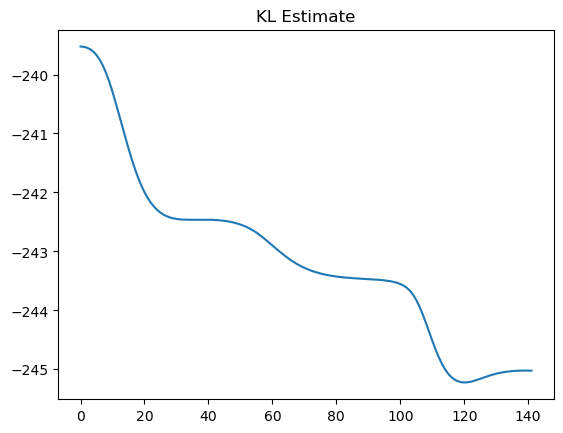

In [40]:
wass_kl_df = pd.DataFrame(np.array(KL_all))
plt.figure()
wass_kl_df.plot(title = 'KL Estimate', legend = False)

In [56]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

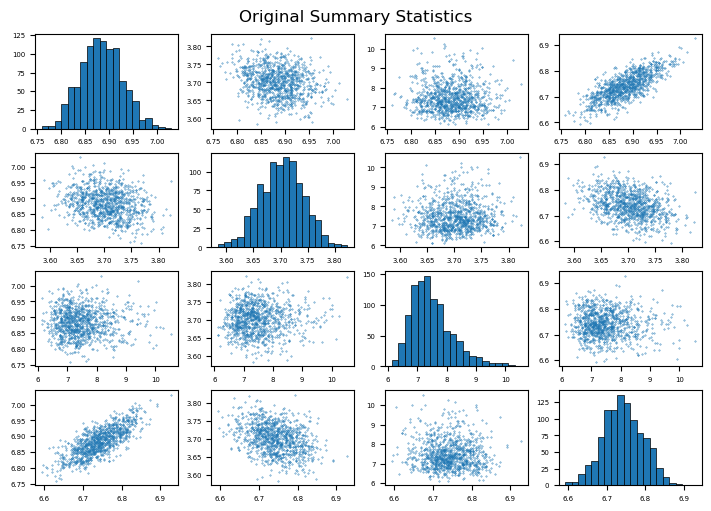

In [42]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


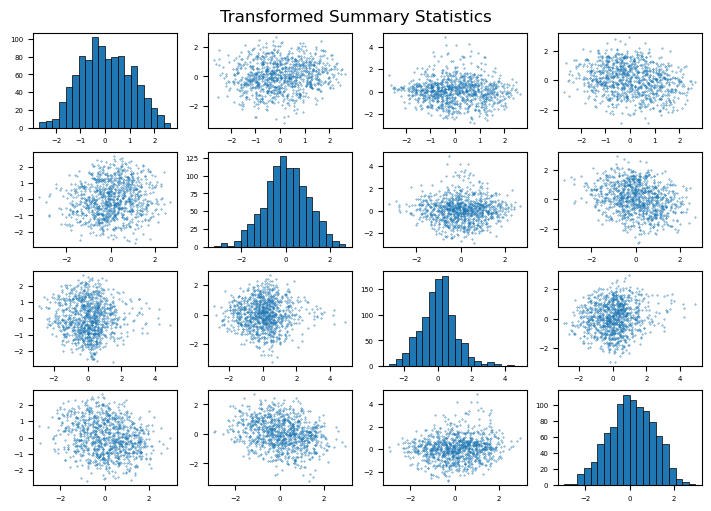

In [43]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [44]:
# Save original data
np.save('toad_original_with_tau.npy', val_n_summary_statistics)
np.save('toad_transformed_with_tau.npy', wass_val_n_summary_statistics)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [57]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

In [58]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = nf_transform(n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

def unbiased_log_likelihood(theta, actual_summary_statistics):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [59]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = ss_multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = ss_multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0, self.actual_summary_statistics) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = ss_multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q, self.actual_summary_statistics) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [48]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[6.85646198, 3.62304683, 7.24713049, 6.67456139, 3.84229264,
        7.22622446, 6.64509097, 3.94446834, 7.26402554, 6.54965074,
        3.99137271, 7.26218951]])

In [60]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = nf_transform(actual_summary_statistics)
transformed_summary_statistics[0]

array([-0.59921995, -0.92719741, -0.72557266, -1.59602161, -1.69453842,
       -0.16618047,  0.70586443, -0.87634806, -0.24280664,  0.70867779,
        0.51675092, -0.11862727])

In [61]:
nn_vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda = nn_vb.vb_posterior(stop)

  0%|          | 1/5000 [12:59<1082:41:47, 779.70s/it]

LB -1613.860610958925


  0%|          | 2/5000 [31:36<1357:35:46, 977.86s/it]

LB -1658.4497675326688


  0%|          | 3/5000 [49:27<1416:20:45, 1020.38s/it]

LB -1670.447727254533


  0%|          | 4/5000 [1:07:29<1450:05:20, 1044.90s/it]

LB -1671.399594670349


  0%|          | 5/5000 [1:25:46<1475:54:13, 1063.71s/it]

LB -1606.6443543258054


  0%|          | 6/5000 [1:44:14<1496:28:20, 1078.75s/it]

LB -1569.8038400298108


  0%|          | 7/5000 [2:02:10<1494:59:22, 1077.90s/it]

LB -1495.6665629341192


  0%|          | 8/5000 [2:20:28<1503:16:26, 1084.09s/it]

LB -1524.7074995633582


  0%|          | 9/5000 [2:39:08<1518:38:38, 1095.40s/it]

LB -1570.4375047140024


  0%|          | 10/5000 [2:58:12<1539:11:44, 1110.44s/it]

LB -1578.9046417493344


  0%|          | 11/5000 [3:17:53<1568:44:08, 1131.98s/it]

LB -1542.613885756291


  0%|          | 12/5000 [3:39:10<1629:34:36, 1176.12s/it]

LB -1556.2909374615651


  0%|          | 13/5000 [4:00:33<1674:06:01, 1208.49s/it]

LB -1553.4511807976285


  0%|          | 14/5000 [4:21:47<1701:10:11, 1228.28s/it]

LB -1543.8730865044188


  0%|          | 15/5000 [4:40:25<1654:42:53, 1194.98s/it]

LB -1492.5397580145095


  0%|          | 16/5000 [4:58:53<1618:08:22, 1168.80s/it]

LB -1527.8629436625158


  0%|          | 17/5000 [5:17:15<1590:06:00, 1148.78s/it]

LB -1562.9707087241995


  0%|          | 18/5000 [5:36:02<1580:46:36, 1142.27s/it]

LB -1505.401420929434


  0%|          | 19/5000 [5:54:26<1564:34:28, 1130.79s/it]

LB -1532.352462307607


  0%|          | 20/5000 [6:12:58<1556:11:01, 1124.95s/it]

LB -1464.8317390130985


  0%|          | 21/5000 [6:31:34<1552:20:48, 1122.40s/it]

LB -1496.5386739447108


  0%|          | 22/5000 [6:50:36<1560:12:08, 1128.31s/it]

LB -1577.4491113887384


  0%|          | 23/5000 [7:09:59<1574:21:00, 1138.77s/it]

LB -1435.4021597897954


  0%|          | 24/5000 [7:29:38<1590:28:21, 1150.66s/it]

LB -1438.5278986340306


  0%|          | 25/5000 [7:49:01<1595:28:59, 1154.52s/it]

LB -1380.0746406085643


  1%|          | 26/5000 [8:08:27<1599:47:07, 1157.87s/it]

LB -1430.7010291466315


  1%|          | 27/5000 [8:27:48<1600:37:31, 1158.71s/it]

LB -1439.5209569254314


  1%|          | 28/5000 [8:48:02<1623:32:26, 1175.53s/it]

LB -1505.27286329866


  1%|          | 29/5000 [9:07:23<1616:51:27, 1170.93s/it]

LB -1475.6695739076995


  1%|          | 30/5000 [9:26:57<1618:07:15, 1172.08s/it]

LB -1452.6124238732327


  1%|          | 31/5000 [9:46:37<1621:02:46, 1174.43s/it]

LB -1445.477223240739


  1%|          | 32/5000 [10:06:00<1615:55:20, 1170.96s/it]

LB -1514.3151090302372


  1%|          | 33/5000 [10:25:16<1609:16:00, 1166.37s/it]

LB -1379.7245913231775


  1%|          | 34/5000 [10:44:37<1607:00:35, 1164.97s/it]

LB -1402.3581287261363


  1%|          | 35/5000 [11:03:50<1601:34:25, 1161.26s/it]

LB -1351.189857682504


  1%|          | 36/5000 [11:23:12<1601:39:18, 1161.55s/it]

LB -1346.9548789320352


  1%|          | 37/5000 [11:43:00<1612:02:59, 1169.33s/it]

LB -1417.7356427210873


  1%|          | 38/5000 [12:02:22<1608:41:45, 1167.13s/it]

LB -1369.2848308506468


  1%|          | 39/5000 [12:21:26<1598:58:57, 1160.32s/it]

LB -1346.9076803544476


  1%|          | 40/5000 [12:40:38<1595:01:23, 1157.68s/it]

LB -1383.6932508958491


  1%|          | 41/5000 [12:59:46<1590:54:29, 1154.92s/it]

LB -1330.1209901966856


  1%|          | 42/5000 [13:19:05<1591:59:34, 1155.94s/it]

LB -1349.804827529153


  1%|          | 43/5000 [13:38:45<1601:43:00, 1163.24s/it]

LB -1384.075199067943


  1%|          | 44/5000 [13:58:25<1608:28:42, 1168.39s/it]

LB -1396.4652900154342


  1%|          | 45/5000 [14:17:28<1597:40:18, 1160.77s/it]

LB -1333.8570302081016


  1%|          | 46/5000 [14:36:52<1598:28:50, 1161.59s/it]

LB -1326.3186843610217


  1%|          | 47/5000 [14:56:55<1615:29:36, 1174.19s/it]

LB -1371.1431799870863


  1%|          | 48/5000 [15:16:12<1607:56:15, 1168.94s/it]

LB -1336.953929519611


  1%|          | 49/5000 [15:35:32<1603:54:05, 1166.24s/it]

LB -1318.4055058881995


  1%|          | 50/5000 [15:54:48<1599:22:44, 1163.18s/it]

LB -1313.257043074059


  1%|          | 51/5000 [16:14:05<1596:33:01, 1161.36s/it]

LB Smoothed -1462.8257514503448


  1%|          | 52/5000 [16:33:35<1599:57:21, 1164.07s/it]

LB Smoothed -1456.032443859719


  1%|          | 53/5000 [16:53:01<1600:07:56, 1164.44s/it]

LB Smoothed -1448.5173462281925


  1%|          | 54/5000 [17:12:24<1599:24:05, 1164.14s/it]

LB Smoothed -1440.7748119811508


  1%|          | 55/5000 [17:31:48<1598:59:57, 1164.08s/it]

LB Smoothed -1434.0669639273613


  1%|          | 56/5000 [17:51:57<1617:10:44, 1177.56s/it]

LB Smoothed -1429.8530378085723


  1%|          | 57/5000 [18:11:20<1610:48:10, 1173.15s/it]

LB Smoothed -1425.769547875055


  1%|          | 58/5000 [18:31:40<1629:49:03, 1187.24s/it]

LB Smoothed -1420.7895147802171


  1%|          | 59/5000 [18:50:51<1614:19:30, 1176.19s/it]

LB Smoothed -1415.3452328950393


  1%|          | 60/5000 [19:09:47<1597:34:22, 1164.22s/it]

LB Smoothed -1408.662044317522


  1%|          | 61/5000 [19:29:25<1602:56:46, 1168.38s/it]

LB Smoothed -1402.8914900345217


  1%|          | 62/5000 [19:49:54<1627:27:56, 1186.49s/it]

LB Smoothed -1397.8265831296903


  1%|▏         | 63/5000 [20:11:03<1661:15:00, 1211.36s/it]

LB Smoothed -1392.6410961971358


  1%|▏         | 64/5000 [20:30:12<1635:04:21, 1192.52s/it]

LB Smoothed -1387.4777985732608


  1%|▏         | 65/5000 [20:50:15<1639:02:59, 1195.66s/it]

LB Smoothed -1381.8809719012836


  1%|▏         | 66/5000 [21:12:43<1701:27:26, 1241.44s/it]

LB Smoothed -1377.1720959973095


  1%|▏         | 67/5000 [21:32:54<1688:33:59, 1232.28s/it]

LB Smoothed -1370.2915526616919


  1%|▏         | 68/5000 [21:53:09<1681:06:22, 1227.08s/it]

LB Smoothed -1365.557103270029


  1%|▏         | 69/5000 [22:13:19<1673:45:54, 1221.97s/it]

LB Smoothed -1359.5002885242955


  1%|▏         | 70/5000 [22:33:26<1667:24:20, 1217.58s/it]

LB Smoothed -1354.2653976597726


  1%|▏         | 71/5000 [22:53:28<1660:30:59, 1212.79s/it]

LB Smoothed -1348.4027144259537


  1%|▏         | 72/5000 [23:13:18<1651:00:26, 1206.09s/it]

LB Smoothed -1341.9632059927383


  1%|▏         | 73/5000 [23:33:11<1645:14:24, 1202.12s/it]

LB Smoothed -1338.2100475604561


  1%|▏         | 74/5000 [23:53:06<1641:54:26, 1199.93s/it]

LB Smoothed -1334.2747841112991


  2%|▏         | 75/5000 [24:12:55<1637:04:53, 1196.65s/it]

LB Smoothed -1331.8522031371442


  2%|▏         | 76/5000 [24:32:56<1638:24:33, 1197.86s/it]

LB Smoothed -1326.5774184932077


  2%|▏         | 77/5000 [24:55:51<1710:49:58, 1251.07s/it]

LB Smoothed -1321.9064879427876


  2%|▏         | 78/5000 [25:16:19<1701:19:41, 1244.37s/it]

LB Smoothed -1315.6382712209227


  2%|▏         | 79/5000 [25:36:22<1683:41:48, 1231.72s/it]

LB Smoothed -1309.1061748216116


  2%|▏         | 80/5000 [25:56:17<1668:18:53, 1220.72s/it]

LB Smoothed -1303.846422768504


  2%|▏         | 81/5000 [26:16:13<1657:55:04, 1213.36s/it]

LB Smoothed -1299.3218711221289


  2%|▏         | 82/5000 [26:36:22<1655:48:18, 1212.06s/it]

LB Smoothed -1293.057433400726


  2%|▏         | 83/5000 [26:56:39<1657:34:35, 1213.60s/it]

LB Smoothed -1288.414877095056


  2%|▏         | 84/5000 [27:19:45<1727:40:18, 1265.18s/it]

LB Smoothed -1284.6536611961233


  2%|▏         | 85/5000 [27:41:41<1748:24:21, 1280.62s/it]

LB Smoothed -1281.1728612398026


  2%|▏         | 86/5000 [28:03:30<1759:28:21, 1288.99s/it]

LB Smoothed -1277.8325695854114


  2%|▏         | 87/5000 [28:26:25<1794:22:00, 1314.82s/it]

LB Smoothed -1273.9967175388829


  2%|▏         | 88/5000 [28:49:46<1829:09:14, 1340.59s/it]

LB Smoothed -1270.2836595599042


  2%|▏         | 89/5000 [29:10:20<1785:26:43, 1308.82s/it]

LB Smoothed -1267.000321430036


  2%|▏         | 90/5000 [29:30:56<1755:06:22, 1286.84s/it]

LB Smoothed -1262.4856603393434


  2%|▏         | 91/5000 [29:51:15<1727:09:28, 1266.61s/it]

LB Smoothed -1259.9466299870462


  2%|▏         | 92/5000 [30:11:19<1701:01:33, 1247.70s/it]

LB Smoothed -1256.427976318025


  2%|▏         | 93/5000 [30:31:09<1677:15:44, 1230.52s/it]

LB Smoothed -1251.788374632752


  2%|▏         | 94/5000 [30:51:14<1666:20:43, 1222.76s/it]

LB Smoothed -1247.7421099631829


  2%|▏         | 95/5000 [31:11:12<1655:46:19, 1215.25s/it]

LB Smoothed -1244.6804552663848


  2%|▏         | 96/5000 [31:31:24<1654:03:08, 1214.23s/it]

LB Smoothed -1241.2782526048238


  2%|▏         | 97/5000 [31:52:14<1668:39:57, 1225.21s/it]

LB Smoothed -1237.0848871295352


  2%|▏         | 98/5000 [32:13:14<1682:24:25, 1235.55s/it]

LB Smoothed -1233.64591721856


  2%|▏         | 99/5000 [32:33:07<1664:43:09, 1222.81s/it]

LB Smoothed -1229.8722322088804


  2%|▏         | 100/5000 [32:52:57<1650:52:58, 1212.89s/it]

LB Smoothed -1225.8707702780102


  2%|▏         | 101/5000 [33:12:59<1645:57:08, 1209.52s/it]

LB Smoothed -1221.8567995936105


  2%|▏         | 102/5000 [33:34:03<1668:10:06, 1226.09s/it]

LB Smoothed -1218.7041421514639


  2%|▏         | 103/5000 [33:54:02<1656:46:42, 1217.97s/it]

LB Smoothed -1215.7932268477132


  2%|▏         | 104/5000 [34:13:58<1647:31:09, 1211.41s/it]

LB Smoothed -1213.5300681865076


  2%|▏         | 105/5000 [34:33:37<1633:51:30, 1201.61s/it]

LB Smoothed -1208.4193272794707


  2%|▏         | 106/5000 [34:53:43<1635:22:54, 1202.98s/it]

LB Smoothed -1204.5083185480803


  2%|▏         | 107/5000 [35:13:27<1627:13:36, 1197.22s/it]

LB Smoothed -1200.9772851393643


  2%|▏         | 108/5000 [35:33:31<1629:30:09, 1199.14s/it]

LB Smoothed -1197.1504179574654


  2%|▏         | 109/5000 [35:53:24<1626:43:25, 1197.34s/it]

LB Smoothed -1194.8967947279516


  2%|▏         | 110/5000 [36:13:01<1617:57:27, 1191.13s/it]

LB Smoothed -1192.4721265084786


  2%|▏         | 111/5000 [36:32:55<1618:53:23, 1192.06s/it]

LB Smoothed -1189.2860793685625


  2%|▏         | 112/5000 [36:52:36<1614:15:05, 1188.89s/it]

LB Smoothed -1185.830630119121


  2%|▏         | 113/5000 [37:12:30<1615:47:48, 1190.27s/it]

LB Smoothed -1183.0958843860312


  2%|▏         | 114/5000 [37:32:12<1612:13:53, 1187.89s/it]

LB Smoothed -1181.3751300231977


  2%|▏         | 115/5000 [37:51:51<1608:12:14, 1185.17s/it]

LB Smoothed -1178.0937298758356


  2%|▏         | 116/5000 [38:11:21<1601:39:04, 1180.58s/it]

LB Smoothed -1176.3396803590902


  2%|▏         | 117/5000 [38:30:53<1597:44:10, 1177.93s/it]

LB Smoothed -1172.8295928658492


  2%|▏         | 118/5000 [38:50:15<1591:05:04, 1173.27s/it]

LB Smoothed -1170.3292292302879


  2%|▏         | 119/5000 [39:09:26<1581:32:33, 1166.47s/it]

LB Smoothed -1169.2753623938113


  2%|▏         | 120/5000 [39:29:53<1605:51:16, 1184.65s/it]

LB Smoothed -1168.6108321436668


  2%|▏         | 121/5000 [39:49:04<1591:53:58, 1174.59s/it]

LB Smoothed -1166.0373123380768


  2%|▏         | 122/5000 [40:08:16<1582:39:48, 1168.02s/it]

LB Smoothed -1163.3283614476336


  2%|▏         | 123/5000 [40:27:25<1574:38:10, 1162.33s/it]

LB Smoothed -1160.223483602185


  2%|▏         | 124/5000 [40:46:36<1569:40:25, 1158.91s/it]

LB Smoothed -1157.1086274202398


  2%|▎         | 125/5000 [41:05:56<1569:37:18, 1159.11s/it]

LB Smoothed -1155.382227248068


  3%|▎         | 126/5000 [41:25:10<1567:09:43, 1157.53s/it]

LB Smoothed -1152.1697372418694


  3%|▎         | 127/5000 [41:44:38<1571:20:56, 1160.86s/it]

LB Smoothed -1149.9837806997791


  3%|▎         | 128/5000 [42:04:36<1585:57:52, 1171.90s/it]

LB Smoothed -1149.2874392976446


  3%|▎         | 129/5000 [42:25:25<1616:47:46, 1194.92s/it]

LB Smoothed -1147.7561671625567


  3%|▎         | 130/5000 [42:44:44<1602:11:40, 1184.37s/it]

LB Smoothed -1145.669800683502


  3%|▎         | 131/5000 [43:05:05<1616:29:26, 1195.19s/it]

LB Smoothed -1143.5964751920103


  3%|▎         | 132/5000 [43:24:58<1615:28:35, 1194.68s/it]

LB Smoothed -1142.46738098744


  3%|▎         | 133/5000 [43:44:21<1602:15:43, 1185.15s/it]

LB Smoothed -1139.2663974790516


  3%|▎         | 134/5000 [44:04:24<1609:12:57, 1190.54s/it]

LB Smoothed -1138.1083967314512


  3%|▎         | 135/5000 [44:24:54<1624:37:56, 1202.19s/it]

LB Smoothed -1135.8160365849817


  3%|▎         | 136/5000 [44:46:36<1664:52:35, 1232.23s/it]

LB Smoothed -1132.5669072176297


  3%|▎         | 137/5000 [45:08:59<1709:14:18, 1265.32s/it]

LB Smoothed -1130.7572893563822


  3%|▎         | 138/5000 [45:31:39<1747:18:49, 1293.77s/it]

LB Smoothed -1128.7459120009084


  3%|▎         | 139/5000 [45:55:24<1800:14:25, 1333.24s/it]

LB Smoothed -1127.372998165611


  3%|▎         | 140/5000 [46:16:35<1774:44:40, 1314.63s/it]

LB Smoothed -1124.4747420207318


  3%|▎         | 141/5000 [46:37:36<1752:37:58, 1298.51s/it]

LB Smoothed -1122.6672514264485


  3%|▎         | 142/5000 [46:58:31<1734:36:12, 1285.42s/it]

LB Smoothed -1120.8020745924284


  3%|▎         | 143/5000 [47:19:31<1723:43:18, 1277.62s/it]

LB Smoothed -1118.0986356050544


  3%|▎         | 144/5000 [47:40:13<1709:18:12, 1267.19s/it]

LB Smoothed -1115.6558122282036


  3%|▎         | 145/5000 [48:01:11<1704:54:09, 1264.19s/it]

LB Smoothed -1113.4875906261138


  3%|▎         | 146/5000 [48:22:04<1700:17:02, 1261.03s/it]

LB Smoothed -1111.499193693087


  3%|▎         | 147/5000 [48:42:58<1697:00:41, 1258.86s/it]

LB Smoothed -1109.517476068485


  3%|▎         | 148/5000 [49:03:50<1693:51:32, 1256.78s/it]

LB Smoothed -1108.0040448855186


  3%|▎         | 149/5000 [49:24:40<1690:36:28, 1254.63s/it]

LB Smoothed -1106.838703022432


  3%|▎         | 150/5000 [49:46:01<1700:57:50, 1262.57s/it]

LB Smoothed -1105.6639343376853


  3%|▎         | 151/5000 [50:06:52<1695:54:26, 1259.08s/it]

LB Smoothed -1104.1598631823801


  3%|▎         | 152/5000 [50:27:32<1688:09:01, 1253.58s/it]

LB Smoothed -1102.2171271308644


  3%|▎         | 153/5000 [50:49:46<1719:59:47, 1277.49s/it]

LB Smoothed -1100.0336624575957


  3%|▎         | 154/5000 [51:13:02<1767:38:42, 1313.15s/it]

LB Smoothed -1099.0341535401558


  3%|▎         | 155/5000 [51:35:07<1772:02:53, 1316.69s/it]

LB Smoothed -1098.0265386516073


  3%|▎         | 156/5000 [51:56:47<1764:53:47, 1311.65s/it]

LB Smoothed -1096.9429830294575


  3%|▎         | 157/5000 [52:17:56<1747:16:17, 1298.82s/it]

LB Smoothed -1096.7898815011217


  3%|▎         | 158/5000 [52:41:15<1787:19:46, 1328.87s/it]

LB Smoothed -1095.5724568462927


  3%|▎         | 159/5000 [53:02:35<1767:30:39, 1314.41s/it]

LB Smoothed -1093.5984434511538


  3%|▎         | 160/5000 [53:23:57<1753:56:55, 1304.59s/it]

LB Smoothed -1091.5216409640675


  3%|▎         | 161/5000 [53:45:22<1745:37:08, 1298.66s/it]

LB Smoothed -1090.3856554587417


  3%|▎         | 162/5000 [54:07:11<1749:28:40, 1301.80s/it]

LB Smoothed -1087.9498541284413


  3%|▎         | 163/5000 [54:27:03<1704:40:34, 1268.73s/it]

LB Smoothed -1086.1791781737124


  3%|▎         | 164/5000 [54:48:29<1711:36:45, 1274.15s/it]

LB Smoothed -1084.0240019620283


  3%|▎         | 165/5000 [55:07:21<1653:53:27, 1231.44s/it]

LB Smoothed -1082.1280194809208


  3%|▎         | 166/5000 [55:27:33<1645:35:07, 1225.51s/it]

LB Smoothed -1080.7094646161354


  3%|▎         | 167/5000 [55:50:32<1707:07:01, 1271.60s/it]

LB Smoothed -1079.4485886507568


  3%|▎         | 168/5000 [56:09:54<1662:38:43, 1238.73s/it]

LB Smoothed -1077.3197161275284


  3%|▎         | 169/5000 [56:28:25<1610:55:04, 1200.44s/it]

LB Smoothed -1074.8048867308617


  3%|▎         | 170/5000 [56:53:02<1721:43:44, 1283.28s/it]

LB Smoothed -1072.6328270287468


  3%|▎         | 171/5000 [57:19:29<1843:53:42, 1374.62s/it]

LB Smoothed -1070.953205103881


  3%|▎         | 172/5000 [57:36:10<1692:55:29, 1262.33s/it]

LB Smoothed -1069.9487075214493


  3%|▎         | 173/5000 [57:55:42<1656:24:21, 1235.36s/it]

LB Smoothed -1067.9482751701532


  3%|▎         | 174/5000 [58:14:54<1622:20:00, 1210.19s/it]

LB Smoothed -1066.3389800026325


  4%|▎         | 175/5000 [58:34:13<1601:43:07, 1195.06s/it]

LB Smoothed -1065.8260622908815


  4%|▎         | 176/5000 [58:53:39<1589:40:05, 1186.32s/it]

LB Smoothed -1064.671659786343


  4%|▎         | 177/5000 [59:13:05<1581:08:44, 1180.20s/it]

LB Smoothed -1062.394260466654


  4%|▎         | 178/5000 [59:32:54<1584:24:27, 1182.88s/it]

LB Smoothed -1060.3126758018207


  4%|▎         | 179/5000 [59:52:19<1576:35:40, 1177.30s/it]

LB Smoothed -1058.445089771672


  4%|▎         | 180/5000 [60:11:50<1573:58:36, 1175.58s/it]

LB Smoothed -1056.7447752629482


  4%|▎         | 181/5000 [60:31:20<1571:27:54, 1173.95s/it]

LB Smoothed -1055.294282873876


  4%|▎         | 182/5000 [60:50:55<1571:26:20, 1174.18s/it]

LB Smoothed -1054.4851200361588


  4%|▎         | 183/5000 [61:09:57<1558:20:11, 1164.63s/it]

LB Smoothed -1052.175346081731


  4%|▎         | 184/5000 [61:29:32<1561:55:31, 1167.55s/it]

LB Smoothed -1050.6824921192542


  4%|▎         | 185/5000 [61:49:36<1576:13:13, 1178.48s/it]

LB Smoothed -1049.6522743276157


  4%|▎         | 186/5000 [62:09:08<1573:26:46, 1176.65s/it]

LB Smoothed -1048.7461039815994


  4%|▎         | 187/5000 [62:28:27<1566:09:29, 1171.45s/it]

LB Smoothed -1047.009334968525


  4%|▍         | 188/5000 [62:47:49<1561:56:37, 1168.54s/it]

LB Smoothed -1045.4301663527133


  4%|▍         | 189/5000 [63:06:55<1552:34:41, 1161.77s/it]

LB Smoothed -1044.0587805188177


  4%|▍         | 190/5000 [63:26:19<1553:05:17, 1162.39s/it]

LB Smoothed -1043.333038947146


  4%|▍         | 191/5000 [63:45:29<1547:57:21, 1158.79s/it]

LB Smoothed -1041.535457527801


  4%|▍         | 192/5000 [64:05:25<1562:22:25, 1169.83s/it]

LB Smoothed -1040.2898356256674


  4%|▍         | 193/5000 [64:24:40<1556:00:49, 1165.31s/it]

LB Smoothed -1038.9935145842342


  4%|▍         | 194/5000 [64:44:03<1554:57:32, 1164.76s/it]

LB Smoothed -1037.928795492609


  4%|▍         | 195/5000 [65:04:56<1590:00:04, 1191.26s/it]

LB Smoothed -1036.6246035603722


  4%|▍         | 196/5000 [65:24:52<1591:30:26, 1192.64s/it]

LB Smoothed -1035.5083204756563


  4%|▍         | 197/5000 [65:44:29<1584:49:45, 1187.88s/it]

LB Smoothed -1034.085734318356


  4%|▍         | 198/5000 [67:15:25<3292:23:02, 2468.26s/it]

LB Smoothed -1032.3013629432332


  4%|▍         | 199/5000 [67:34:02<2751:15:55, 2063.02s/it]

LB Smoothed -1030.6503334000747


  4%|▍         | 200/5000 [67:52:00<2356:40:30, 1767.51s/it]

LB Smoothed -1028.4542205366881


  4%|▍         | 201/5000 [68:08:32<2046:04:39, 1534.88s/it]

LB Smoothed -1027.7933948859588


  4%|▍         | 202/5000 [68:25:05<1828:43:35, 1372.12s/it]

LB Smoothed -1026.4864319941933


  4%|▍         | 203/5000 [73:37:56<8783:43:02, 6591.91s/it]

LB Smoothed -1025.5748356158606


  4%|▍         | 204/5000 [73:58:29<6640:02:46, 4984.19s/it]

LB Smoothed -1024.4492233992955


  4%|▍         | 205/5000 [74:19:17<5145:53:16, 3863.44s/it]

LB Smoothed -1023.0131902869352


  4%|▍         | 206/5000 [74:38:23<4059:05:01, 3048.12s/it]

LB Smoothed -1020.3345942257204


  4%|▍         | 207/5000 [74:56:29<3274:27:13, 2459.43s/it]

LB Smoothed -1018.5403766935676


  4%|▍         | 208/5000 [75:14:19<2719:08:17, 2042.76s/it]

LB Smoothed -1017.1521082102408


  4%|▍         | 209/5000 [75:32:56<2348:44:52, 1764.87s/it]

LB Smoothed -1016.1086923783918


  4%|▍         | 210/5000 [75:53:45<2142:21:29, 1610.12s/it]

LB Smoothed -1013.9743176021283


  4%|▍         | 211/5000 [76:12:25<1946:13:37, 1463.02s/it]

LB Smoothed -1013.0039047635762


  4%|▍         | 212/5000 [76:35:47<1921:34:43, 1444.80s/it]

LB Smoothed -1011.5542375520433


  4%|▍         | 213/5000 [77:05:40<2059:58:19, 1549.17s/it]

LB Smoothed -1010.7086482933125


  4%|▍         | 214/5000 [77:26:14<1934:08:32, 1454.85s/it]

LB Smoothed -1008.7253991663141


  4%|▍         | 215/5000 [77:47:02<1850:59:05, 1392.59s/it]

LB Smoothed -1007.6902733699134


  4%|▍         | 216/5000 [78:07:50<1793:14:08, 1349.42s/it]

LB Smoothed -1005.4042468673923


  4%|▍         | 217/5000 [78:24:37<1656:03:49, 1246.46s/it]

LB Smoothed -1003.3909199119573


  4%|▍         | 218/5000 [78:41:27<1561:41:06, 1175.67s/it]

LB Smoothed -1001.56482438032


  4%|▍         | 219/5000 [79:00:37<1551:10:28, 1168.00s/it]

LB Smoothed -1000.7867173095538


  4%|▍         | 220/5000 [79:20:04<1550:25:56, 1167.69s/it]

LB Smoothed -999.1412397439965


  4%|▍         | 221/5000 [79:41:41<1601:24:25, 1206.33s/it]

LB Smoothed -997.3654042527452


  4%|▍         | 222/5000 [80:03:38<1645:13:57, 1239.61s/it]

LB Smoothed -996.3941110957335


  4%|▍         | 223/5000 [80:25:39<1677:16:14, 1264.01s/it]

LB Smoothed -995.5783947772904


  4%|▍         | 224/5000 [80:47:25<1693:40:59, 1276.65s/it]

LB Smoothed -993.7397371924186


  4%|▍         | 225/5000 [81:09:43<1717:48:21, 1295.10s/it]

LB Smoothed -992.3946442645102


  5%|▍         | 226/5000 [81:31:39<1725:30:44, 1301.18s/it]

LB Smoothed -990.8022019535132


  5%|▍         | 227/5000 [81:54:05<1743:00:32, 1314.65s/it]

LB Smoothed -988.8089733920117


  5%|▍         | 228/5000 [82:16:41<1759:14:39, 1327.18s/it]

LB Smoothed -986.5512564592283


  5%|▍         | 229/5000 [82:38:34<1753:25:44, 1323.07s/it]

LB Smoothed -985.1995903257164


  5%|▍         | 230/5000 [83:00:17<1744:42:34, 1316.76s/it]

LB Smoothed -983.063185486117


  5%|▍         | 231/5000 [83:22:12<1743:59:55, 1316.50s/it]

LB Smoothed -982.2511274607206


  5%|▍         | 232/5000 [83:44:22<1748:48:16, 1320.41s/it]

LB Smoothed -981.5448340207251


  5%|▍         | 233/5000 [84:06:01<1740:00:25, 1314.04s/it]

LB Smoothed -980.9310558131028


  5%|▍         | 234/5000 [84:27:42<1734:31:13, 1310.17s/it]

LB Smoothed -979.4951996292081


  5%|▍         | 235/5000 [84:49:23<1730:30:45, 1307.42s/it]

LB Smoothed -977.6876088627799


  5%|▍         | 236/5000 [85:11:10<1729:58:32, 1307.29s/it]

LB Smoothed -976.5695604569473


  5%|▍         | 237/5000 [85:32:45<1724:29:13, 1303.41s/it]

LB Smoothed -975.0273087860259


  5%|▍         | 238/5000 [85:54:41<1729:08:15, 1307.20s/it]

LB Smoothed -974.0693455398572


  5%|▍         | 239/5000 [86:16:12<1722:24:40, 1302.39s/it]

LB Smoothed -971.8243621329486


  5%|▍         | 240/5000 [86:37:42<1717:15:35, 1298.77s/it]

LB Smoothed -971.1586470861696


  5%|▍         | 241/5000 [86:59:08<1711:48:44, 1294.92s/it]

LB Smoothed -969.2500179255547


  5%|▍         | 242/5000 [87:20:33<1707:20:49, 1291.81s/it]

LB Smoothed -967.6590171819598


  5%|▍         | 243/5000 [87:42:36<1719:36:14, 1301.36s/it]

LB Smoothed -966.3094895387229


  5%|▍         | 244/5000 [88:04:56<1734:32:39, 1312.94s/it]

LB Smoothed -964.6455838073514


  5%|▍         | 245/5000 [88:26:32<1727:20:08, 1307.76s/it]

LB Smoothed -962.711603021482


  5%|▍         | 246/5000 [88:47:39<1711:02:14, 1295.70s/it]

LB Smoothed -961.3140420485081


  5%|▍         | 247/5000 [89:10:11<1732:52:41, 1312.51s/it]

LB Smoothed -960.5435950662263


  5%|▍         | 248/5000 [89:31:32<1720:05:43, 1303.10s/it]

LB Smoothed -959.6100323274862


  5%|▍         | 249/5000 [89:53:13<1718:40:02, 1302.29s/it]

LB Smoothed -958.7722759206323


  5%|▌         | 250/5000 [90:14:43<1713:34:30, 1298.71s/it]

LB Smoothed -956.920824773791


  5%|▌         | 251/5000 [90:37:15<1734:08:12, 1314.57s/it]

LB Smoothed -955.9803027932298


  5%|▌         | 252/5000 [90:58:34<1719:44:22, 1303.93s/it]

LB Smoothed -953.7927297236756


  5%|▌         | 253/5000 [91:23:01<1783:57:44, 1352.91s/it]

LB Smoothed -951.9596296877213


  5%|▌         | 254/5000 [91:45:31<1782:16:37, 1351.92s/it]

LB Smoothed -950.4803490890642


  5%|▌         | 255/5000 [92:06:49<1752:45:35, 1329.81s/it]

LB Smoothed -949.1125715209336


  5%|▌         | 256/5000 [92:28:43<1746:23:07, 1325.25s/it]

LB Smoothed -947.0979307168172


  5%|▌         | 257/5000 [92:50:48<1745:45:00, 1325.05s/it]

LB Smoothed -946.4295638060357


  5%|▌         | 258/5000 [93:15:28<1806:38:17, 1371.55s/it]

LB Smoothed -944.7406939592221


  5%|▌         | 259/5000 [93:37:44<1792:19:50, 1360.98s/it]

LB Smoothed -943.5615867261818


  5%|▌         | 260/5000 [94:00:18<1788:57:26, 1358.70s/it]

LB Smoothed -942.034211292336


  5%|▌         | 261/5000 [94:23:56<1812:04:18, 1376.55s/it]

LB Smoothed -940.4035905266784


  5%|▌         | 262/5000 [94:45:56<1789:17:26, 1359.53s/it]

LB Smoothed -938.4592227560178


  5%|▌         | 263/5000 [95:08:10<1778:52:26, 1351.90s/it]

LB Smoothed -937.5901563062203


  5%|▌         | 264/5000 [95:32:07<1812:05:56, 1377.44s/it]

LB Smoothed -937.004294090155


  5%|▌         | 265/5000 [95:54:07<1788:59:21, 1360.16s/it]

LB Smoothed -936.4154661632032


  5%|▌         | 266/5000 [96:15:40<1762:05:05, 1339.99s/it]

LB Smoothed -935.2186180405295


  5%|▌         | 267/5000 [96:36:50<1734:04:26, 1318.97s/it]

LB Smoothed -933.9314898007374


  5%|▌         | 268/5000 [96:57:16<1697:07:51, 1291.14s/it]

LB Smoothed -932.0185315489477


  5%|▌         | 269/5000 [97:16:59<1654:24:18, 1258.90s/it]

LB Smoothed -930.9528798973271


  5%|▌         | 270/5000 [97:37:56<1652:58:16, 1258.08s/it]

LB Smoothed -929.8632721020946


  5%|▌         | 271/5000 [98:00:05<1680:46:43, 1279.51s/it]

LB Smoothed -928.2887886880626


  5%|▌         | 272/5000 [98:21:30<1682:38:47, 1281.20s/it]

LB Smoothed -927.0298631820177


  5%|▌         | 273/5000 [98:43:52<1706:17:46, 1299.49s/it]

LB Smoothed -925.8055067666679


  5%|▌         | 274/5000 [99:06:18<1724:05:07, 1313.31s/it]

LB Smoothed -924.4040493033744


  6%|▌         | 275/5000 [99:28:59<1742:41:46, 1327.77s/it]

LB Smoothed -923.496127374214


  6%|▌         | 276/5000 [99:51:27<1750:08:58, 1333.73s/it]

LB Smoothed -922.7569598343961


  6%|▌         | 277/5000 [100:12:40<1725:48:24, 1315.46s/it]

LB Smoothed -921.591927043367


  6%|▌         | 278/5000 [100:35:38<1749:58:23, 1334.16s/it]

LB Smoothed -920.2701886130641


  6%|▌         | 279/5000 [100:55:44<1699:05:13, 1295.64s/it]

LB Smoothed -919.7491482351679


  6%|▌         | 280/5000 [101:17:29<1702:25:47, 1298.46s/it]

LB Smoothed -917.7534272538425


  6%|▌         | 281/5000 [101:40:04<1724:29:44, 1315.57s/it]

LB Smoothed -916.0899261025854


  6%|▌         | 282/5000 [101:59:04<1654:59:50, 1262.82s/it]

LB Smoothed -914.4383404866113


  6%|▌         | 283/5000 [102:15:38<1549:14:53, 1182.38s/it]

LB Smoothed -913.103676226031


  6%|▌         | 284/5000 [102:36:14<1569:38:38, 1198.20s/it]

LB Smoothed -911.4070777350012


  6%|▌         | 285/5000 [102:53:26<1504:08:40, 1148.45s/it]

LB Smoothed -910.2683837041545


  6%|▌         | 286/5000 [103:11:14<1472:20:17, 1124.40s/it]

LB Smoothed -908.744124902774


  6%|▌         | 287/5000 [103:29:04<1450:34:07, 1108.01s/it]

LB Smoothed -906.7442894682445


  6%|▌         | 288/5000 [103:46:52<1434:39:07, 1096.08s/it]

LB Smoothed -905.1445618484635


  6%|▌         | 289/5000 [104:04:50<1427:05:32, 1090.54s/it]

LB Smoothed -903.6077898774425


  6%|▌         | 290/5000 [104:22:58<1425:43:58, 1089.73s/it]

LB Smoothed -902.75505289869


  6%|▌         | 291/5000 [104:40:58<1421:53:40, 1087.03s/it]

LB Smoothed -901.9205640080759


  6%|▌         | 292/5000 [104:59:04<1420:57:10, 1086.54s/it]

LB Smoothed -901.1101812483618


  6%|▌         | 293/5000 [105:17:18<1423:37:21, 1088.81s/it]

LB Smoothed -900.2162441574892


  6%|▌         | 294/5000 [105:35:30<1424:45:54, 1089.92s/it]

LB Smoothed -899.1745654013235


  6%|▌         | 295/5000 [105:53:44<1425:43:23, 1090.88s/it]

LB Smoothed -898.228007208879


  6%|▌         | 296/5000 [106:11:56<1425:52:17, 1091.23s/it]

LB Smoothed -896.6509514193318


  6%|▌         | 297/5000 [106:30:48<1441:43:21, 1103.59s/it]

LB Smoothed -894.9575811631953


  6%|▌         | 298/5000 [106:49:00<1437:01:20, 1100.23s/it]

LB Smoothed -893.8536125977064


  6%|▌         | 299/5000 [107:07:08<1431:50:47, 1096.50s/it]

LB Smoothed -892.702929035715


  6%|▌         | 300/5000 [107:25:23<1430:55:51, 1096.03s/it]

LB Smoothed -891.0912465264207


  6%|▌         | 301/5000 [107:43:56<1437:21:31, 1101.19s/it]

LB Smoothed -889.7161512842151


  6%|▌         | 302/5000 [108:02:08<1433:11:28, 1098.23s/it]

LB Smoothed -889.1765127705089


  6%|▌         | 303/5000 [108:20:15<1428:35:01, 1094.93s/it]

LB Smoothed -887.6082072994585


  6%|▌         | 304/5000 [108:38:19<1423:59:25, 1091.65s/it]

LB Smoothed -886.8018488010755


  6%|▌         | 305/5000 [108:56:19<1419:08:36, 1088.16s/it]

LB Smoothed -886.4565508862514


  6%|▌         | 306/5000 [109:14:20<1416:00:16, 1085.99s/it]

LB Smoothed -884.9686872438702


  6%|▌         | 307/5000 [109:32:37<1420:05:11, 1089.35s/it]

LB Smoothed -883.5867606462693


  6%|▌         | 308/5000 [109:50:01<1402:01:43, 1075.73s/it]

LB Smoothed -882.2590133299926


  6%|▌         | 309/5000 [110:07:24<1388:50:11, 1065.83s/it]

LB Smoothed -880.7753626578419


  6%|▌         | 310/5000 [110:24:50<1381:00:18, 1060.05s/it]

LB Smoothed -880.1434795901466


  6%|▌         | 311/5000 [110:42:12<1373:28:01, 1054.49s/it]

LB Smoothed -879.1028763231296


  6%|▌         | 312/5000 [110:59:30<1366:46:49, 1049.58s/it]

LB Smoothed -877.9716377730971


  6%|▋         | 313/5000 [111:16:46<1361:11:08, 1045.50s/it]

LB Smoothed -875.7847795484689


  6%|▋         | 314/5000 [111:34:20<1364:08:23, 1047.99s/it]

LB Smoothed -874.0555756053769


  6%|▋         | 315/5000 [111:51:28<1356:11:51, 1042.12s/it]

LB Smoothed -873.046172025318


  6%|▋         | 316/5000 [112:08:26<1346:33:23, 1034.93s/it]

LB Smoothed -871.6236914719727


  6%|▋         | 317/5000 [112:25:41<1346:12:02, 1034.88s/it]

LB Smoothed -870.9475479220633


  6%|▋         | 318/5000 [112:43:33<1360:10:59, 1045.85s/it]

LB Smoothed -869.882121392171


  6%|▋         | 319/5000 [113:00:57<1359:30:32, 1045.55s/it]

LB Smoothed -868.1491793054239


  6%|▋         | 320/5000 [113:18:49<1369:25:21, 1053.40s/it]

LB Smoothed -867.0756465499857


  6%|▋         | 321/5000 [113:37:58<1406:19:13, 1082.02s/it]

LB Smoothed -865.8457064491862


  6%|▋         | 322/5000 [113:56:36<1419:55:16, 1092.71s/it]

LB Smoothed -864.94125868119


  6%|▋         | 323/5000 [114:14:32<1413:28:22, 1087.98s/it]

LB Smoothed -863.504731434282


  6%|▋         | 324/5000 [114:33:45<1438:18:41, 1107.34s/it]

LB Smoothed -862.5213713566012


  6%|▋         | 325/5000 [114:52:12<1438:01:14, 1107.35s/it]

LB Smoothed -861.6620242781786


  7%|▋         | 326/5000 [115:10:48<1441:02:54, 1109.92s/it]

LB Smoothed -861.0758459315679


  7%|▋         | 327/5000 [115:29:24<1443:04:52, 1111.73s/it]

LB Smoothed -860.0289599666445


  7%|▋         | 328/5000 [115:48:09<1448:00:28, 1115.76s/it]

LB Smoothed -858.7373325406529


  7%|▋         | 329/5000 [116:07:59<1476:27:58, 1137.93s/it]

LB Smoothed -858.02366497183


  7%|▋         | 330/5000 [116:39:33<1770:23:30, 1364.76s/it]

LB Smoothed -857.0617224489819


  7%|▋         | 331/5000 [117:02:12<1767:34:55, 1362.88s/it]

LB Smoothed -855.7460836034961


  7%|▋         | 332/5000 [117:25:07<1772:06:49, 1366.67s/it]

LB Smoothed -854.6254748103946


  7%|▋         | 333/5000 [117:47:16<1757:01:46, 1355.33s/it]

LB Smoothed -853.3471432007899


  7%|▋         | 334/5000 [118:08:14<1719:01:10, 1326.29s/it]

LB Smoothed -851.6300841367456


  7%|▋         | 335/5000 [118:30:33<1723:31:21, 1330.05s/it]

LB Smoothed -850.9031938303596


  7%|▋         | 336/5000 [118:54:16<1759:14:04, 1357.90s/it]

LB Smoothed -850.5774596155219


  7%|▋         | 337/5000 [119:17:14<1766:40:07, 1363.93s/it]

LB Smoothed -849.7819942370452


  7%|▋         | 338/5000 [119:40:37<1781:25:45, 1375.62s/it]

LB Smoothed -848.4705543075576


  7%|▋         | 339/5000 [120:03:41<1784:26:40, 1378.25s/it]

LB Smoothed -848.003813212623


  7%|▋         | 340/5000 [120:26:45<1785:57:30, 1379.71s/it]

LB Smoothed -846.5466490568184


  7%|▋         | 341/5000 [120:49:44<1785:18:03, 1379.50s/it]

LB Smoothed -844.8492214500798


  7%|▋         | 342/5000 [121:12:51<1788:05:37, 1381.95s/it]

LB Smoothed -843.5457080052075


  7%|▋         | 343/5000 [121:35:40<1782:30:52, 1377.94s/it]

LB Smoothed -842.5529787414646


  7%|▋         | 344/5000 [121:59:09<1794:13:23, 1387.29s/it]

LB Smoothed -841.3486134505395


  7%|▋         | 345/5000 [122:21:53<1784:51:30, 1380.34s/it]

LB Smoothed -840.5383940427449


  7%|▋         | 346/5000 [122:44:58<1786:22:17, 1381.81s/it]

LB Smoothed -839.4180550198724


  7%|▋         | 347/5000 [123:07:59<1785:40:45, 1381.57s/it]

LB Smoothed -838.2398950427876


  7%|▋         | 348/5000 [123:31:01<1785:23:02, 1381.64s/it]

LB Smoothed -837.4790935641615


  7%|▋         | 349/5000 [123:56:20<1838:16:22, 1422.87s/it]

LB Smoothed -836.4831065725142


  7%|▋         | 350/5000 [124:23:32<1918:59:12, 1485.67s/it]

LB Smoothed -836.2520040816518


  7%|▋         | 351/5000 [124:55:16<2080:27:46, 1611.03s/it]

LB Smoothed -834.3939745918615


  7%|▋         | 352/5000 [125:20:42<2047:03:11, 1585.50s/it]

LB Smoothed -834.0236789623381


  7%|▋         | 353/5000 [125:43:15<1956:32:09, 1515.72s/it]

LB Smoothed -833.2263028845455


  7%|▋         | 354/5000 [126:04:39<1866:24:19, 1446.20s/it]

LB Smoothed -832.1728559789045


  7%|▋         | 355/5000 [126:21:09<1689:28:29, 1309.39s/it]

LB Smoothed -831.1568207533724


  7%|▋         | 356/5000 [126:37:16<1556:27:12, 1206.55s/it]

LB Smoothed -830.4958882237773


  7%|▋         | 357/5000 [126:55:33<1513:47:16, 1173.73s/it]

LB Smoothed -829.8001494963812


  7%|▋         | 358/5000 [127:17:55<1578:31:59, 1224.20s/it]

LB Smoothed -829.1711087577


  7%|▋         | 359/5000 [127:43:42<1703:10:09, 1321.14s/it]

LB Smoothed -827.8131247522823


  7%|▋         | 360/5000 [128:08:48<1774:11:39, 1376.53s/it]

LB Smoothed -827.2434222751036


  7%|▋         | 361/5000 [128:32:45<1797:27:37, 1394.88s/it]

LB Smoothed -826.3323280786004


  7%|▋         | 362/5000 [128:57:00<1820:03:47, 1412.73s/it]

LB Smoothed -825.3137516791674


  7%|▋         | 363/5000 [129:20:21<1815:20:49, 1409.37s/it]

LB Smoothed -824.8371143941059


  7%|▋         | 364/5000 [129:49:12<1939:07:42, 1505.79s/it]

LB Smoothed -824.3903237001504


  7%|▋         | 365/5000 [130:09:42<1832:06:18, 1422.99s/it]

LB Smoothed -823.5039375497349


  7%|▋         | 366/5000 [130:28:16<1712:23:20, 1330.30s/it]

LB Smoothed -822.2028528386842


  7%|▋         | 367/5000 [130:48:23<1664:23:03, 1293.28s/it]

LB Smoothed -821.2846003348319


  7%|▋         | 368/5000 [151:51:10<30410:55:10, 23635.43s/it]

LB Smoothed -821.0171459322881


  7%|▋         | 369/5000 [153:35:31<23699:18:47, 18423.13s/it]

LB Smoothed -820.0173796351336


  7%|▋         | 370/5000 [153:54:17<17020:16:16, 13233.90s/it]

LB Smoothed -819.2648553597998


  7%|▋         | 371/5000 [154:11:40<12314:08:10, 9576.77s/it] 

LB Smoothed -818.3355581484986


  7%|▋         | 372/5000 [154:26:41<8965:28:01, 6974.00s/it] 

LB Smoothed -817.518265516713


  7%|▋         | 373/5000 [154:41:51<6625:23:57, 5154.84s/it]

LB Smoothed -816.7657502918989


  7%|▋         | 374/5000 [154:57:06<4989:26:45, 3882.84s/it]

LB Smoothed -815.9373047433695


  8%|▊         | 375/5000 [155:12:14<3841:56:08, 2990.48s/it]

LB Smoothed -814.9365774144381


  8%|▊         | 376/5000 [155:27:24<3039:15:03, 2366.20s/it]

LB Smoothed -813.9680651482107


  8%|▊         | 377/5000 [155:42:30<2476:15:10, 1928.30s/it]

LB Smoothed -813.4372934470947


  8%|▊         | 378/5000 [155:57:38<2082:38:09, 1622.13s/it]

LB Smoothed -812.2217934357418


  8%|▊         | 379/5000 [156:12:42<1805:28:36, 1406.56s/it]

LB Smoothed -810.8179156636494


  8%|▊         | 380/5000 [156:27:42<1610:12:03, 1254.70s/it]

LB Smoothed -810.2626644212506


  8%|▊         | 381/5000 [156:42:48<1475:44:29, 1150.18s/it]

LB Smoothed -809.4366131763842


  8%|▊         | 382/5000 [156:57:49<1379:22:56, 1075.31s/it]

LB Smoothed -808.5746756016806


  8%|▊         | 383/5000 [157:12:57<1314:42:57, 1025.12s/it]

LB Smoothed -808.1023418151343


  8%|▊         | 384/5000 [157:28:06<1269:49:06, 990.33s/it] 

LB Smoothed -807.0573477694596


  8%|▊         | 385/5000 [157:43:20<1240:02:02, 967.31s/it]

LB Smoothed -806.1274857754469


  8%|▊         | 386/5000 [157:58:21<1214:24:13, 947.52s/it]

LB Smoothed -805.2187226501779


  8%|▊         | 387/5000 [158:13:18<1194:32:11, 932.22s/it]

LB Smoothed -804.8040832118112


  8%|▊         | 388/5000 [158:28:15<1180:57:16, 921.82s/it]

LB Smoothed -803.4265016486062


  8%|▊         | 389/5000 [158:43:22<1175:00:55, 917.38s/it]

LB Smoothed -802.8749897770646


  8%|▊         | 390/5000 [158:58:30<1171:10:11, 914.58s/it]

LB Smoothed -802.3620988942125


  8%|▊         | 391/5000 [159:14:03<1178:00:30, 920.12s/it]

LB Smoothed -801.6179605878822


  8%|▊         | 392/5000 [159:29:20<1176:32:26, 919.17s/it]

LB Smoothed -801.0450184670972


  8%|▊         | 393/5000 [159:44:26<1171:10:32, 915.18s/it]

LB Smoothed -800.2883693206845


  8%|▊         | 394/5000 [159:59:33<1167:42:04, 912.66s/it]

LB Smoothed -799.2494781839548


  8%|▊         | 395/5000 [160:14:36<1163:52:38, 909.87s/it]

LB Smoothed -798.4744620327328


  8%|▊         | 396/5000 [160:29:44<1162:58:49, 909.37s/it]

LB Smoothed -797.4825560974267


  8%|▊         | 397/5000 [160:44:53<1162:20:59, 909.07s/it]

LB Smoothed -795.8333240618337


  8%|▊         | 398/5000 [161:00:03<1162:29:37, 909.38s/it]

LB Smoothed -794.8469716731681


  8%|▊         | 399/5000 [161:15:16<1163:46:29, 910.58s/it]

LB Smoothed -793.4079967861771


  8%|▊         | 400/5000 [161:30:29<1164:20:56, 911.23s/it]

LB Smoothed -792.6903650867424


  8%|▊         | 401/5000 [161:45:51<1168:06:55, 914.38s/it]

LB Smoothed -791.6060937870271


  8%|▊         | 402/5000 [162:01:16<1172:02:51, 917.65s/it]

LB Smoothed -790.3127586464454


  8%|▊         | 403/5000 [162:17:02<1182:39:58, 926.17s/it]

LB Smoothed -788.8698604728334


  8%|▊         | 404/5000 [162:33:11<1198:42:34, 938.94s/it]

LB Smoothed -787.9765975626816


  8%|▊         | 405/5000 [162:48:47<1197:14:53, 938.00s/it]

LB Smoothed -786.8206621861048


  8%|▊         | 406/5000 [163:04:18<1194:16:48, 935.87s/it]

LB Smoothed -785.9379516348553


  8%|▊         | 407/5000 [163:19:55<1194:25:46, 936.20s/it]

LB Smoothed -784.9075488039509


  8%|▊         | 408/5000 [163:37:03<1229:35:58, 963.97s/it]

LB Smoothed -784.5150764120001


  8%|▊         | 409/5000 [163:54:44<1266:30:49, 993.13s/it]

LB Smoothed -783.1875331368966


  8%|▊         | 410/5000 [164:12:11<1286:36:18, 1009.10s/it]

LB Smoothed -782.6600668481007


  8%|▊         | 411/5000 [164:29:27<1296:41:54, 1017.24s/it]

LB Smoothed -782.1505235247388


  8%|▊         | 412/5000 [164:46:25<1296:30:46, 1017.32s/it]

LB Smoothed -781.3318382249674


  8%|▊         | 413/5000 [165:03:26<1297:51:52, 1018.60s/it]

LB Smoothed -779.8916160711627


  8%|▊         | 414/5000 [165:21:39<1325:50:03, 1040.78s/it]

LB Smoothed -779.1430533989278


  8%|▊         | 415/5000 [165:38:46<1320:21:36, 1036.71s/it]

LB Smoothed -778.3003644447424


  8%|▊         | 416/5000 [165:55:32<1308:28:33, 1027.60s/it]

LB Smoothed -777.117501843224


  8%|▊         | 417/5000 [166:12:12<1297:25:52, 1019.15s/it]

LB Smoothed -775.8097238009664


  8%|▊         | 418/5000 [166:29:11<1297:16:11, 1019.24s/it]

LB Smoothed -775.0848173535617


  8%|▊         | 419/5000 [166:46:16<1298:59:53, 1020.82s/it]

LB Smoothed -773.8454110094511


  8%|▊         | 420/5000 [167:03:00<1292:22:36, 1015.84s/it]

LB Smoothed -773.1491434288429


  8%|▊         | 421/5000 [167:19:51<1290:18:03, 1014.43s/it]

LB Smoothed -772.4380271731362


  8%|▊         | 422/5000 [167:36:32<1285:00:43, 1010.49s/it]

LB Smoothed -771.4325525229428


  8%|▊         | 423/5000 [167:53:11<1280:11:28, 1006.92s/it]

LB Smoothed -770.4316908530905


  8%|▊         | 424/5000 [168:10:03<1281:46:16, 1008.39s/it]

LB Smoothed -769.580788396103


  8%|▊         | 425/5000 [168:27:02<1285:33:59, 1011.59s/it]

LB Smoothed -768.5160567209559


  9%|▊         | 426/5000 [168:43:58<1287:03:30, 1012.99s/it]

LB Smoothed -767.2202587581028


  9%|▊         | 427/5000 [169:01:12<1294:44:32, 1019.26s/it]

LB Smoothed -766.1849379687942


  9%|▊         | 428/5000 [169:18:05<1292:09:11, 1017.44s/it]

LB Smoothed -765.9053347451306


  9%|▊         | 429/5000 [169:34:58<1290:05:27, 1016.04s/it]

LB Smoothed -765.382863487809


  9%|▊         | 430/5000 [169:51:32<1281:26:48, 1009.45s/it]

LB Smoothed -764.4746710624959


  9%|▊         | 431/5000 [170:07:51<1269:41:36, 1000.42s/it]

LB Smoothed -763.4444000947575


  9%|▊         | 432/5000 [170:24:16<1263:33:03, 995.79s/it] 

LB Smoothed -762.5325103850724


  9%|▊         | 433/5000 [170:40:30<1254:46:40, 989.10s/it]

LB Smoothed -761.8160508463277


  9%|▊         | 434/5000 [170:56:47<1250:03:21, 985.59s/it]

LB Smoothed -760.845249060503


  9%|▊         | 435/5000 [171:12:51<1241:30:01, 979.06s/it]

LB Smoothed -759.5763650360856


  9%|▊         | 436/5000 [171:29:35<1250:50:12, 986.64s/it]

LB Smoothed -758.5798771063423


  9%|▊         | 437/5000 [171:45:47<1244:56:32, 982.20s/it]

LB Smoothed -757.7889107756024


  9%|▉         | 438/5000 [172:01:59<1240:33:37, 978.96s/it]

LB Smoothed -756.6511019975571


  9%|▉         | 439/5000 [172:18:39<1248:25:54, 985.39s/it]

LB Smoothed -755.4372765846329


  9%|▉         | 440/5000 [172:35:08<1249:40:37, 986.59s/it]

LB Smoothed -754.5459300799597


  9%|▉         | 441/5000 [172:50:52<1233:01:53, 973.66s/it]

LB Smoothed -753.1570892572107


  9%|▉         | 442/5000 [173:06:31<1219:43:16, 963.36s/it]

LB Smoothed -752.2877142242068


  9%|▉         | 443/5000 [173:22:03<1207:20:45, 953.80s/it]

LB Smoothed -751.485816203275


  9%|▉         | 444/5000 [173:37:37<1199:44:13, 947.99s/it]

LB Smoothed -750.5638104690692


  9%|▉         | 445/5000 [173:53:34<1202:42:10, 950.54s/it]

LB Smoothed -750.0437530250255


  9%|▉         | 446/5000 [174:09:29<1204:19:35, 952.04s/it]

LB Smoothed -749.7103401541779


  9%|▉         | 447/5000 [174:25:15<1201:54:00, 950.33s/it]

LB Smoothed -749.01005351655


  9%|▉         | 448/5000 [174:40:56<1197:53:06, 947.36s/it]

LB Smoothed -748.1702089979716


  9%|▉         | 449/5000 [174:57:19<1211:19:40, 958.20s/it]

LB Smoothed -747.4914810371652


  9%|▉         | 450/5000 [175:13:42<1220:26:30, 965.62s/it]

LB Smoothed -746.8341429319387


  9%|▉         | 451/5000 [175:30:08<1227:47:40, 971.66s/it]

LB Smoothed -746.077939908512


  9%|▉         | 452/5000 [175:46:36<1233:42:07, 976.55s/it]

LB Smoothed -745.6151584545935


  9%|▉         | 453/5000 [176:03:10<1239:53:37, 981.66s/it]

LB Smoothed -744.4351367325094


  9%|▉         | 454/5000 [176:19:37<1241:47:46, 983.38s/it]

LB Smoothed -743.5476046806281


  9%|▉         | 455/5000 [176:36:04<1242:46:38, 984.38s/it]

LB Smoothed -742.5087682397673


  9%|▉         | 456/5000 [176:52:32<1243:49:08, 985.42s/it]

LB Smoothed -741.4472412796363


  9%|▉         | 457/5000 [177:09:08<1247:51:07, 988.83s/it]

LB Smoothed -739.8970144011739


  9%|▉         | 458/5000 [177:26:04<1257:42:21, 996.86s/it]

LB Smoothed -739.3653049168714


  9%|▉         | 459/5000 [177:43:05<1266:41:40, 1004.21s/it]

LB Smoothed -738.068410525015


  9%|▉         | 460/5000 [178:00:11<1274:33:53, 1010.67s/it]

LB Smoothed -737.046380473565


  9%|▉         | 461/5000 [178:17:51<1292:46:41, 1025.34s/it]

LB Smoothed -736.0710995001286


  9%|▉         | 462/5000 [178:36:04<1318:07:22, 1045.67s/it]

LB Smoothed -735.2254095818788


  9%|▉         | 463/5000 [178:54:44<1345:59:13, 1068.01s/it]

LB Smoothed -734.3961543913897


  9%|▉         | 464/5000 [179:13:34<1369:12:15, 1086.67s/it]

LB Smoothed -733.8008634699883


  9%|▉         | 465/5000 [179:32:57<1397:39:15, 1109.49s/it]

LB Smoothed -733.1947443957407


  9%|▉         | 466/5000 [179:52:19<1417:10:03, 1125.23s/it]

LB Smoothed -732.5874424124272


  9%|▉         | 467/5000 [180:11:03<1416:20:09, 1124.82s/it]

LB Smoothed -731.6561020851915


  9%|▉         | 468/5000 [180:29:20<1405:28:10, 1116.44s/it]

LB Smoothed -730.98142184106


  9%|▉         | 469/5000 [180:48:00<1406:52:33, 1117.80s/it]

LB Smoothed -730.2398243954309


  9%|▉         | 470/5000 [181:07:06<1416:50:15, 1125.96s/it]

LB Smoothed -729.4126597244826


  9%|▉         | 471/5000 [181:26:27<1429:53:43, 1136.59s/it]

LB Smoothed -728.543316695585


  9%|▉         | 472/5000 [181:46:13<1448:16:19, 1151.45s/it]

LB Smoothed -727.5816304959973


  9%|▉         | 473/5000 [182:05:48<1456:45:19, 1158.45s/it]

LB Smoothed -726.9473462160614


  9%|▉         | 474/5000 [182:25:40<1468:59:31, 1168.44s/it]

LB Smoothed -726.3014735192471


 10%|▉         | 475/5000 [182:45:37<1479:34:49, 1177.12s/it]

LB Smoothed -725.4633379814187


 10%|▉         | 476/5000 [183:05:27<1484:05:24, 1180.97s/it]

LB Smoothed -725.1498000831


 10%|▉         | 477/5000 [183:25:44<1497:20:24, 1191.78s/it]

LB Smoothed -723.7373035629813


 10%|▉         | 478/5000 [183:46:22<1514:22:28, 1205.61s/it]

LB Smoothed -722.4649631703793


 10%|▉         | 479/5000 [184:05:27<1491:21:41, 1187.55s/it]

LB Smoothed -721.3732101446666


 10%|▉         | 480/5000 [184:24:03<1463:51:11, 1165.90s/it]

LB Smoothed -721.0155464864114


 10%|▉         | 481/5000 [184:42:23<1439:01:25, 1146.38s/it]

LB Smoothed -720.4272722637024


 10%|▉         | 482/5000 [185:00:41<1420:29:14, 1131.86s/it]

LB Smoothed -719.7650423363506


 10%|▉         | 483/5000 [185:19:23<1416:09:06, 1128.66s/it]

LB Smoothed -719.128549770718


 10%|▉         | 484/5000 [185:37:55<1409:39:30, 1123.73s/it]

LB Smoothed -718.9755788457618


 10%|▉         | 485/5000 [185:56:17<1401:10:32, 1117.22s/it]

LB Smoothed -718.5006510992386


 10%|▉         | 486/5000 [186:14:57<1401:49:20, 1117.98s/it]

LB Smoothed -717.7128932495707


 10%|▉         | 487/5000 [186:34:01<1411:37:36, 1126.05s/it]

LB Smoothed -717.4154437078628


 10%|▉         | 488/5000 [186:52:32<1405:33:05, 1121.45s/it]

LB Smoothed -716.9817172783598


 10%|▉         | 489/5000 [187:11:03<1401:14:04, 1118.25s/it]

LB Smoothed -716.304517164507


 10%|▉         | 490/5000 [187:28:40<1377:52:21, 1099.85s/it]

LB Smoothed -715.6594015492382


 10%|▉         | 491/5000 [187:46:19<1362:26:27, 1087.78s/it]

LB Smoothed -715.0817400734726


 10%|▉         | 492/5000 [188:02:20<1314:09:01, 1049.45s/it]

LB Smoothed -714.4638197068505


 10%|▉         | 493/5000 [188:14:42<1198:31:07, 957.33s/it] 

LB Smoothed -714.0081466266856


 10%|▉         | 494/5000 [188:27:00<1116:04:24, 891.67s/it]

LB Smoothed -713.3670313622387


 10%|▉         | 495/5000 [188:39:06<1053:37:45, 841.97s/it]

LB Smoothed -712.4572568141749


 10%|▉         | 496/5000 [188:51:00<1005:04:48, 803.35s/it]

LB Smoothed -711.4675995986184


 10%|▉         | 497/5000 [189:02:49<969:34:56, 775.15s/it] 

LB Smoothed -710.9627469329625


 10%|▉         | 498/5000 [189:14:32<942:24:57, 753.60s/it]

LB Smoothed -710.2319289164506


 10%|▉         | 499/5000 [189:26:12<922:01:21, 737.45s/it]

LB Smoothed -709.6713011373421


 10%|█         | 500/5000 [189:38:21<918:42:32, 734.97s/it]

LB Smoothed -709.054740394724


 10%|█         | 501/5000 [189:51:12<931:47:30, 745.60s/it]

LB Smoothed -708.1382363949527


 10%|█         | 502/5000 [190:03:23<926:21:07, 741.41s/it]

LB Smoothed -707.6013512204601


 10%|█         | 503/5000 [190:15:18<916:14:01, 733.48s/it]

LB Smoothed -707.1717073396092


 10%|█         | 504/5000 [190:27:02<905:00:19, 724.65s/it]

LB Smoothed -706.801187873133


 10%|█         | 505/5000 [190:38:40<894:53:17, 716.71s/it]

LB Smoothed -706.7117559766284


 10%|█         | 506/5000 [190:50:24<889:39:56, 712.68s/it]

LB Smoothed -706.7205674091431


 10%|█         | 507/5000 [191:02:24<892:22:53, 715.02s/it]

LB Smoothed -706.4591195226468


 10%|█         | 508/5000 [191:14:19<892:17:20, 715.10s/it]

LB Smoothed -706.1910256294314


 10%|█         | 509/5000 [191:26:13<891:29:53, 714.63s/it]

LB Smoothed -705.6120830524508


 10%|█         | 510/5000 [191:37:59<887:56:59, 711.94s/it]

LB Smoothed -705.375275857753


 10%|█         | 511/5000 [191:49:52<888:14:34, 712.34s/it]

LB Smoothed -704.9767529254556


 10%|█         | 512/5000 [192:04:54<958:57:10, 769.21s/it]

LB Smoothed -704.6138476706897


 10%|█         | 513/5000 [192:21:26<1042:03:25, 836.06s/it]

LB Smoothed -703.8917760761201


 10%|█         | 514/5000 [192:37:46<1095:42:26, 879.30s/it]

LB Smoothed -703.2221314008824


 10%|█         | 515/5000 [192:49:34<1031:24:34, 827.89s/it]

LB Smoothed -703.0338171191398


 10%|█         | 516/5000 [193:00:40<970:38:36, 779.29s/it] 

LB Smoothed -702.8002023835578


 10%|█         | 517/5000 [193:11:21<918:37:15, 737.68s/it]

LB Smoothed -702.4039628103748


 10%|█         | 518/5000 [193:22:08<884:45:32, 710.65s/it]

LB Smoothed -701.8387924196986


 10%|█         | 519/5000 [193:33:02<863:31:19, 693.75s/it]

LB Smoothed -701.2749742100602


 10%|█         | 520/5000 [193:44:01<850:01:41, 683.06s/it]

LB Smoothed -700.6918873893935


 10%|█         | 521/5000 [193:54:57<839:52:23, 675.05s/it]

LB Smoothed -700.5377394371061


 10%|█         | 522/5000 [194:05:59<834:54:35, 671.21s/it]

LB Smoothed -699.959565288199


 10%|█         | 523/5000 [194:17:09<834:17:27, 670.86s/it]

LB Smoothed -699.3751932092553


 10%|█         | 524/5000 [194:28:24<835:27:42, 671.95s/it]

LB Smoothed -699.3442285931912


 10%|█         | 525/5000 [194:39:45<838:53:26, 674.86s/it]

LB Smoothed -698.5410097497174


 11%|█         | 526/5000 [194:51:48<856:36:03, 689.26s/it]

LB Smoothed -698.483506597747


 11%|█         | 527/5000 [195:04:37<886:00:56, 713.09s/it]

LB Smoothed -697.8782047361129


 11%|█         | 528/5000 [195:16:44<890:57:12, 717.23s/it]

LB Smoothed -697.9181007384497


 11%|█         | 529/5000 [195:28:50<893:57:03, 719.80s/it]

LB Smoothed -697.805740034376


 11%|█         | 530/5000 [195:41:02<898:18:19, 723.47s/it]

LB Smoothed -697.0311327873878


 11%|█         | 531/5000 [195:54:05<920:23:16, 741.42s/it]

LB Smoothed -696.347812247316


 11%|█         | 532/5000 [196:06:45<927:18:40, 747.16s/it]

LB Smoothed -695.9360968442206


 11%|█         | 533/5000 [196:19:23<931:09:11, 750.43s/it]

LB Smoothed -695.5010779687937


 11%|█         | 534/5000 [196:31:59<932:59:28, 752.08s/it]

LB Smoothed -694.8174185246257


 11%|█         | 535/5000 [196:44:39<935:39:08, 754.39s/it]

LB Smoothed -694.7117515657038


 11%|█         | 536/5000 [196:57:19<937:35:23, 756.12s/it]

LB Smoothed -693.815638460505


 11%|█         | 537/5000 [197:10:00<939:00:48, 757.44s/it]

LB Smoothed -693.361823593993


 11%|█         | 538/5000 [197:22:39<939:32:52, 758.04s/it]

LB Smoothed -692.8747335277027


 11%|█         | 539/5000 [197:35:27<942:58:11, 760.97s/it]

LB Smoothed -692.659950185404


 11%|█         | 540/5000 [197:48:12<944:13:32, 762.16s/it]

LB Smoothed -691.8262949052894


 11%|█         | 541/5000 [198:00:58<945:31:05, 763.37s/it]

LB Smoothed -691.6312984701265


 11%|█         | 542/5000 [198:13:45<946:25:36, 764.27s/it]

LB Smoothed -691.3699864265625


 11%|█         | 543/5000 [198:26:31<947:07:35, 765.01s/it]

LB Smoothed -690.7226486174217


 11%|█         | 544/5000 [198:39:19<948:02:09, 765.92s/it]

LB Smoothed -690.303141947987


 11%|█         | 545/5000 [198:52:12<950:22:01, 767.97s/it]

LB Smoothed -690.0278509688953


 11%|█         | 546/5000 [199:05:02<950:55:05, 768.59s/it]

LB Smoothed -689.664136286228


 11%|█         | 547/5000 [199:17:52<950:58:42, 768.81s/it]

LB Smoothed -689.4468064698381


 11%|█         | 548/5000 [199:30:45<952:20:43, 770.09s/it]

LB Smoothed -688.7721091559199


 11%|█         | 549/5000 [199:43:35<952:17:15, 770.22s/it]

LB Smoothed -688.319351823792


 11%|█         | 550/5000 [199:56:26<952:18:29, 770.41s/it]

LB Smoothed -688.2655137085399


 11%|█         | 551/5000 [200:09:25<955:06:42, 772.85s/it]

LB Smoothed -687.7753194540904


 11%|█         | 552/5000 [200:22:24<957:28:47, 774.94s/it]

LB Smoothed -687.3666424814932


 11%|█         | 553/5000 [200:35:16<956:01:33, 773.94s/it]

LB Smoothed -687.0139883853603


 11%|█         | 554/5000 [200:48:05<954:01:57, 772.50s/it]

LB Smoothed -686.3898688682648


 11%|█         | 555/5000 [201:00:58<953:50:09, 772.51s/it]

LB Smoothed -685.7261684426676


 11%|█         | 556/5000 [201:13:49<953:23:26, 772.32s/it]

LB Smoothed -684.7737889029116


 11%|█         | 557/5000 [201:26:48<955:37:54, 774.31s/it]

LB Smoothed -683.8288056609705


 11%|█         | 558/5000 [201:39:39<954:00:18, 773.17s/it]

LB Smoothed -683.2724787171209


 11%|█         | 559/5000 [201:52:34<954:31:17, 773.76s/it]

LB Smoothed -682.4166903470065


 11%|█         | 560/5000 [202:05:50<962:34:11, 780.46s/it]

LB Smoothed -682.1302514176843


 11%|█         | 561/5000 [202:18:39<957:54:07, 776.85s/it]

LB Smoothed -681.4211376911927


 11%|█         | 562/5000 [202:31:27<954:33:02, 774.31s/it]

LB Smoothed -680.88283489385


 11%|█▏        | 563/5000 [202:44:28<956:44:44, 776.26s/it]

LB Smoothed -680.3257979734026


 11%|█▏        | 564/5000 [202:57:30<958:45:08, 778.07s/it]

LB Smoothed -679.4404449732581


 11%|█▏        | 565/5000 [203:10:36<961:17:52, 780.31s/it]

LB Smoothed -678.8169553381857


 11%|█▏        | 566/5000 [203:23:41<962:56:17, 781.82s/it]

LB Smoothed -678.2487236336318


 11%|█▏        | 567/5000 [203:37:13<973:46:47, 790.80s/it]

LB Smoothed -677.7307656618916


 11%|█▏        | 568/5000 [203:50:24<973:51:04, 791.03s/it]

LB Smoothed -677.0823199253815


 11%|█▏        | 569/5000 [204:03:33<972:53:26, 790.43s/it]

LB Smoothed -676.7001644507541


 11%|█▏        | 570/5000 [204:16:50<975:04:12, 792.38s/it]

LB Smoothed -676.065264190849


 11%|█▏        | 571/5000 [204:30:58<995:26:05, 809.11s/it]

LB Smoothed -675.361906590407


 11%|█▏        | 572/5000 [204:44:10<988:48:14, 803.91s/it]

LB Smoothed -674.901877713607


 11%|█▏        | 573/5000 [204:57:21<983:55:22, 800.12s/it]

LB Smoothed -674.1731650734607


 11%|█▏        | 574/5000 [205:10:32<980:10:58, 797.26s/it]

LB Smoothed -673.6357511374614


 12%|█▏        | 575/5000 [205:23:46<978:43:35, 796.25s/it]

LB Smoothed -672.7616400177444


 12%|█▏        | 576/5000 [205:36:58<976:57:32, 794.99s/it]

LB Smoothed -672.5605593524651


 12%|█▏        | 577/5000 [205:50:11<975:53:22, 794.30s/it]

LB Smoothed -671.7203752633025


 12%|█▏        | 578/5000 [206:03:18<973:00:35, 792.14s/it]

LB Smoothed -670.5475959619454


 12%|█▏        | 579/5000 [206:16:24<970:36:24, 790.36s/it]

LB Smoothed -670.0218516760915


 12%|█▏        | 580/5000 [206:29:41<972:56:34, 792.44s/it]

LB Smoothed -669.5482691179994


 12%|█▏        | 581/5000 [206:42:53<972:22:24, 792.16s/it]

LB Smoothed -668.5202587418876


 12%|█▏        | 582/5000 [206:56:08<973:24:03, 793.17s/it]

LB Smoothed -667.5415403425955


 12%|█▏        | 583/5000 [207:09:20<972:47:41, 792.86s/it]

LB Smoothed -667.0055201991315


 12%|█▏        | 584/5000 [207:22:26<969:56:38, 790.72s/it]

LB Smoothed -665.8583186492594


 12%|█▏        | 585/5000 [222:21:28<20525:03:10, 16736.17s/it]

LB Smoothed -665.3989574405413


 12%|█▏        | 586/5000 [222:36:14<14689:59:54, 11980.97s/it]

LB Smoothed -664.8958579873859


 12%|█▏        | 587/5000 [222:50:36<10597:42:18, 8645.31s/it] 

LB Smoothed -664.3967130540171


 12%|█▏        | 588/5000 [223:04:14<7717:22:46, 6297.05s/it] 

LB Smoothed -663.6644033628954


 12%|█▏        | 589/5000 [223:17:57<5703:37:41, 4654.97s/it]

LB Smoothed -663.2657552566626


 12%|█▏        | 590/5000 [223:31:53<4298:53:01, 3509.29s/it]

LB Smoothed -662.5512560505225


 12%|█▏        | 591/5000 [223:45:43<3313:20:16, 2705.38s/it]

LB Smoothed -661.9267618507212


 12%|█▏        | 592/5000 [223:59:45<2628:02:47, 2146.32s/it]

LB Smoothed -661.5825500112207


 12%|█▏        | 593/5000 [224:13:43<2147:11:03, 1754.00s/it]

LB Smoothed -661.1597375399297


 12%|█▏        | 594/5000 [224:27:34<1807:50:11, 1477.12s/it]

LB Smoothed -660.5545921678639


 12%|█▏        | 595/5000 [224:41:24<1569:45:25, 1282.89s/it]

LB Smoothed -659.8875173782578


 12%|█▏        | 596/5000 [224:55:13<1402:50:56, 1146.74s/it]

LB Smoothed -659.4551005431249


 12%|█▏        | 597/5000 [225:09:01<1285:32:24, 1051.09s/it]

LB Smoothed -658.7924105340279


 12%|█▏        | 598/5000 [225:22:52<1204:24:44, 984.98s/it] 

LB Smoothed -658.171156362179


 12%|█▏        | 599/5000 [225:36:39<1146:24:09, 937.75s/it]

LB Smoothed -657.315570859407


 12%|█▏        | 600/5000 [225:50:36<1109:05:50, 907.44s/it]

LB Smoothed -656.8500112050491


 12%|█▏        | 601/5000 [226:04:54<1090:37:24, 892.53s/it]

LB Smoothed -656.245776793929


 12%|█▏        | 602/5000 [226:18:41<1066:20:37, 872.86s/it]

LB Smoothed -655.7607081223272


 12%|█▏        | 603/5000 [226:32:30<1050:07:17, 859.78s/it]

LB Smoothed -655.4387639377395


 12%|█▏        | 604/5000 [226:46:24<1040:32:06, 852.12s/it]

LB Smoothed -654.9482899030808


 12%|█▏        | 605/5000 [227:00:10<1030:32:39, 844.13s/it]

LB Smoothed -654.5512151627623


 12%|█▏        | 606/5000 [227:13:56<1023:49:38, 838.82s/it]

LB Smoothed -654.3805331104164


 12%|█▏        | 607/5000 [227:27:48<1020:57:56, 836.67s/it]

LB Smoothed -654.0410721780554


 12%|█▏        | 608/5000 [227:41:50<1022:42:57, 838.29s/it]

LB Smoothed -653.8146258098661


 12%|█▏        | 609/5000 [227:55:34<1017:20:18, 834.07s/it]

LB Smoothed -653.2556566069818


 12%|█▏        | 610/5000 [228:09:22<1014:43:14, 832.12s/it]

LB Smoothed -653.0047660850724


 12%|█▏        | 611/5000 [228:23:25<1018:39:41, 835.54s/it]

LB Smoothed -652.3309014379882


 12%|█▏        | 612/5000 [228:37:17<1017:12:25, 834.54s/it]

LB Smoothed -652.215302540556


 12%|█▏        | 613/5000 [228:51:41<1027:47:50, 843.42s/it]

LB Smoothed -651.9308422339802


 12%|█▏        | 614/5000 [229:05:27<1020:58:05, 838.00s/it]

LB Smoothed -651.3973346034476


 12%|█▏        | 615/5000 [229:19:12<1015:57:37, 834.08s/it]

LB Smoothed -650.728532662937


 12%|█▏        | 616/5000 [229:33:00<1013:43:58, 832.44s/it]

LB Smoothed -650.2560216089405


 12%|█▏        | 617/5000 [229:46:46<1010:59:44, 830.39s/it]

LB Smoothed -650.1088738352165


 12%|█▏        | 618/5000 [230:00:33<1009:29:08, 829.34s/it]

LB Smoothed -649.8714231372085


 12%|█▏        | 619/5000 [230:14:26<1010:36:22, 830.45s/it]

LB Smoothed -649.5037035205975


 12%|█▏        | 620/5000 [230:28:20<1011:31:32, 831.39s/it]

LB Smoothed -649.5292121486239


 12%|█▏        | 621/5000 [230:42:13<1011:53:29, 831.88s/it]

LB Smoothed -649.1225706939139


 12%|█▏        | 622/5000 [230:55:57<1009:04:42, 829.76s/it]

LB Smoothed -648.7914014117043


 12%|█▏        | 623/5000 [231:09:44<1007:43:07, 828.83s/it]

LB Smoothed -648.6035549224637


 12%|█▏        | 624/5000 [231:23:44<1011:42:45, 832.30s/it]

LB Smoothed -648.6894260558107


 12%|█▎        | 625/5000 [231:37:31<1009:29:27, 830.67s/it]

LB Smoothed -648.5988342223407


 13%|█▎        | 626/5000 [231:51:17<1007:33:09, 829.26s/it]

LB Smoothed -648.5481710527226


 13%|█▎        | 627/5000 [232:05:03<1005:53:55, 828.09s/it]

LB Smoothed -648.530044572196


 13%|█▎        | 628/5000 [232:18:54<1007:02:44, 829.22s/it]

LB Smoothed -648.6686592552945


 13%|█▎        | 629/5000 [232:32:39<1005:00:49, 827.74s/it]

LB Smoothed -648.4701436198172


 13%|█▎        | 630/5000 [232:46:20<1002:14:55, 825.65s/it]

LB Smoothed -648.7464795787371


 13%|█▎        | 631/5000 [233:00:00<1000:01:31, 824.01s/it]

LB Smoothed -649.0055381657425


 13%|█▎        | 632/5000 [233:13:40<998:31:21, 822.96s/it] 

LB Smoothed -649.0253684664024


 13%|█▎        | 633/5000 [233:27:23<998:17:24, 822.96s/it]

LB Smoothed -649.123336367281


 13%|█▎        | 634/5000 [233:41:05<997:33:25, 822.54s/it]

LB Smoothed -649.2284050135052


 13%|█▎        | 635/5000 [233:55:14<1007:13:30, 830.70s/it]

LB Smoothed -649.0868393752827


 13%|█▎        | 636/5000 [234:08:56<1003:44:24, 828.02s/it]

LB Smoothed -648.9885962032582


 13%|█▎        | 637/5000 [234:23:02<1010:03:05, 833.41s/it]

LB Smoothed -649.2956470043562


 13%|█▎        | 638/5000 [234:37:41<1026:08:06, 846.88s/it]

LB Smoothed -649.5365424983714


 13%|█▎        | 639/5000 [234:52:52<1049:14:31, 866.15s/it]

LB Smoothed -649.2743082662627


 13%|█▎        | 640/5000 [235:07:07<1045:07:47, 862.95s/it]

LB Smoothed -649.0447029689165


 13%|█▎        | 641/5000 [235:21:11<1037:58:19, 857.24s/it]

LB Smoothed -648.7999533211134


 13%|█▎        | 642/5000 [235:35:02<1028:14:16, 849.39s/it]

LB Smoothed -648.6264190302184


 13%|█▎        | 643/5000 [235:48:11<1005:59:04, 831.20s/it]

LB Smoothed -648.6978616663991


 13%|█▎        | 644/5000 [236:01:14<988:27:30, 816.91s/it] 

LB Smoothed -648.9236111500281


 13%|█▎        | 645/5000 [236:13:54<967:24:04, 799.69s/it]

LB Smoothed -648.8485710815388


 13%|█▎        | 646/5000 [236:27:38<976:07:57, 807.09s/it]

LB Smoothed -649.0884871253381


 13%|█▎        | 647/5000 [236:41:10<977:36:58, 808.50s/it]

LB Smoothed -648.9968539076135


 13%|█▎        | 648/5000 [236:54:37<976:43:59, 807.96s/it]

LB Smoothed -649.2211260426408


 13%|█▎        | 649/5000 [237:07:46<969:52:04, 802.46s/it]

LB Smoothed -649.274778840715


 13%|█▎        | 650/5000 [237:21:08<969:16:41, 802.16s/it]

LB Smoothed -649.4388709887727


 13%|█▎        | 651/5000 [237:34:15<963:35:45, 797.64s/it]

LB Smoothed -649.0061693949663


 13%|█▎        | 652/5000 [237:47:18<957:58:24, 793.17s/it]

LB Smoothed -648.8260806884975


 13%|█▎        | 653/5000 [238:00:06<948:51:53, 785.81s/it]

LB Smoothed -648.9018986441744


 13%|█▎        | 654/5000 [238:14:40<980:25:12, 812.13s/it]

LB Smoothed -648.7987043441468


 13%|█▎        | 655/5000 [238:29:43<1013:04:42, 839.37s/it]

LB Smoothed -648.7583040707351


 13%|█▎        | 656/5000 [238:45:21<1048:43:23, 869.11s/it]

LB Smoothed -648.6278530574026


 13%|█▎        | 657/5000 [238:58:00<1008:27:42, 835.93s/it]

LB Smoothed -648.6301876928433


 13%|█▎        | 658/5000 [239:10:31<977:23:40, 810.37s/it] 

LB Smoothed -648.6446834667807


 13%|█▎        | 659/5000 [239:23:05<956:48:08, 793.48s/it]

LB Smoothed -648.7034142690326


 13%|█▎        | 660/5000 [239:35:29<938:51:59, 778.78s/it]

LB Smoothed -648.8984176579696


 13%|█▎        | 661/5000 [239:47:43<922:23:25, 765.29s/it]

LB Smoothed -648.7521771222068


 13%|█▎        | 662/5000 [239:59:47<907:17:38, 752.94s/it]

LB Smoothed -648.9851282821169


 13%|█▎        | 663/5000 [240:12:04<901:17:48, 748.14s/it]

LB Smoothed -649.2947925763432


 13%|█▎        | 664/5000 [240:25:09<914:28:30, 759.25s/it]

LB Smoothed -649.4750306367264


 13%|█▎        | 665/5000 [240:38:26<927:44:42, 770.45s/it]

LB Smoothed -649.3880348961212


 13%|█▎        | 666/5000 [240:51:29<932:15:09, 774.37s/it]

LB Smoothed -649.4306322629906


 13%|█▎        | 667/5000 [241:05:17<951:17:31, 790.36s/it]

LB Smoothed -649.1502887545781


 13%|█▎        | 668/5000 [241:18:22<948:57:49, 788.61s/it]

LB Smoothed -649.0896663328384


 13%|█▎        | 669/5000 [241:31:25<946:58:05, 787.14s/it]

LB Smoothed -649.1487997205146


 13%|█▎        | 670/5000 [241:44:41<949:58:26, 789.82s/it]

LB Smoothed -649.1914722442383


 13%|█▎        | 671/5000 [241:58:09<956:06:08, 795.10s/it]

LB Smoothed -649.3622844324246


 13%|█▎        | 672/5000 [242:11:25<956:13:48, 795.39s/it]

LB Smoothed -649.569055586952


 13%|█▎        | 673/5000 [242:24:32<953:04:26, 792.94s/it]

LB Smoothed -649.3290063437545


 13%|█▎        | 674/5000 [242:37:28<946:45:05, 787.87s/it]

LB Smoothed -649.0894794735642


 14%|█▎        | 675/5000 [242:50:19<940:35:17, 782.92s/it]

LB Smoothed -649.2431271850564


 14%|█▎        | 676/5000 [243:03:02<933:05:01, 776.85s/it]

LB Smoothed -649.0345758682009


 14%|█▎        | 677/5000 [243:15:46<928:18:22, 773.05s/it]

LB Smoothed -648.7967251228066


 14%|█▎        | 678/5000 [243:28:40<928:18:09, 773.23s/it]

LB Smoothed -648.7856373698837


 14%|█▎        | 679/5000 [243:41:36<929:16:14, 774.21s/it]

LB Smoothed -648.6848907092874


 14%|█▎        | 679/5000 [243:53:48<1552:06:09, 1293.12s/it]

LB Smoothed -648.5759019718212
Stop at 679


In [62]:
nn_best_lambda

array([array([ 1.94899507,  0.24652688, -0.2323093 ]),
       array([ 9.92098687,  0.11755371, -0.03209793, 10.45437473, -0.65676121,
              10.22181013])                                                   ],
      dtype=object)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

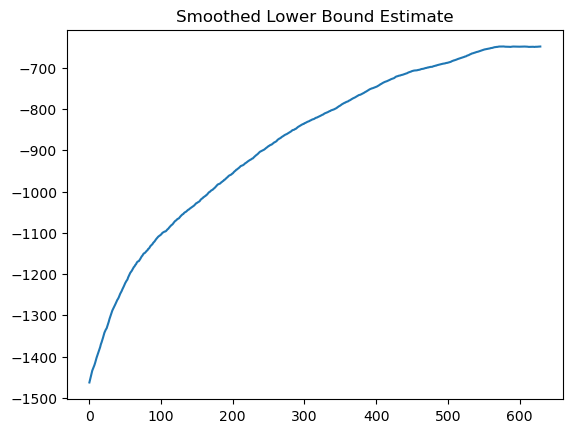

In [63]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [80]:
best_mu = nn_best_lambda[0]
best_vech_l = list(nn_best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = ss_multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (60 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.87431763, 33.57680747,  0.39851204])

In [81]:
np.linalg.norm(posterior_mean_estimate - true_theta)

1.447916096641157